# Correlation Analysis: Mergeability Metrics vs Pairwise Merging Performance

This notebook analyzes the correlation between various mergeability metrics and the performance of pairwise model merging using different merger methods.

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from typing import Dict, List, Tuple

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## 1. Load Data

In [17]:
# Paths
MERGEABILITY_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/pairwise_metrics_N20_merged.json"
RESULTS_BASE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/ViT-B-16"
PLOT_SAVE_PATH = "/home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/plots"

# Control whether to read results files with "rot_align" suffix
ROT_ALIGNED_MATCHING = False  # Set to True to read files with "rot_align", False otherwise

# Create plot save directory if it doesn't exist
Path(PLOT_SAVE_PATH).mkdir(parents=True, exist_ok=True)
print(f"Plots will be saved to: {PLOT_SAVE_PATH}\n")

# Load mergeability metrics
with open(MERGEABILITY_PATH, 'r') as f:
    mergeability_data = json.load(f)

datasets = mergeability_data['datasets']
metrics = mergeability_data['metrics']

print(f"Number of datasets: {len(datasets)}")
print(f"Datasets: {datasets}")
print(f"\nMergeability metrics available: {list(metrics.keys())}")

Plots will be saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/plots

Number of datasets: 20
Datasets: ['SUN397', 'Cars', 'RESISC45', 'EuroSAT', 'SVHN', 'GTSRB', 'MNIST', 'DTD', 'Flowers102', 'PCAM', 'FER2013', 'OxfordIIITPet', 'STL10', 'CIFAR100', 'CIFAR10', 'Food101', 'FashionMNIST', 'EMNIST', 'KMNIST', 'RenderedSST2']

Mergeability metrics available: ['right_subspace_overlap_top_k', 'right_subspace_overlap_bottom_k', 'interaction_matrix_overlap_top_k', 'interaction_matrix_overlap_bottom_k', 'effective_rank', 'effective_rank_mergeability_score', 'stable_rank', 'spectral_gap', 'singular_value_ratio', 'layerwise_effective_rank', 'layerwise_effective_rank_mergeability_score', 'task_vector_cosine_similarity', 'task_vector_l2_distance', 'task_vector_dot_product', 'weight_space_angle', 'task_vector_magnitude_ratio', 'singular_value_overlap', 'subspace_overlap', 'right_subspace_overlap', 'activation_l2_distance', 'activation_cosine_similarity', 'activ

In [18]:
# Identify merger methods from subdirectories
results_path = Path(RESULTS_BASE_PATH)
merger_methods = [d.name for d in results_path.iterdir() if d.is_dir()]
print(f"Merger methods found: {merger_methods}")

Merger methods found: ['weight_avg', 'isotropic', 'tsv', 'arithmetic']


## 2. Extract Mergeability Metrics for Each Pair

In [19]:
def extract_mergeability_values(metrics_dict: Dict, datasets: List[str]) -> Dict[str, Dict[str, float]]:
    """
    Extract mergeability values for each dataset pair from the metrics dictionary.
    
    Returns:
        Dict mapping metric_name -> {"dataset1__dataset2": value}
    """
    mergeability_values = {}
    
    for metric_name, metric_data in metrics_dict.items():
        mergeability_values[metric_name] = {}
        matrix = metric_data['matrix']
        
        for i in range(len(datasets)):
            for j in range(i + 1, len(datasets)):
                pair_name = f"{datasets[i]}__{datasets[j]}"
                value = matrix[i][j]
                if value is not None:
                    mergeability_values[metric_name][pair_name] = value
    
    return mergeability_values

mergeability_values = extract_mergeability_values(metrics, datasets)

# Show example
example_metric = list(mergeability_values.keys())[0]
example_pairs = list(mergeability_values[example_metric].items())[:5]
print(f"\nExample - {example_metric}:")
for pair, value in example_pairs:
    print(f"  {pair}: {value:.6f}")


Example - right_subspace_overlap_top_k:
  SUN397__Cars: 0.410936
  SUN397__RESISC45: 0.443241
  SUN397__EuroSAT: 0.369886
  SUN397__SVHN: 0.296418
  SUN397__GTSRB: 0.325268


## 3. Extract Performance Values for Each Pair and Merger

In [20]:
def extract_performance_values(base_path: str, merger_method: str) -> Dict[str, float]:
    """
    Extract performance values for each dataset pair using a specific merger method.
    Finds all pair_TaskA__TaskB.json files in the merger folder.

    Returns:
        Dict mapping "dataset1__dataset2" -> avg normalized accuracy
    """
    performance_values = {}
    merger_path = Path(base_path) / merger_method

    if not merger_path.exists():
        print(f"Warning: {merger_path} does not exist")
        return performance_values

    # Find all JSON files that start with "pair_" (excluding "all_pairwise" etc.)
    for file_path in merger_path.glob("*.json"):
        try:
            filename = file_path.stem  # removes .json
            
            # ONLY process files that start with "pair_" (not "all_pairwise" or anything else)
            if not filename.startswith("pair_"):
                continue
            
            # Filter based on ROT_ALIGNED_MATCHING setting
            has_rot_align = "_rot_align" in filename
            if ROT_ALIGNED_MATCHING and not has_rot_align:
                continue  # Skip files without "rot_align" when we want them
            if not ROT_ALIGNED_MATCHING and has_rot_align:
                continue  # Skip files with "rot_align" when we don't want them
            
            # Extract pair name from filename: "pair_SUN397__Cars" -> "SUN397__Cars"
            # or "pair_SUN397__Cars_rot_align" -> "SUN397__Cars"
            pair_name = filename[5:]  # Remove "pair_" prefix
            
            # Remove "_rot_align" suffix if present
            if pair_name.endswith("_rot_align"):
                pair_name = pair_name[:-10]  # Remove "_rot_align"
            
            # Validate that it contains "__" to separate the two tasks
            if "__" not in pair_name:
                continue

            # Read the file and extract performance
            with open(file_path, 'r') as f:
                data = json.load(f)

            # Extract average normalized accuracy
            if 'avg' in data and len(data['avg']) > 0:
                avg_normalized_acc = data['avg'][0].get('normalized_acc/test/avg', None)
                if avg_normalized_acc is not None:
                    performance_values[pair_name] = avg_normalized_acc
                    
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return performance_values

# Extract performance for all merger methods
performance_by_merger = {}
for merger in merger_methods:
    performance_by_merger[merger] = extract_performance_values(RESULTS_BASE_PATH, merger)
    print(f"\n{merger}: Found {len(performance_by_merger[merger])} pairs")

    # Show examples
    if len(performance_by_merger[merger]) > 0:
        example_pairs = list(performance_by_merger[merger].items())[:3]
        for pair, perf in example_pairs:
            print(f"  {pair}: {perf:.4f}")
    else:
        print(f"  No performance data found")


weight_avg: Found 191 pairs
  SUN397__FashionMNIST: 0.9646
  STL10__CIFAR10: 0.9894
  FashionMNIST__EMNIST: 0.9808

isotropic: Found 184 pairs
  Flowers102__FER2013: 0.8856
  SVHN__OxfordIIITPet: 0.9162
  STL10__FashionMNIST: 0.9511

tsv: Found 189 pairs
  MNIST__OxfordIIITPet: 0.9953
  EuroSAT__PCAM: 0.9438
  OxfordIIITPet__STL10: 1.0020

arithmetic: Found 190 pairs
  Flowers102__CIFAR10: 0.9131
  Cars__KMNIST: 0.6965
  FER2013__RenderedSST2: 0.9261


In [21]:
mergeability_values

{'right_subspace_overlap_top_k': {'SUN397__Cars': 0.4109360390434528,
  'SUN397__RESISC45': 0.44324062165764155,
  'SUN397__EuroSAT': 0.3698862377154935,
  'SUN397__SVHN': 0.29641791372241155,
  'SUN397__GTSRB': 0.32526759934444743,
  'SUN397__MNIST': 0.2981879843363283,
  'SUN397__DTD': 0.4141468574805016,
  'SUN397__Flowers102': 0.38940235061328954,
  'SUN397__PCAM': 0.33066198602807745,
  'SUN397__FER2013': 0.33061586108541163,
  'SUN397__OxfordIIITPet': 0.400122403781751,
  'SUN397__STL10': 0.40868983088601024,
  'SUN397__CIFAR100': 0.40359954270687637,
  'SUN397__CIFAR10': 0.3745351098643523,
  'SUN397__Food101': 0.38426921448822626,
  'SUN397__FashionMNIST': 0.3268134537838796,
  'SUN397__EMNIST': 0.29843614629004583,
  'SUN397__KMNIST': 0.3015980699228974,
  'SUN397__RenderedSST2': 0.2808024621935723,
  'Cars__RESISC45': 0.36349822593260134,
  'Cars__EuroSAT': 0.31259632409291643,
  'Cars__SVHN': 0.3002623339393954,
  'Cars__GTSRB': 0.3285049993479461,
  'Cars__MNIST': 0.3137153

## 4. Create Correlation Data

In [22]:
def create_correlation_data(mergeability_values: Dict[str, Dict[str, float]], 
                           performance_values: Dict[str, float], 
                           metric_name: str) -> Tuple[List[float], List[float], List[str]]:
    """
    Create aligned lists of mergeability and performance values for correlation analysis.
    
    Returns:
        (mergeability_list, performance_list, pair_names)
    """
    mergeability_list = []
    performance_list = []
    pair_names = []
    
    metric_values = mergeability_values[metric_name]
    
    for pair_name in metric_values.keys():
        matching_keys = [key for key in performance_values if key.startswith(pair_name)]
        if matching_keys:
            mergeability_list.append(metric_values[pair_name])
            performance_list.append(performance_values[matching_keys[0]])
            pair_names.append(pair_name)
    
    return mergeability_list, performance_list, pair_names

# Test with one example
test_metric = list(mergeability_values.keys())[0]
test_merger = merger_methods[0]
test_x, test_y, test_names = create_correlation_data(
    mergeability_values, 
    performance_by_merger[test_merger], 
    test_metric
)
print(f"\nTest: {test_metric} vs {test_merger}")
print(f"Number of data points: {len(test_x)}")
print(f"Example pairs: {test_names[:3]}")


Test: right_subspace_overlap_top_k vs weight_avg
Number of data points: 190
Example pairs: ['SUN397__Cars', 'SUN397__RESISC45', 'SUN397__EuroSAT']


## 5. Generate All Scatter Plots

In [23]:
def create_scatter_plot(mergeability_vals: List[float], 
                       performance_vals: List[float],
                       pair_names: List[str],
                       metric_name: str,
                       merger_name: str,
                       ax=None):
    """
    Create a scatter plot with correlation statistics.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate correlations
    if len(mergeability_vals) > 2:
        pearson_r, pearson_p = pearsonr(mergeability_vals, performance_vals)
        spearman_r, spearman_p = spearmanr(mergeability_vals, performance_vals)
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
    
    # Create scatter plot
    ax.scatter(mergeability_vals, performance_vals, alpha=0.6, s=50)
    
    # Add trend line
    if len(mergeability_vals) > 1:
        z = np.polyfit(mergeability_vals, performance_vals, 1)
        p = np.poly1d(z)
        x_line = np.linspace(min(mergeability_vals), max(mergeability_vals), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)
    
    # Labels and title
    ax.set_xlabel(f"{metric_name}", fontsize=11)
    ax.set_ylabel("Normalized Accuracy (Avg)", fontsize=11)
    ax.set_title(f"{merger_name}: {metric_name}\nPearson r={pearson_r:.3f} (p={pearson_p:.3e}), Spearman ρ={spearman_r:.3f} (p={spearman_p:.3e})",
                fontsize=11, pad=10)
    
    ax.grid(True, alpha=0.3)
    
    return pearson_r, pearson_p, spearman_r, spearman_p

Generating 23 x 4 = 92 scatter plots...


Merger: WEIGHT_AVG


Saved: weight_avg_right_subspace_overlap_top_k.png


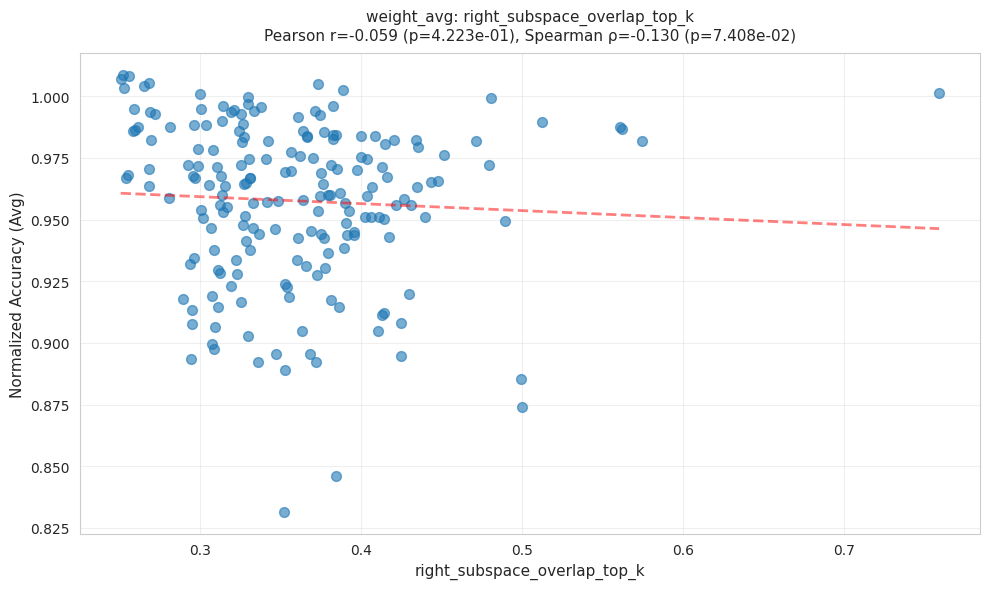


right_subspace_overlap_top_k:
  Data points: 190
  Pearson correlation: r=-0.0586, p=4.2231e-01
  Spearman correlation: ρ=-0.1299, p=7.4080e-02
Saved: weight_avg_right_subspace_overlap_bottom_k.png


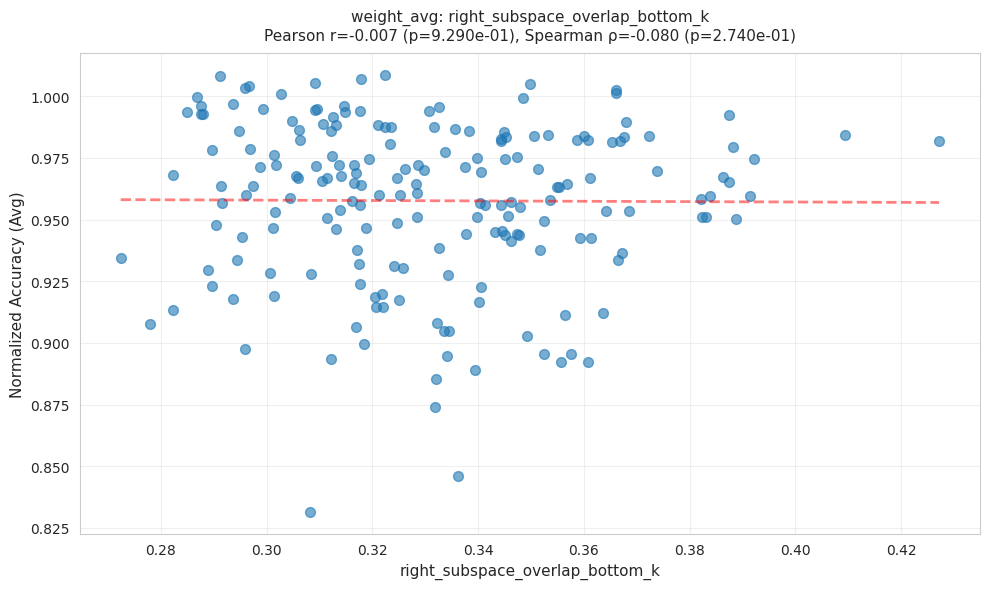


right_subspace_overlap_bottom_k:
  Data points: 190
  Pearson correlation: r=-0.0065, p=9.2895e-01
  Spearman correlation: ρ=-0.0798, p=2.7400e-01
Saved: weight_avg_interaction_matrix_overlap_top_k.png


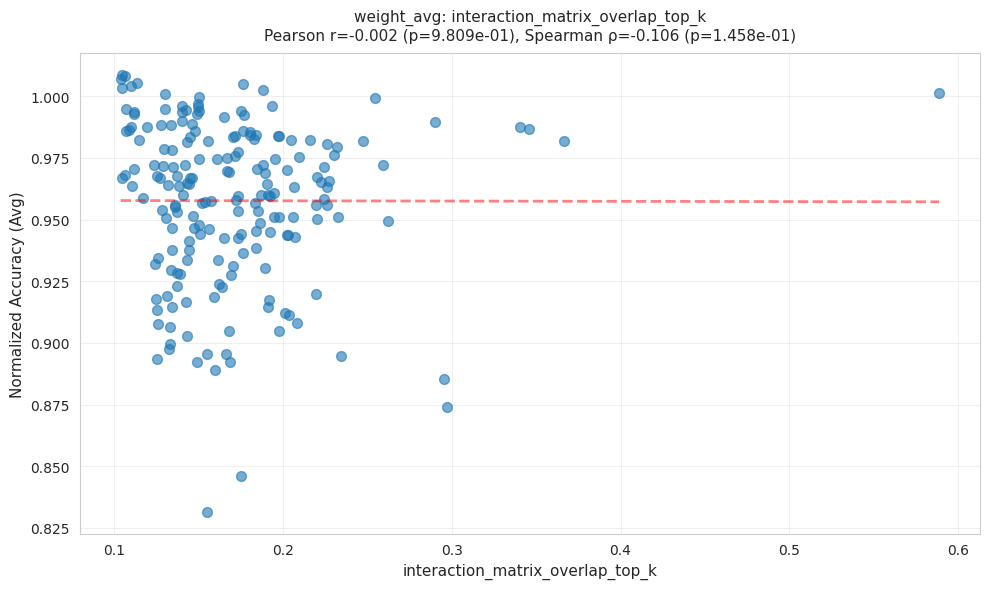


interaction_matrix_overlap_top_k:
  Data points: 190
  Pearson correlation: r=-0.0017, p=9.8090e-01
  Spearman correlation: ρ=-0.1059, p=1.4581e-01
Saved: weight_avg_interaction_matrix_overlap_bottom_k.png


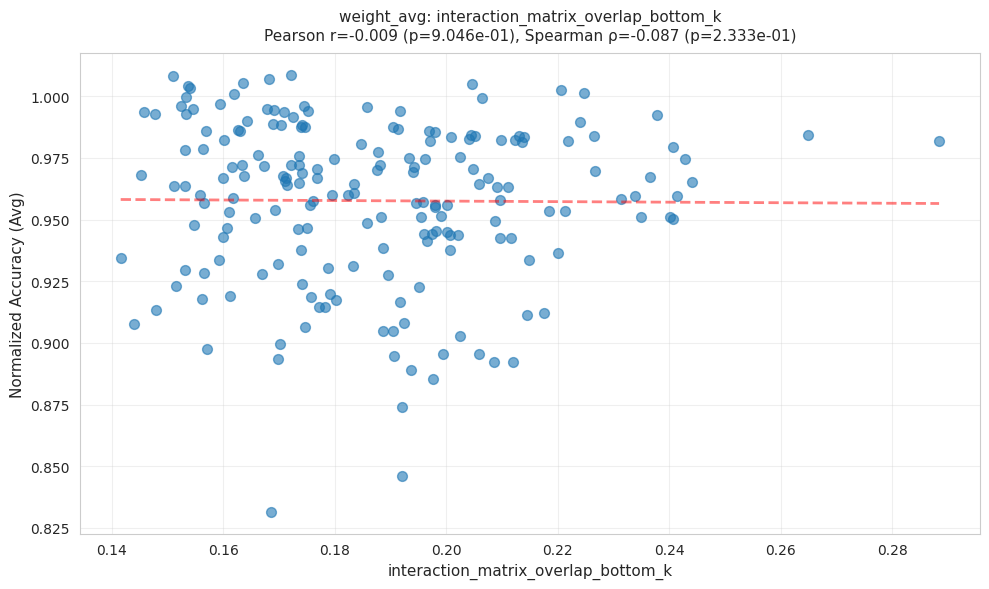


interaction_matrix_overlap_bottom_k:
  Data points: 190
  Pearson correlation: r=-0.0088, p=9.0462e-01
  Spearman correlation: ρ=-0.0869, p=2.3329e-01
Saved: weight_avg_effective_rank.png


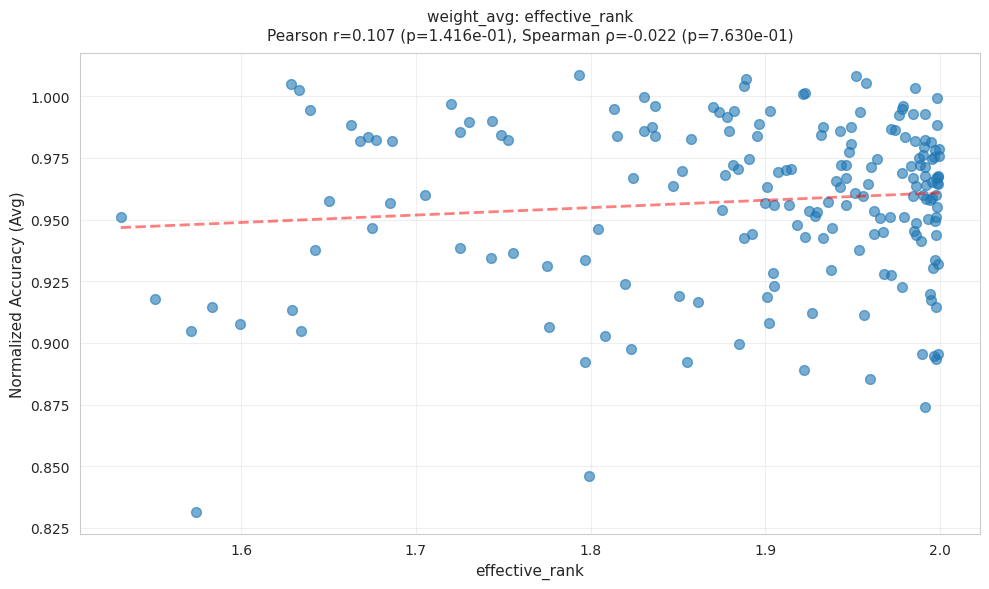


effective_rank:
  Data points: 190
  Pearson correlation: r=0.1070, p=1.4159e-01
  Spearman correlation: ρ=-0.0220, p=7.6300e-01
Saved: weight_avg_effective_rank_mergeability_score.png


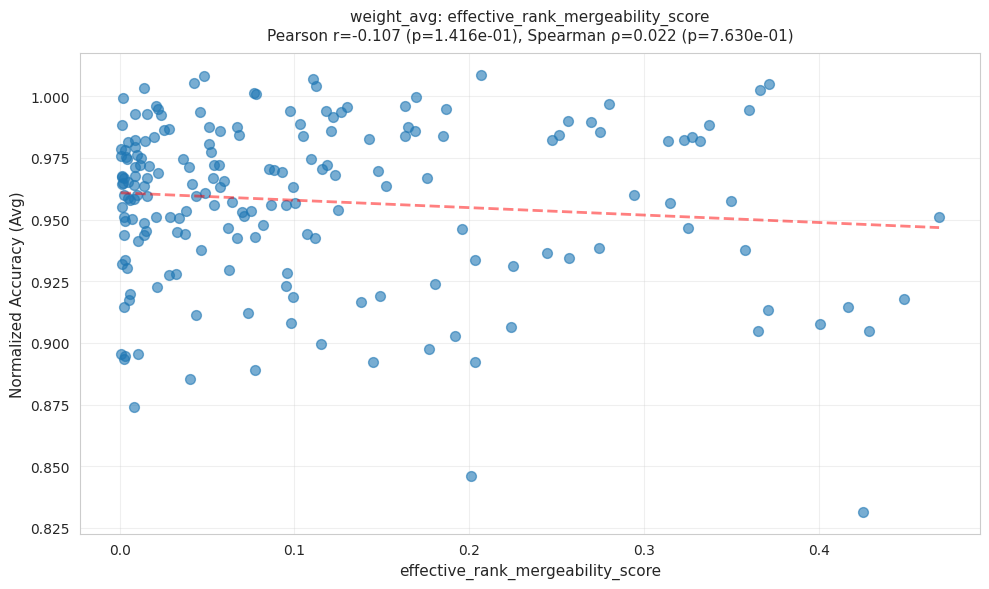


effective_rank_mergeability_score:
  Data points: 190
  Pearson correlation: r=-0.1070, p=1.4159e-01
  Spearman correlation: ρ=0.0220, p=7.6300e-01
Saved: weight_avg_stable_rank.png


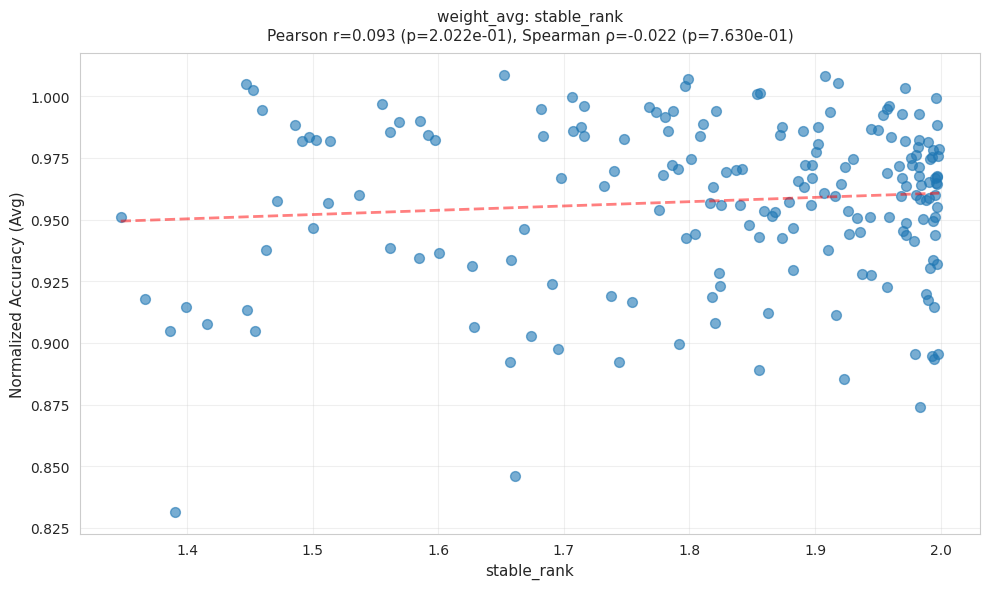


stable_rank:
  Data points: 190
  Pearson correlation: r=0.0929, p=2.0223e-01
  Spearman correlation: ρ=-0.0220, p=7.6300e-01
Saved: weight_avg_spectral_gap.png


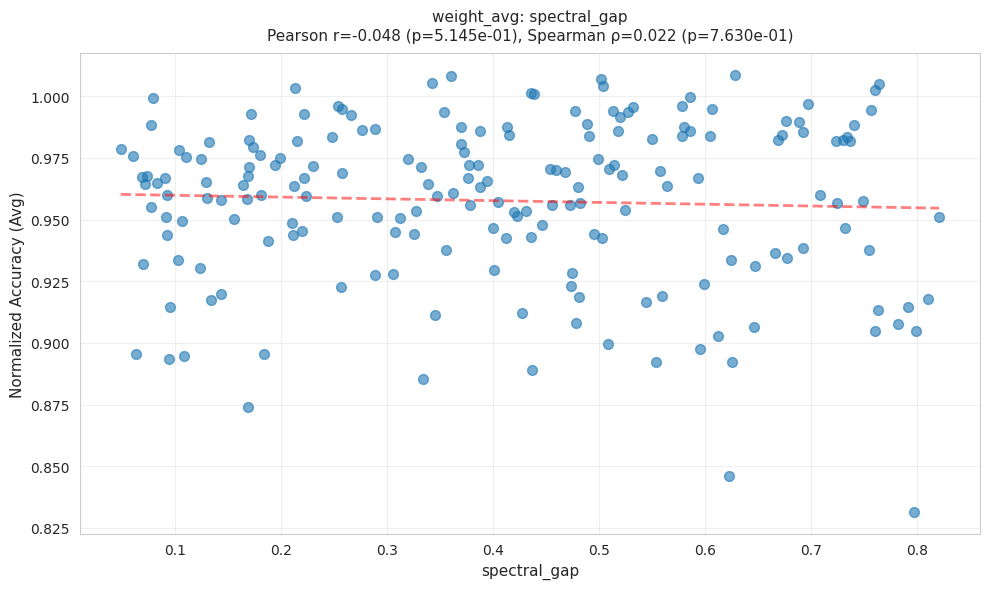


spectral_gap:
  Data points: 190
  Pearson correlation: r=-0.0476, p=5.1453e-01
  Spearman correlation: ρ=0.0220, p=7.6300e-01
Saved: weight_avg_singular_value_ratio.png


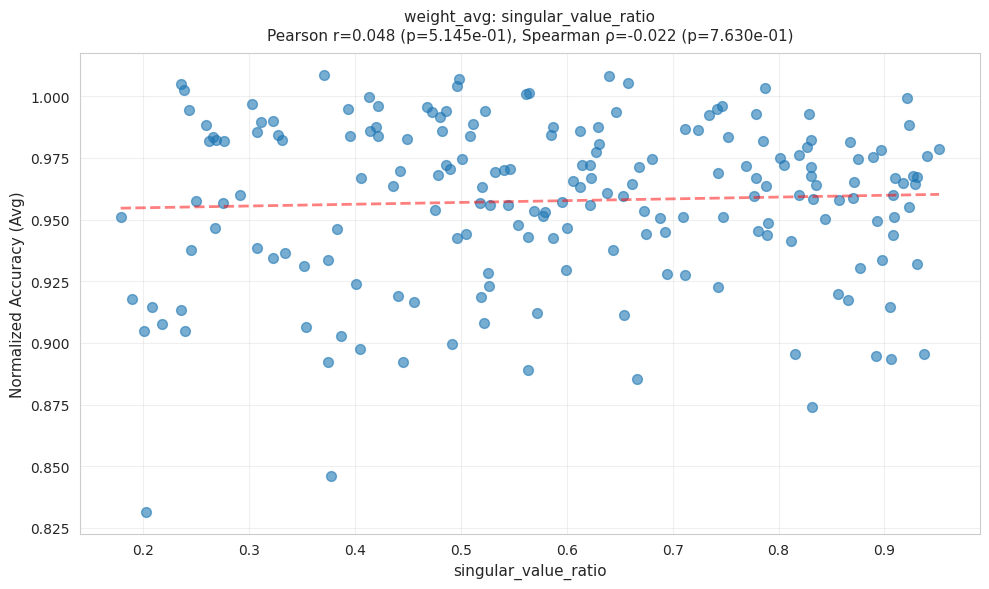


singular_value_ratio:
  Data points: 190
  Pearson correlation: r=0.0476, p=5.1453e-01
  Spearman correlation: ρ=-0.0220, p=7.6300e-01
Saved: weight_avg_layerwise_effective_rank.png


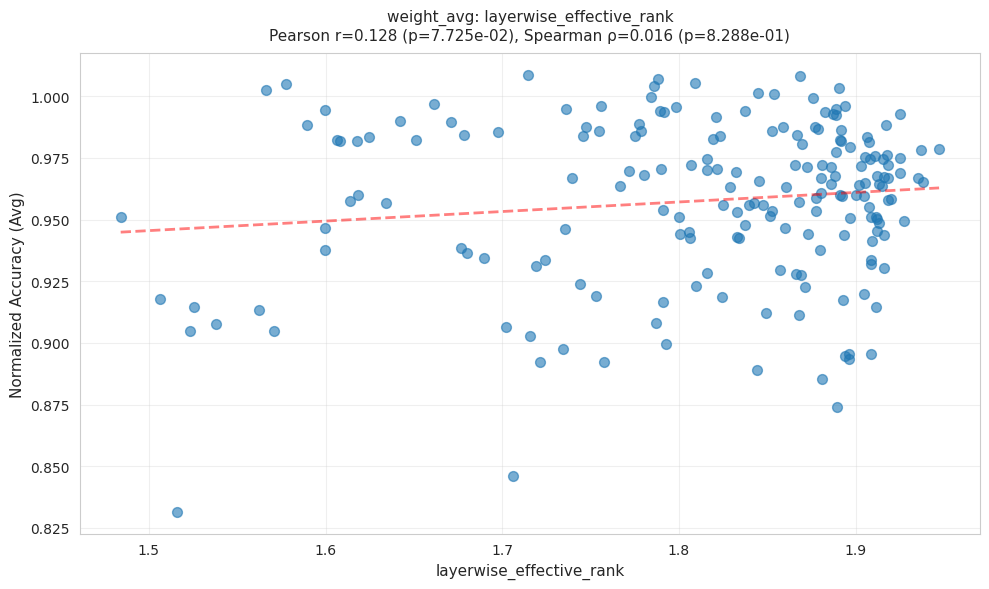


layerwise_effective_rank:
  Data points: 190
  Pearson correlation: r=0.1285, p=7.7248e-02
  Spearman correlation: ρ=0.0158, p=8.2885e-01
Saved: weight_avg_layerwise_effective_rank_mergeability_score.png


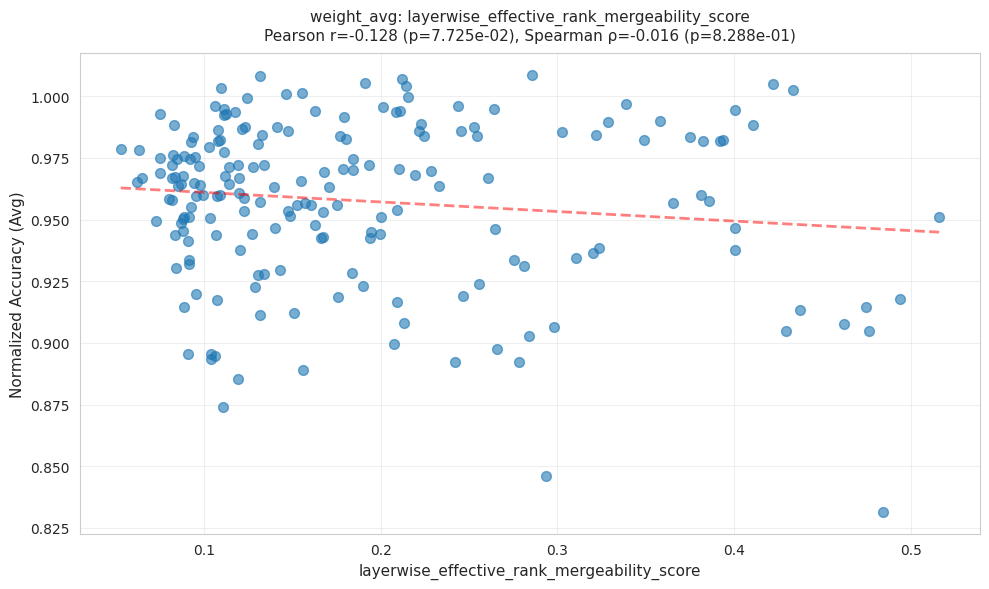


layerwise_effective_rank_mergeability_score:
  Data points: 190
  Pearson correlation: r=-0.1285, p=7.7248e-02
  Spearman correlation: ρ=-0.0158, p=8.2885e-01
Saved: weight_avg_task_vector_cosine_similarity.png


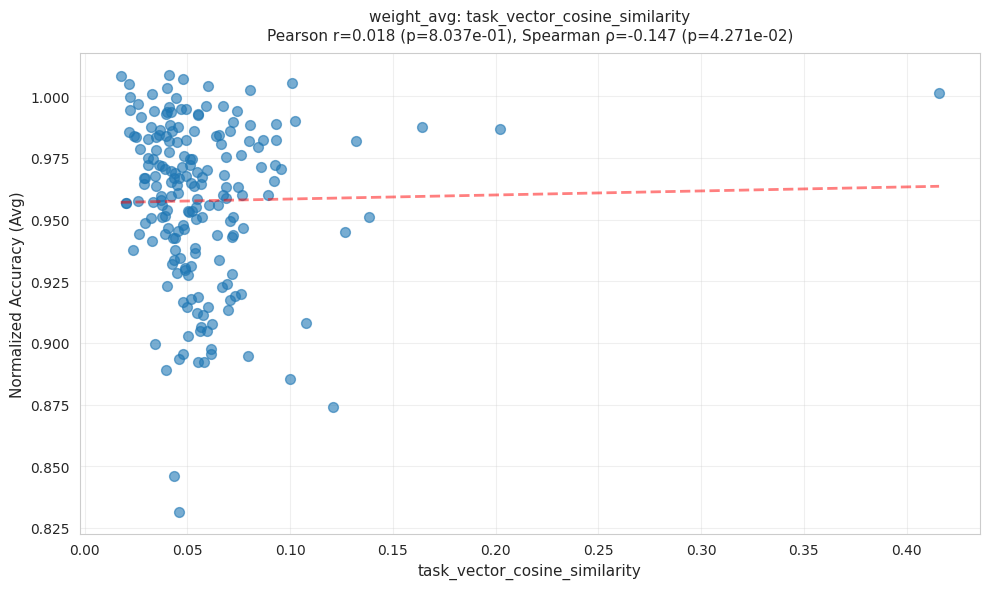


task_vector_cosine_similarity:
  Data points: 190
  Pearson correlation: r=0.0181, p=8.0373e-01
  Spearman correlation: ρ=-0.1472, p=4.2705e-02
Saved: weight_avg_task_vector_l2_distance.png


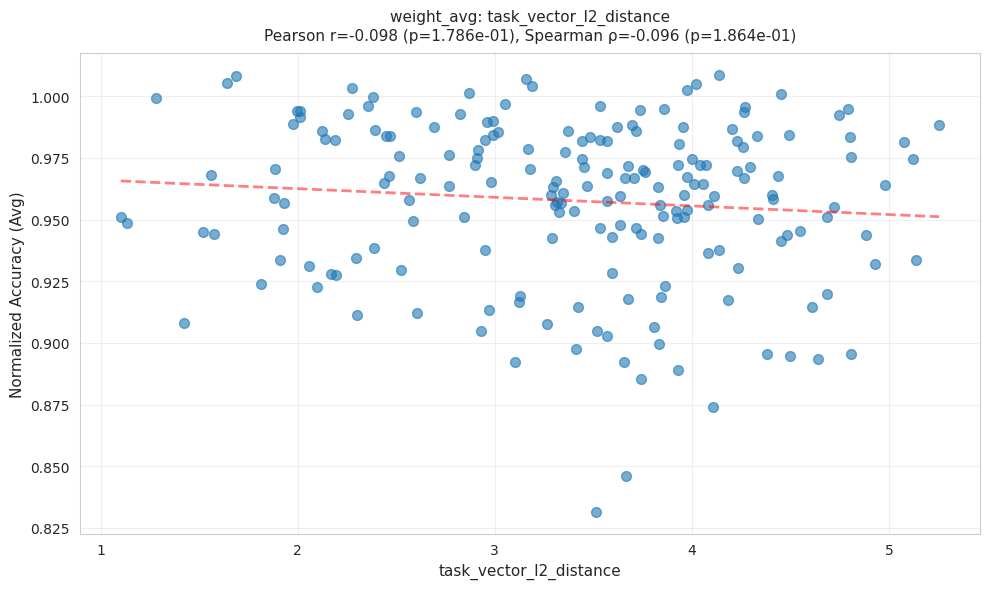


task_vector_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.0980, p=1.7862e-01
  Spearman correlation: ρ=-0.0963, p=1.8643e-01
Saved: weight_avg_task_vector_dot_product.png


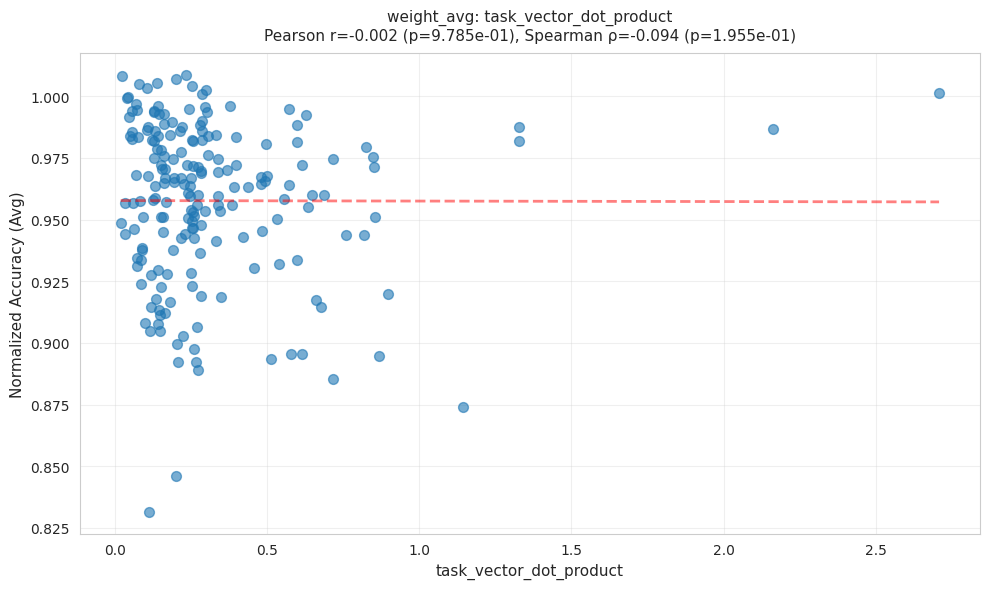


task_vector_dot_product:
  Data points: 190
  Pearson correlation: r=-0.0020, p=9.7851e-01
  Spearman correlation: ρ=-0.0943, p=1.9552e-01
Saved: weight_avg_weight_space_angle.png


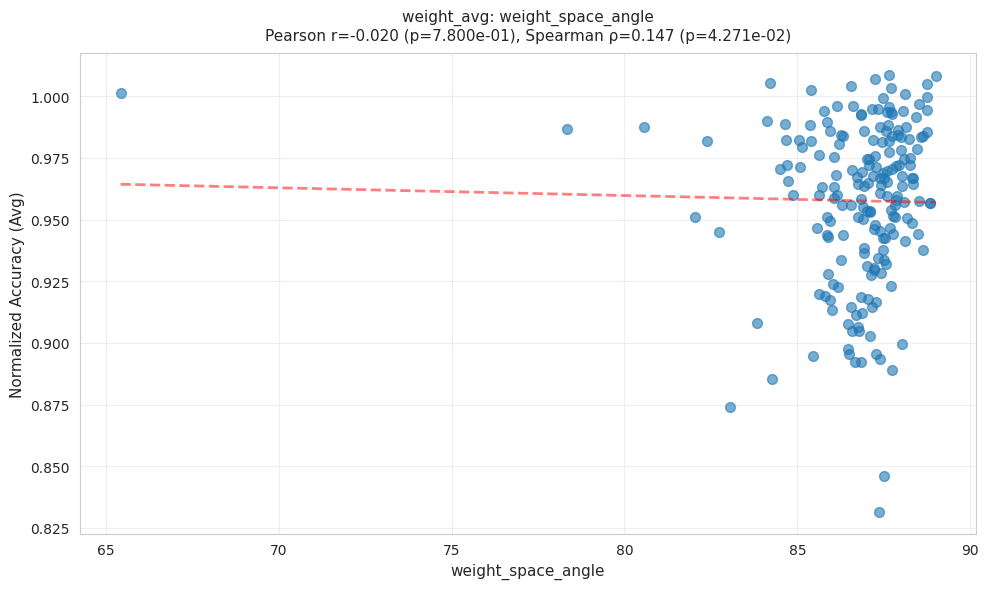


weight_space_angle:
  Data points: 190
  Pearson correlation: r=-0.0204, p=7.8004e-01
  Spearman correlation: ρ=0.1472, p=4.2705e-02
Saved: weight_avg_task_vector_magnitude_ratio.png


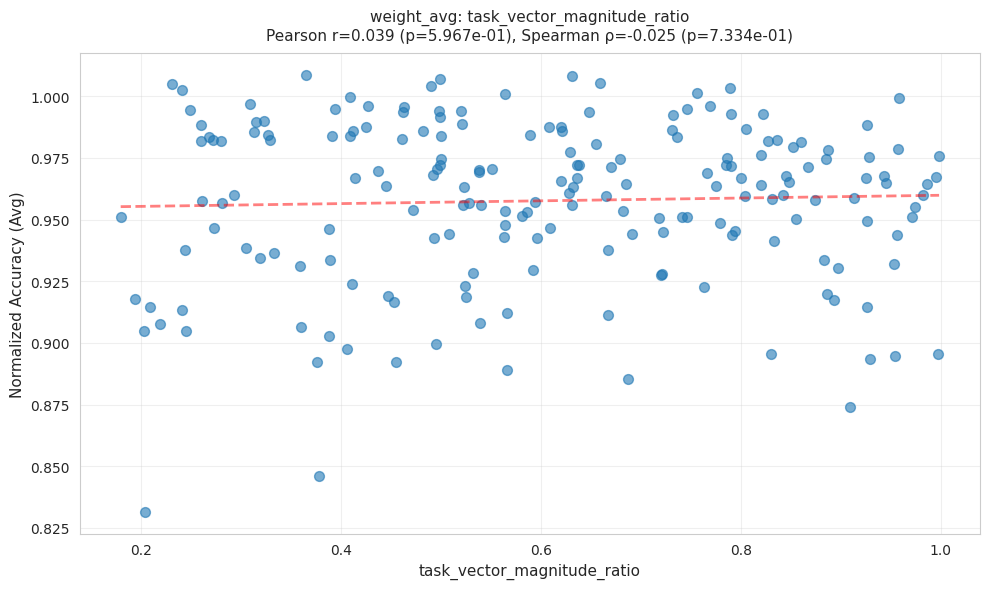


task_vector_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=0.0386, p=5.9674e-01
  Spearman correlation: ρ=-0.0249, p=7.3336e-01
Saved: weight_avg_singular_value_overlap.png


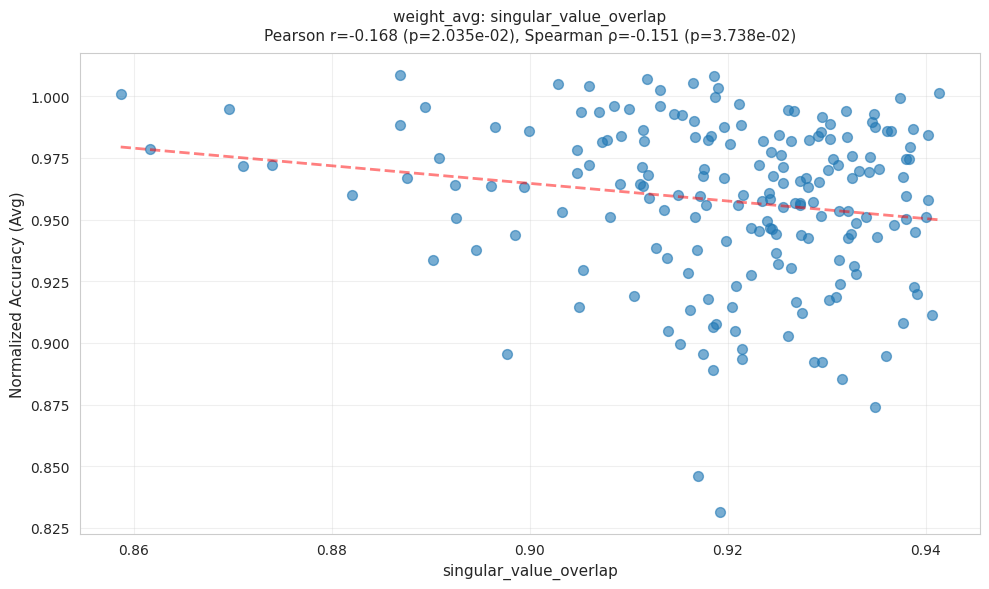


singular_value_overlap:
  Data points: 190
  Pearson correlation: r=-0.1682, p=2.0346e-02
  Spearman correlation: ρ=-0.1511, p=3.7379e-02
Saved: weight_avg_subspace_overlap.png


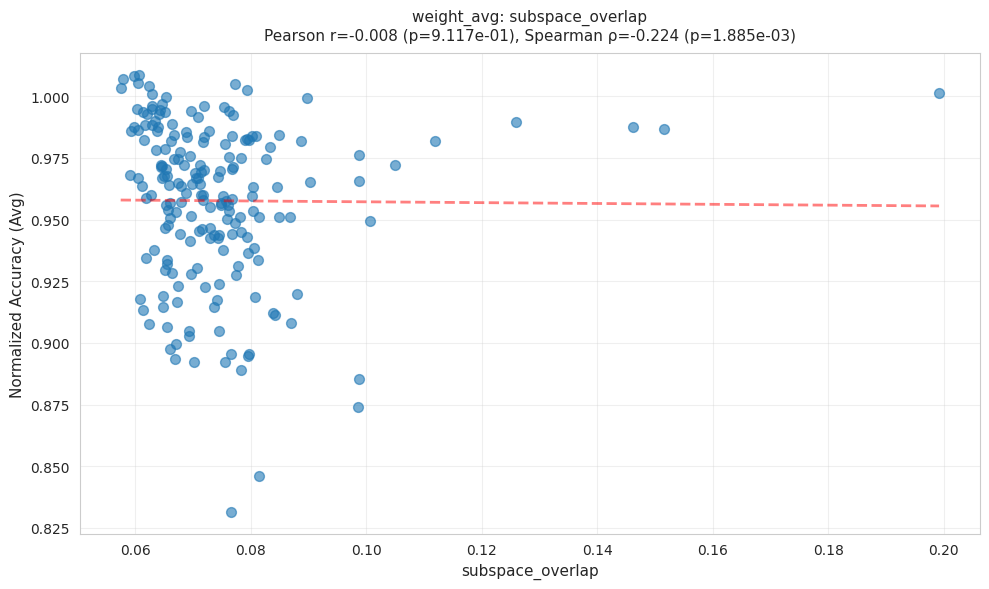


subspace_overlap:
  Data points: 190
  Pearson correlation: r=-0.0081, p=9.1173e-01
  Spearman correlation: ρ=-0.2241, p=1.8853e-03
Saved: weight_avg_right_subspace_overlap.png


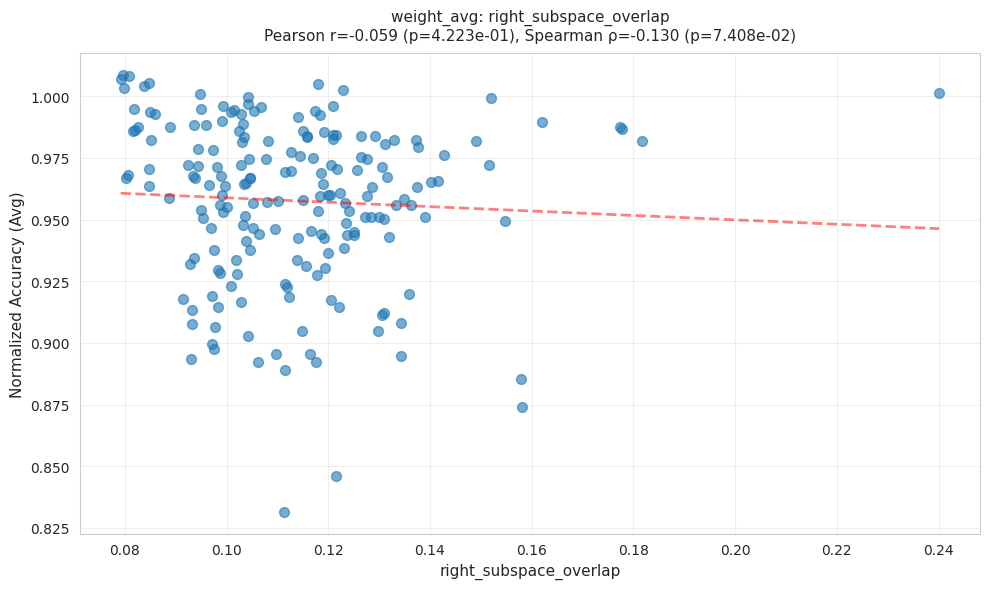


right_subspace_overlap:
  Data points: 190
  Pearson correlation: r=-0.0586, p=4.2231e-01
  Spearman correlation: ρ=-0.1299, p=7.4080e-02
Saved: weight_avg_activation_l2_distance.png


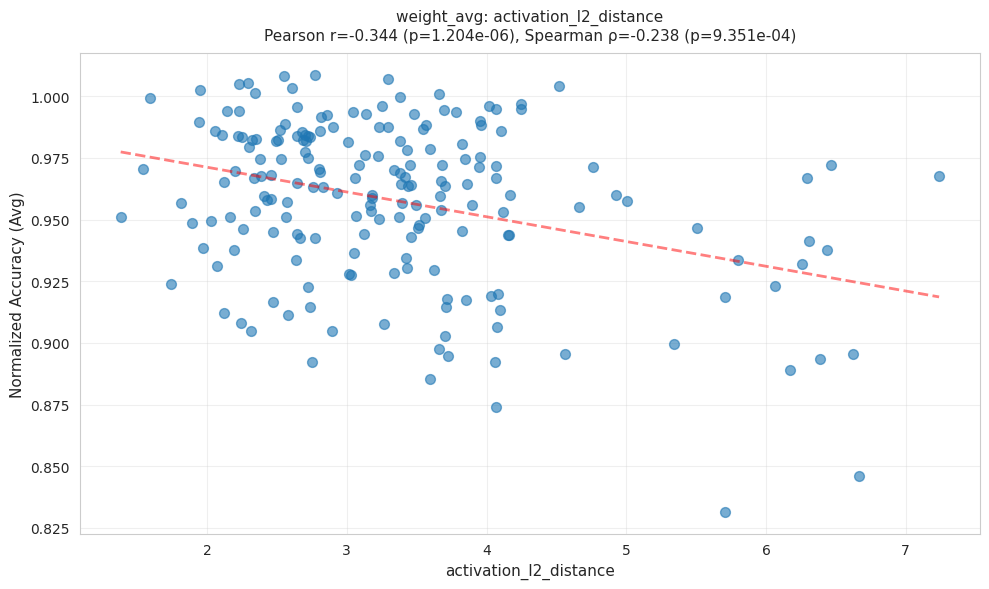


activation_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.3437, p=1.2042e-06
  Spearman correlation: ρ=-0.2382, p=9.3507e-04
Saved: weight_avg_activation_cosine_similarity.png


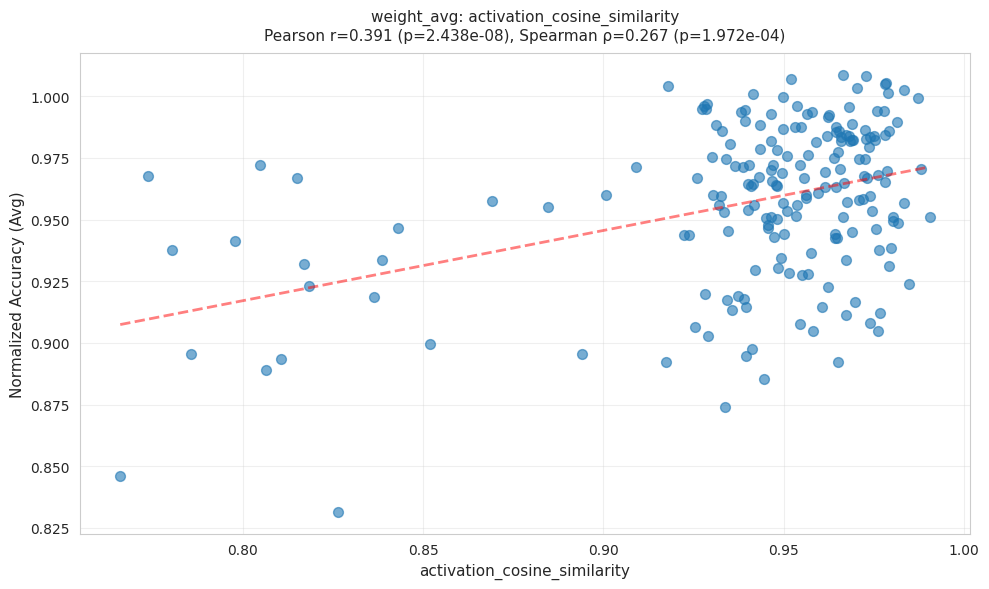


activation_cosine_similarity:
  Data points: 190
  Pearson correlation: r=0.3910, p=2.4383e-08
  Spearman correlation: ρ=0.2669, p=1.9720e-04
Saved: weight_avg_activation_magnitude_ratio.png


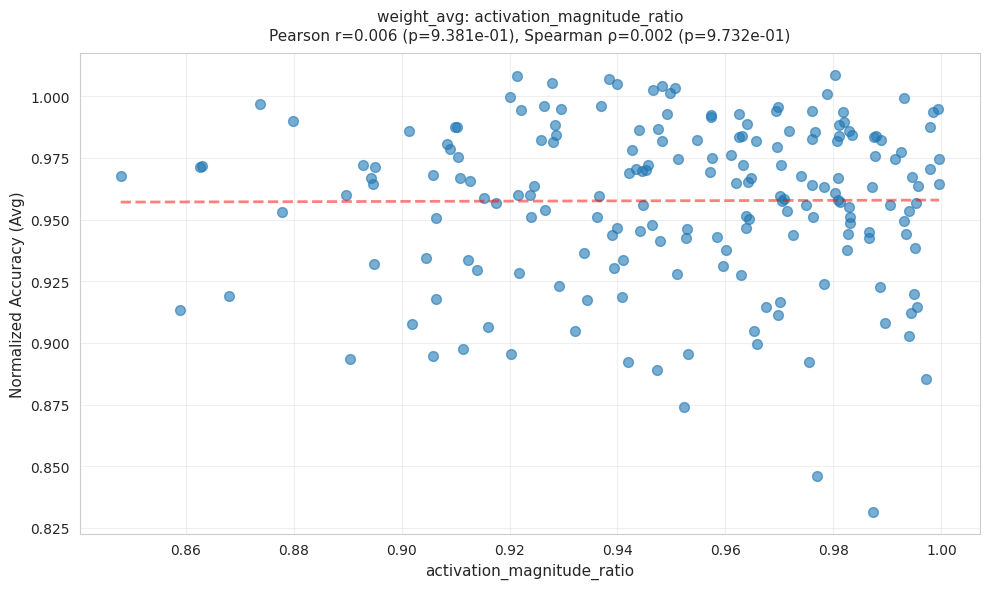


activation_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=0.0057, p=9.3814e-01
  Spearman correlation: ρ=0.0025, p=9.7317e-01
Saved: weight_avg_activation_dot_product.png


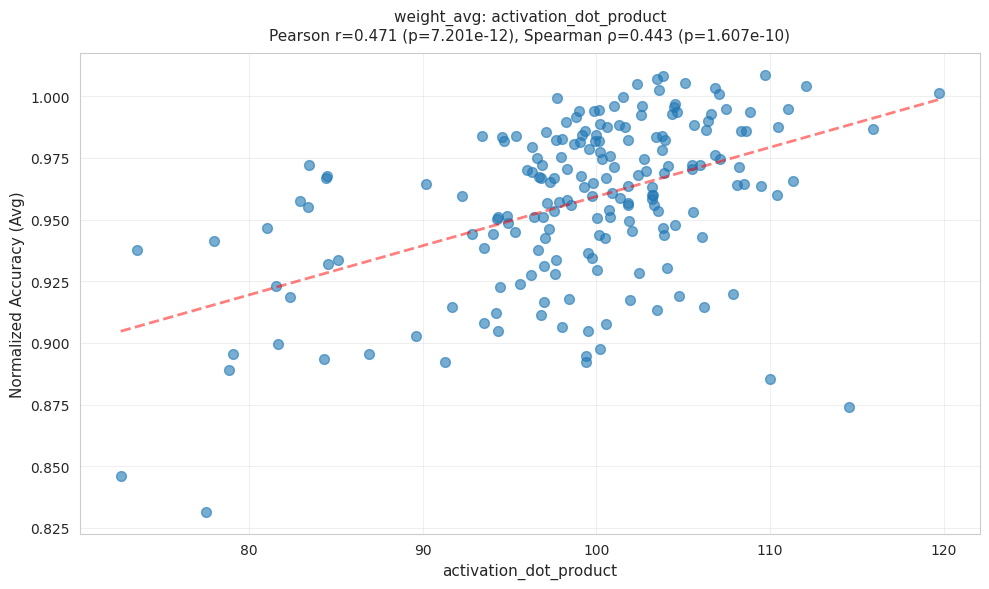


activation_dot_product:
  Data points: 190
  Pearson correlation: r=0.4707, p=7.2010e-12
  Spearman correlation: ρ=0.4427, p=1.6071e-10

Merger: ISOTROPIC
Saved: isotropic_right_subspace_overlap_top_k.png


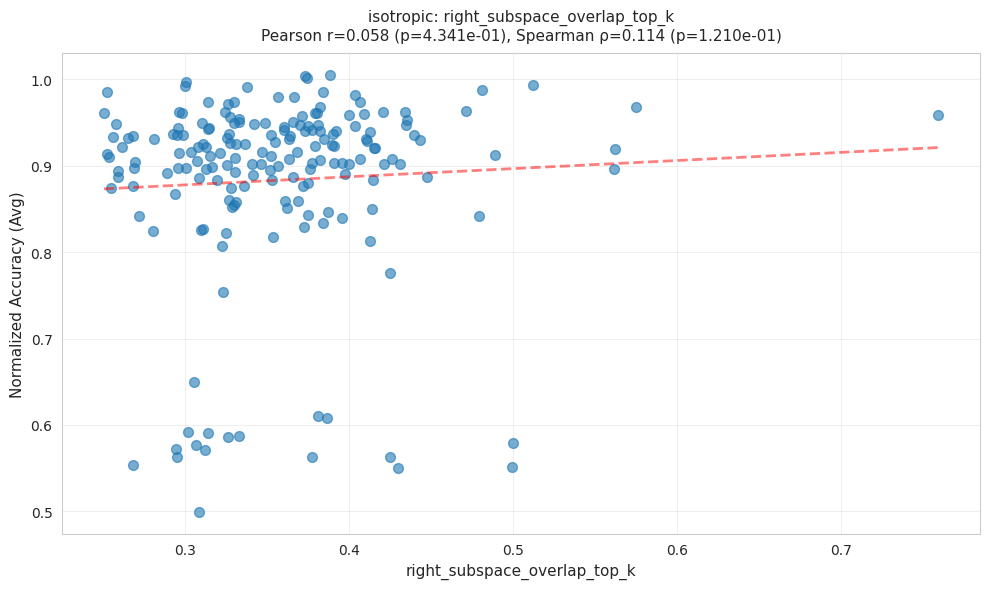


right_subspace_overlap_top_k:
  Data points: 185
  Pearson correlation: r=0.0579, p=4.3407e-01
  Spearman correlation: ρ=0.1144, p=1.2096e-01
Saved: isotropic_right_subspace_overlap_bottom_k.png


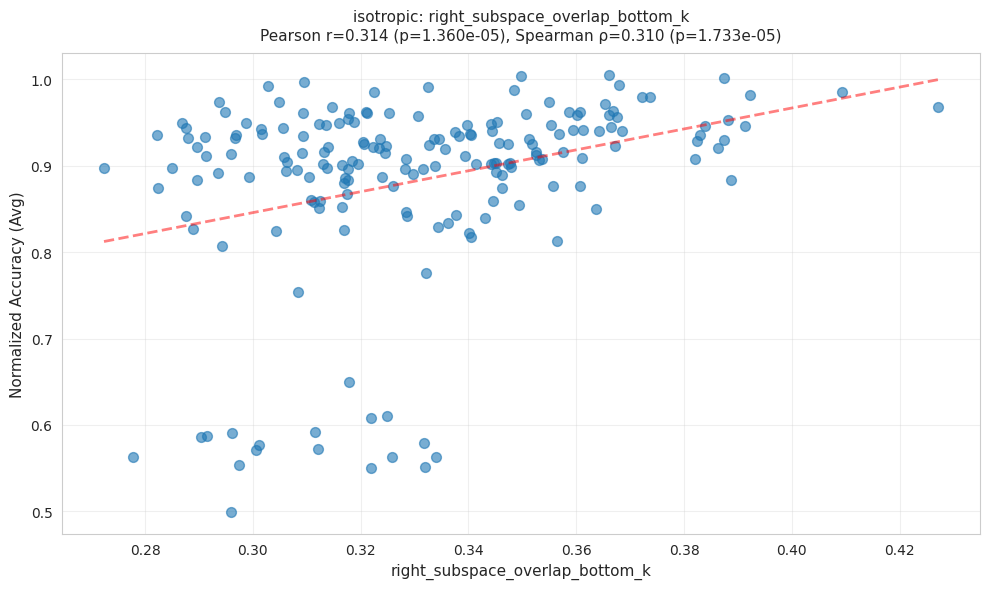


right_subspace_overlap_bottom_k:
  Data points: 185
  Pearson correlation: r=0.3138, p=1.3595e-05
  Spearman correlation: ρ=0.3102, p=1.7331e-05
Saved: isotropic_interaction_matrix_overlap_top_k.png


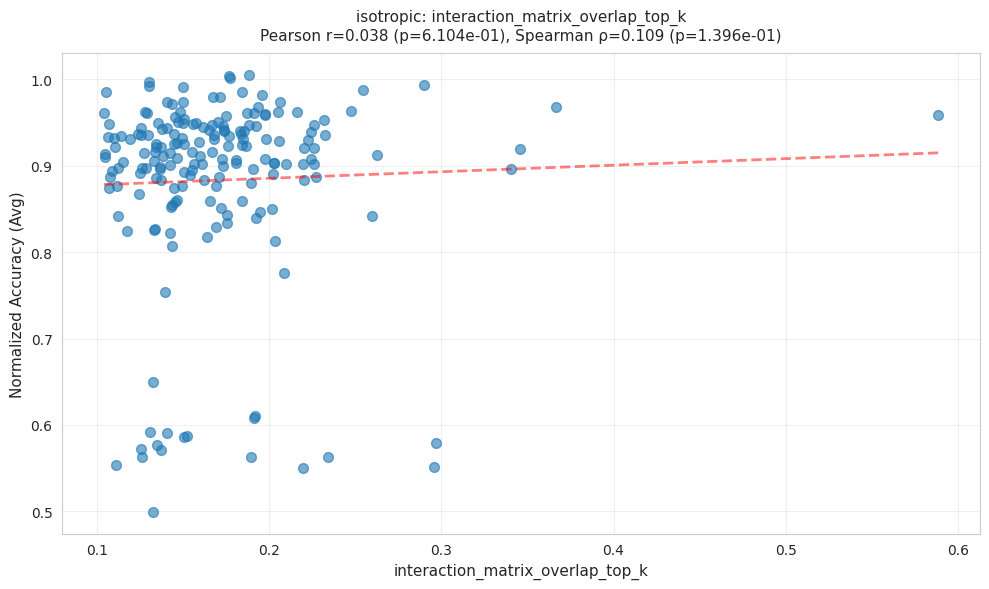


interaction_matrix_overlap_top_k:
  Data points: 185
  Pearson correlation: r=0.0377, p=6.1043e-01
  Spearman correlation: ρ=0.1090, p=1.3962e-01
Saved: isotropic_interaction_matrix_overlap_bottom_k.png


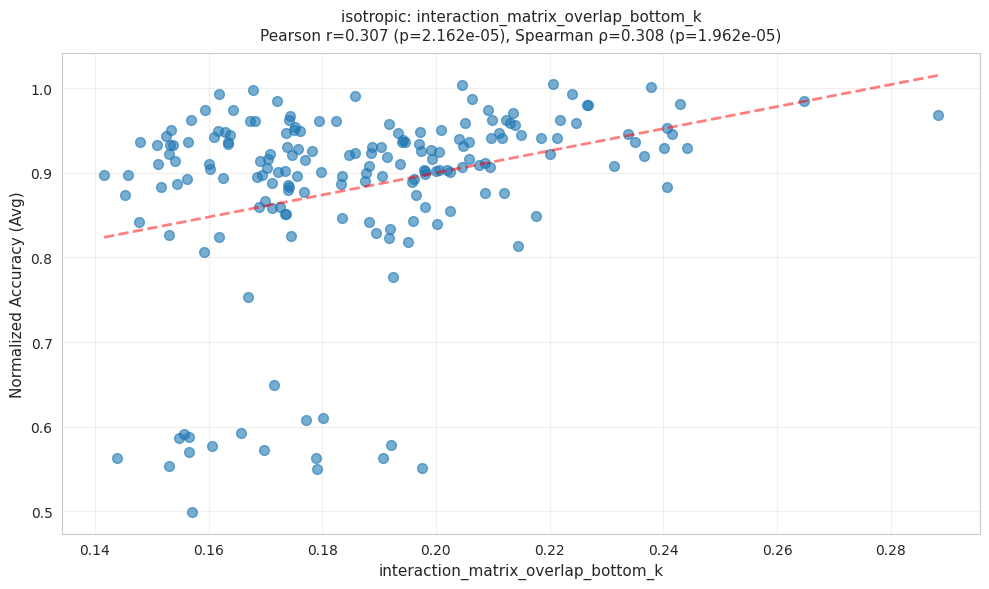


interaction_matrix_overlap_bottom_k:
  Data points: 185
  Pearson correlation: r=0.3068, p=2.1620e-05
  Spearman correlation: ρ=0.3083, p=1.9620e-05
Saved: isotropic_effective_rank.png


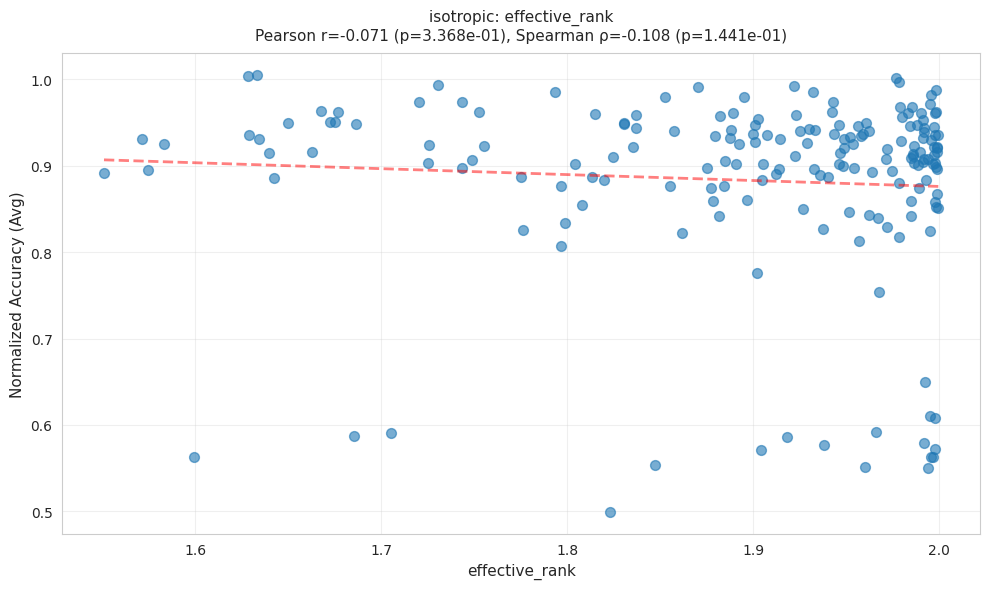


effective_rank:
  Data points: 185
  Pearson correlation: r=-0.0710, p=3.3677e-01
  Spearman correlation: ρ=-0.1078, p=1.4414e-01
Saved: isotropic_effective_rank_mergeability_score.png


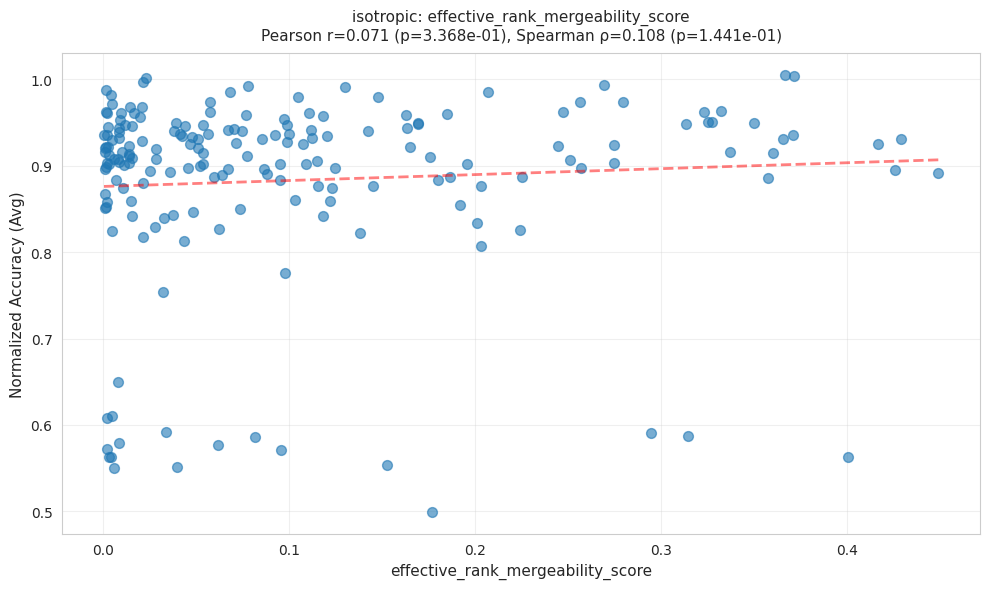


effective_rank_mergeability_score:
  Data points: 185
  Pearson correlation: r=0.0710, p=3.3677e-01
  Spearman correlation: ρ=0.1078, p=1.4414e-01
Saved: isotropic_stable_rank.png


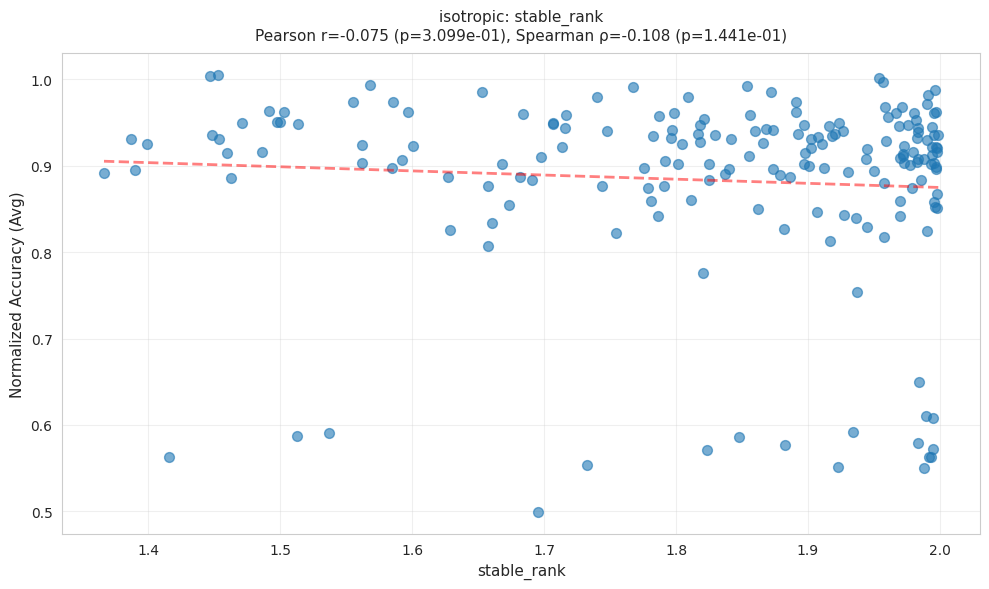


stable_rank:
  Data points: 185
  Pearson correlation: r=-0.0751, p=3.0990e-01
  Spearman correlation: ρ=-0.1078, p=1.4414e-01
Saved: isotropic_spectral_gap.png


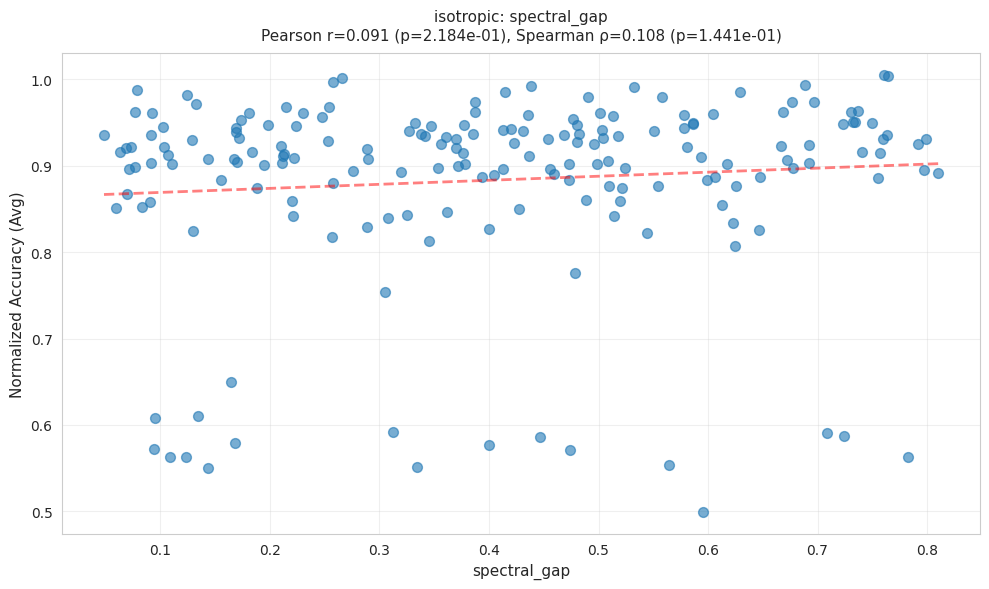


spectral_gap:
  Data points: 185
  Pearson correlation: r=0.0909, p=2.1836e-01
  Spearman correlation: ρ=0.1078, p=1.4414e-01
Saved: isotropic_singular_value_ratio.png


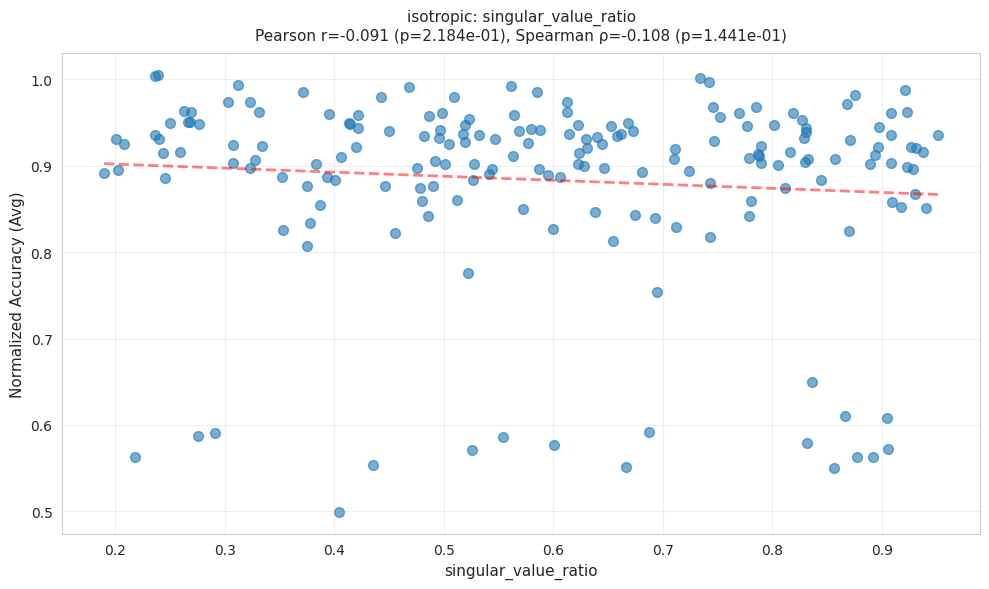


singular_value_ratio:
  Data points: 185
  Pearson correlation: r=-0.0909, p=2.1836e-01
  Spearman correlation: ρ=-0.1078, p=1.4414e-01
Saved: isotropic_layerwise_effective_rank.png


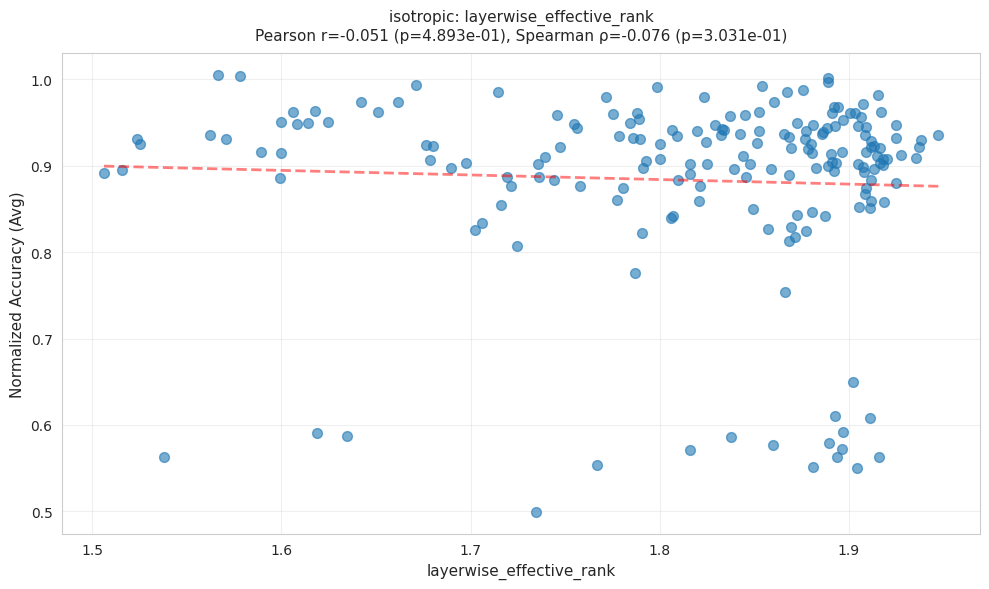


layerwise_effective_rank:
  Data points: 185
  Pearson correlation: r=-0.0511, p=4.8930e-01
  Spearman correlation: ρ=-0.0761, p=3.0310e-01
Saved: isotropic_layerwise_effective_rank_mergeability_score.png


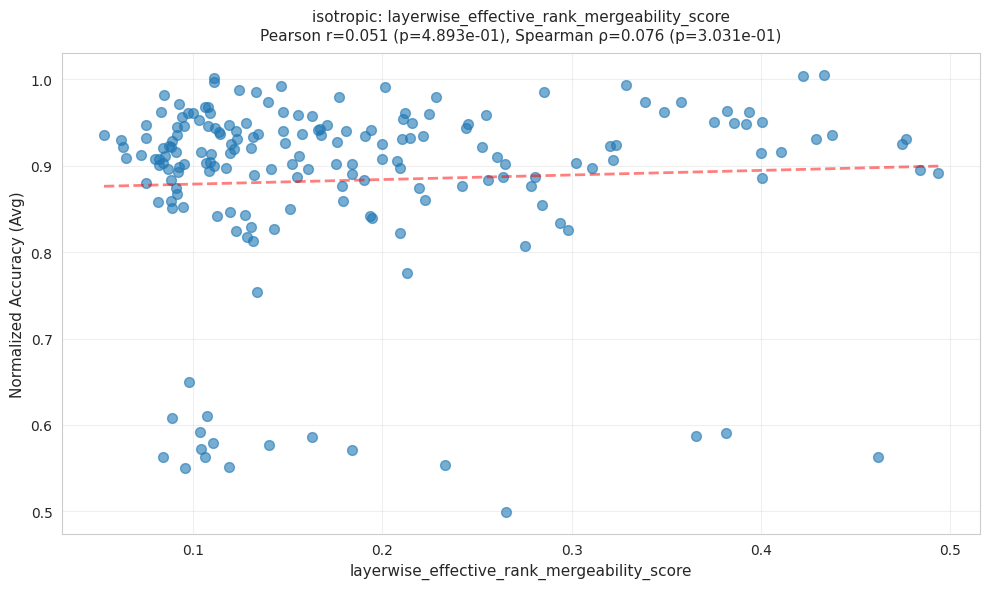


layerwise_effective_rank_mergeability_score:
  Data points: 185
  Pearson correlation: r=0.0511, p=4.8930e-01
  Spearman correlation: ρ=0.0761, p=3.0310e-01
Saved: isotropic_task_vector_cosine_similarity.png


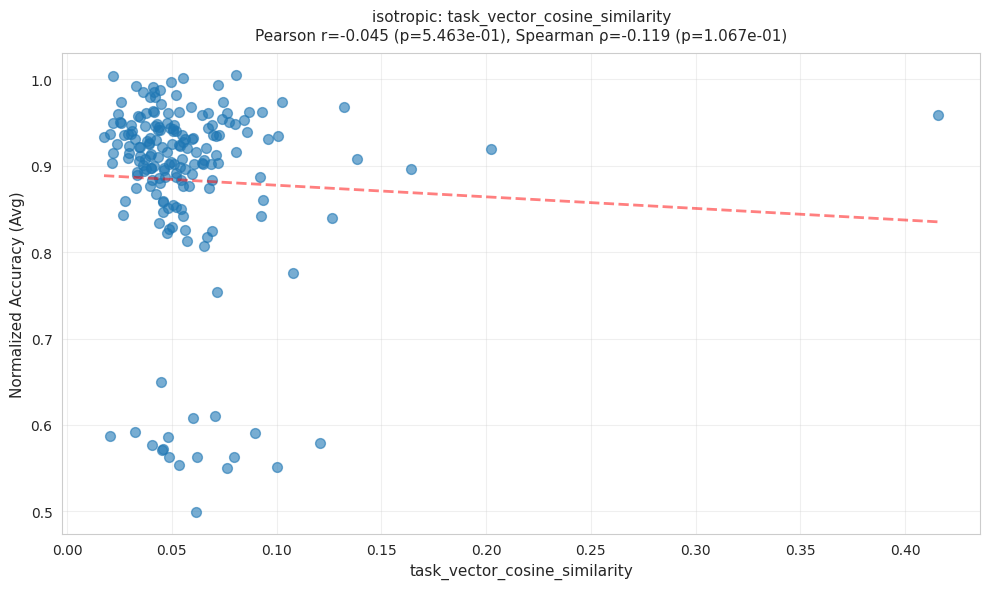


task_vector_cosine_similarity:
  Data points: 185
  Pearson correlation: r=-0.0446, p=5.4629e-01
  Spearman correlation: ρ=-0.1190, p=1.0666e-01
Saved: isotropic_task_vector_l2_distance.png


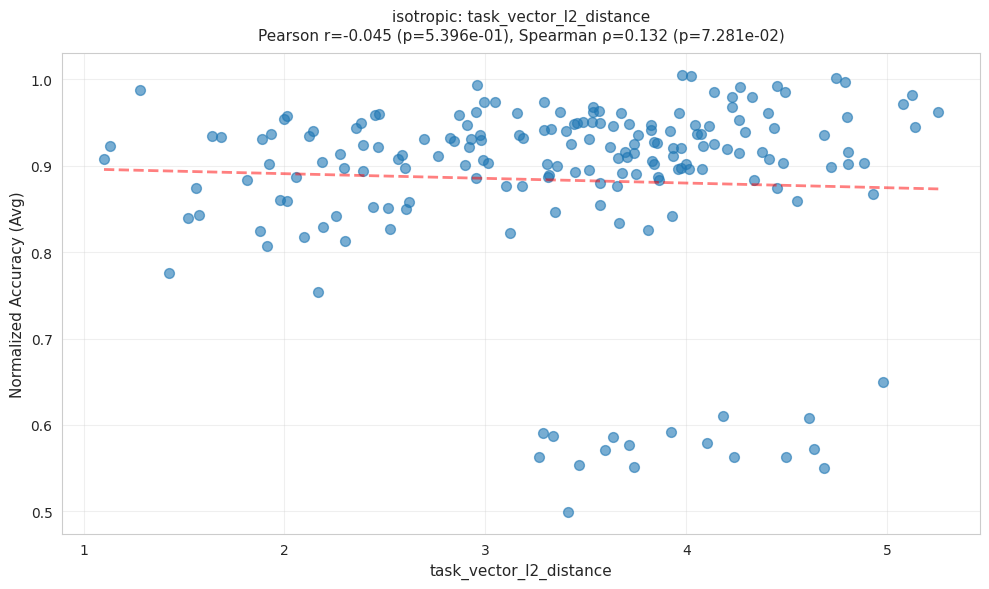


task_vector_l2_distance:
  Data points: 185
  Pearson correlation: r=-0.0454, p=5.3961e-01
  Spearman correlation: ρ=0.1322, p=7.2809e-02
Saved: isotropic_task_vector_dot_product.png


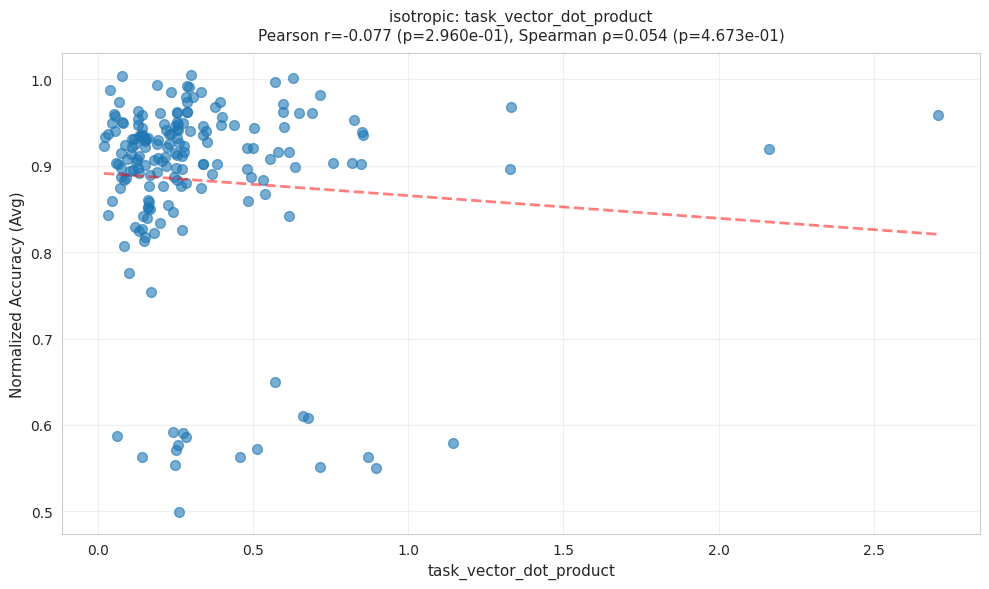


task_vector_dot_product:
  Data points: 185
  Pearson correlation: r=-0.0772, p=2.9600e-01
  Spearman correlation: ρ=0.0538, p=4.6729e-01
Saved: isotropic_weight_space_angle.png


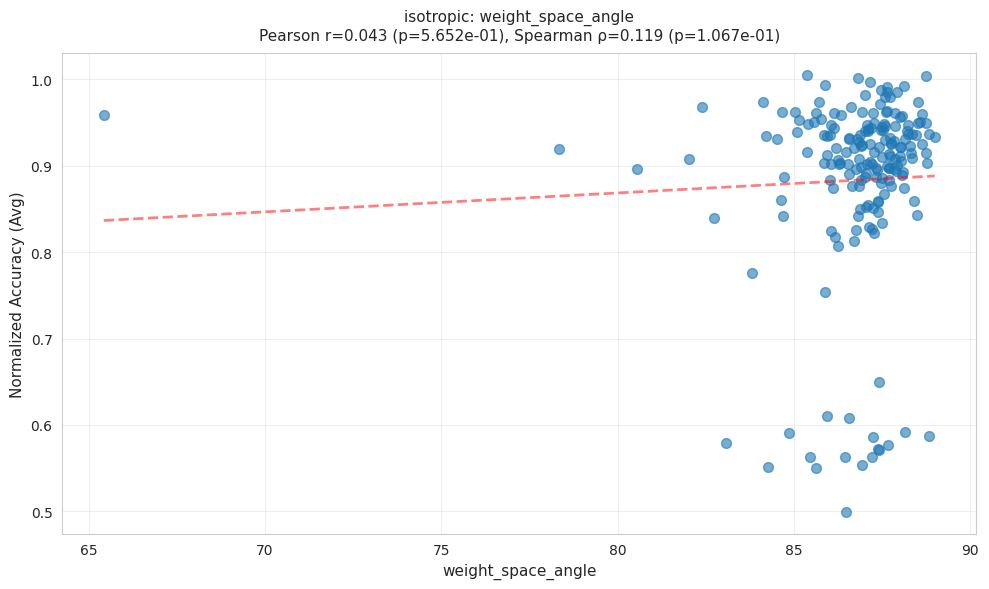


weight_space_angle:
  Data points: 185
  Pearson correlation: r=0.0426, p=5.6517e-01
  Spearman correlation: ρ=0.1190, p=1.0666e-01
Saved: isotropic_task_vector_magnitude_ratio.png


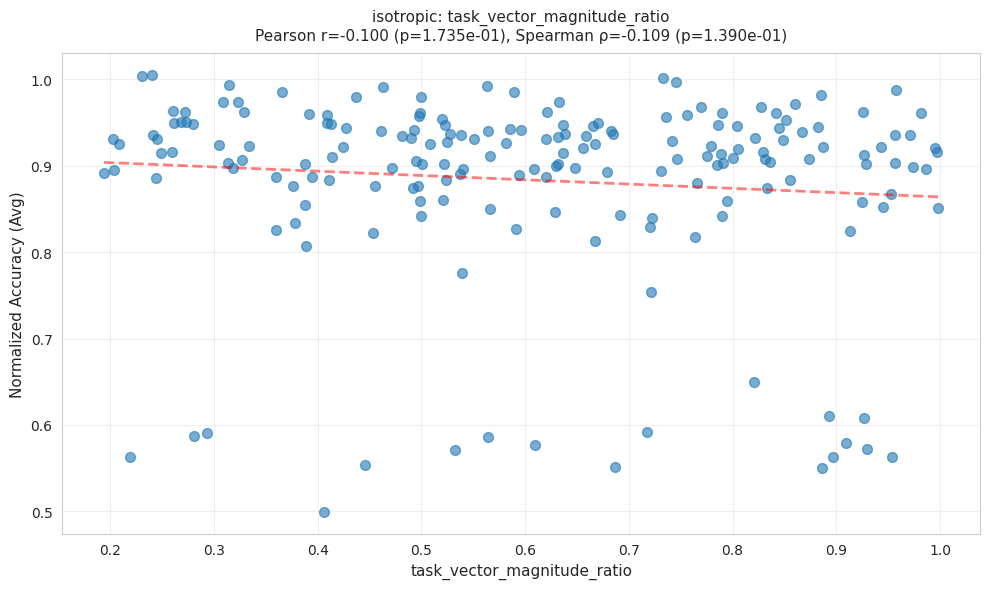


task_vector_magnitude_ratio:
  Data points: 185
  Pearson correlation: r=-0.1005, p=1.7347e-01
  Spearman correlation: ρ=-0.1092, p=1.3897e-01
Saved: isotropic_singular_value_overlap.png


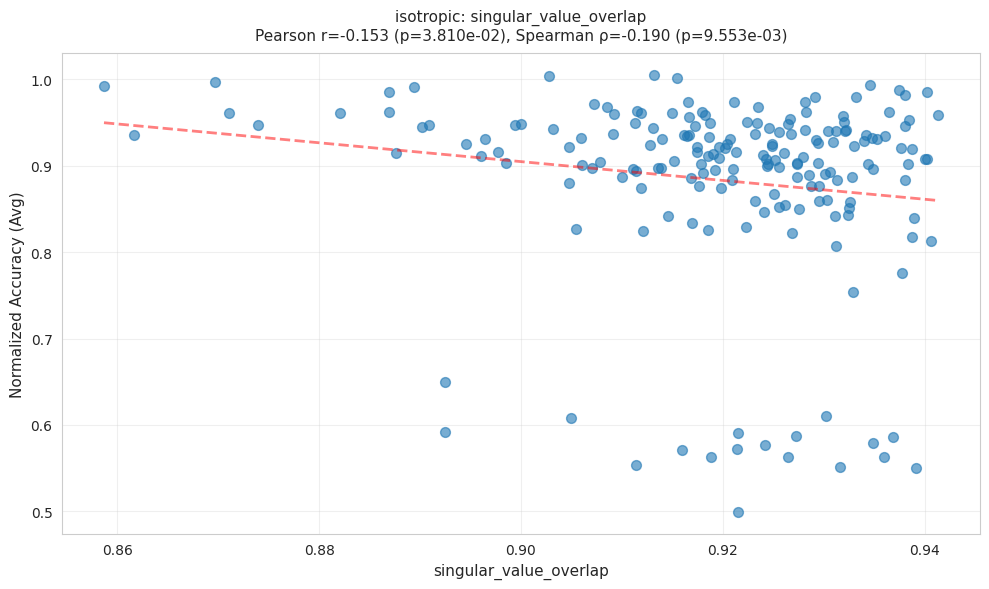


singular_value_overlap:
  Data points: 185
  Pearson correlation: r=-0.1526, p=3.8101e-02
  Spearman correlation: ρ=-0.1901, p=9.5525e-03
Saved: isotropic_subspace_overlap.png


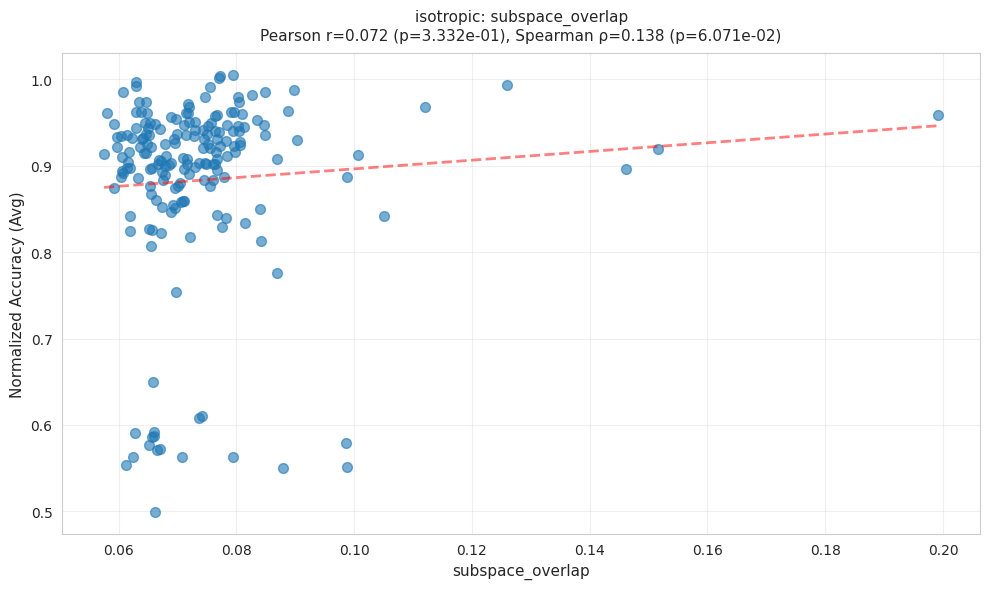


subspace_overlap:
  Data points: 185
  Pearson correlation: r=0.0715, p=3.3316e-01
  Spearman correlation: ρ=0.1382, p=6.0714e-02
Saved: isotropic_right_subspace_overlap.png


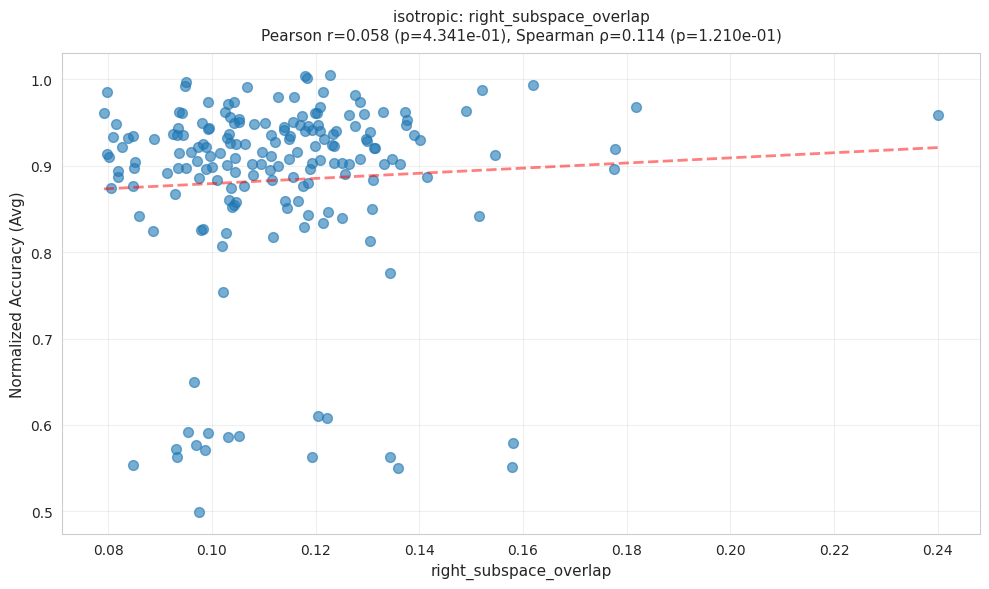


right_subspace_overlap:
  Data points: 185
  Pearson correlation: r=0.0579, p=4.3407e-01
  Spearman correlation: ρ=0.1144, p=1.2096e-01
Saved: isotropic_activation_l2_distance.png


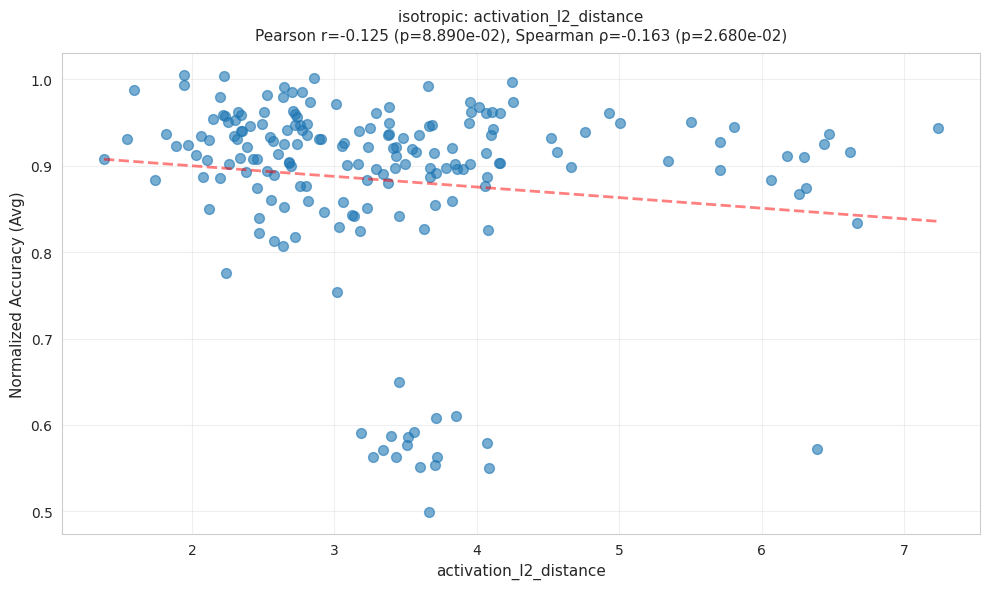


activation_l2_distance:
  Data points: 185
  Pearson correlation: r=-0.1254, p=8.8898e-02
  Spearman correlation: ρ=-0.1628, p=2.6799e-02
Saved: isotropic_activation_cosine_similarity.png


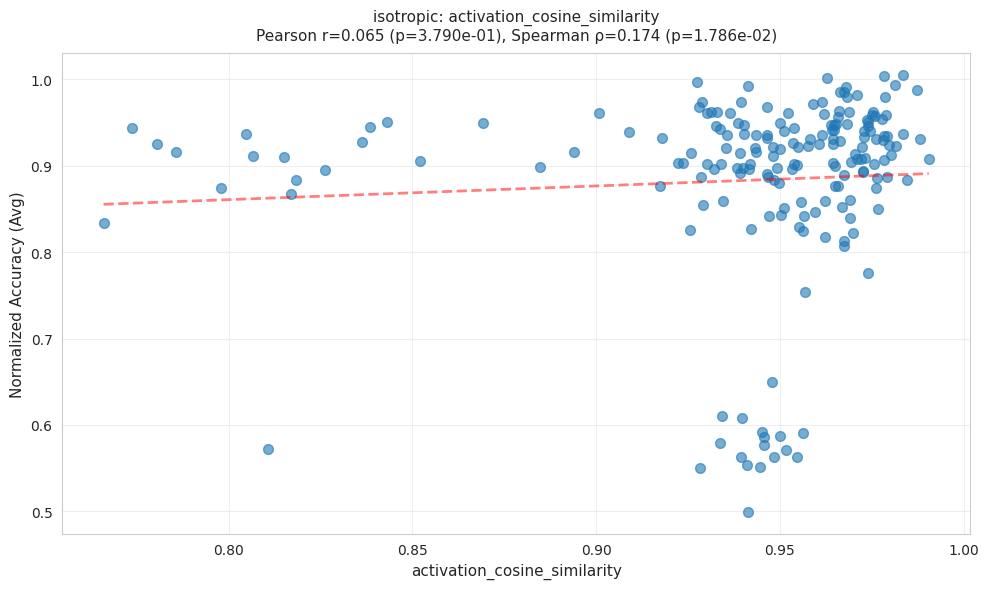


activation_cosine_similarity:
  Data points: 185
  Pearson correlation: r=0.0650, p=3.7904e-01
  Spearman correlation: ρ=0.1740, p=1.7859e-02
Saved: isotropic_activation_magnitude_ratio.png


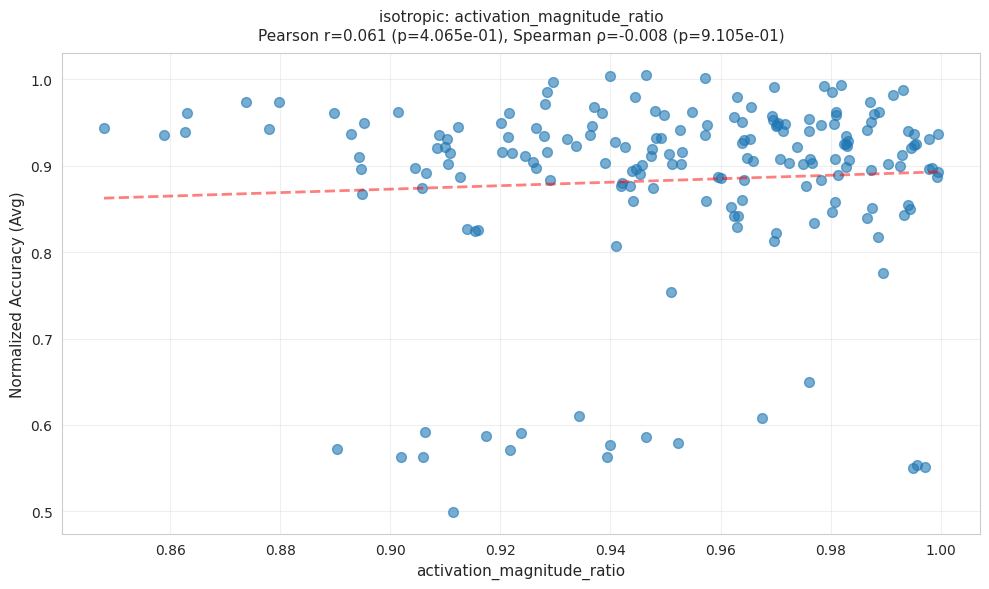


activation_magnitude_ratio:
  Data points: 185
  Pearson correlation: r=0.0614, p=4.0647e-01
  Spearman correlation: ρ=-0.0083, p=9.1048e-01
Saved: isotropic_activation_dot_product.png


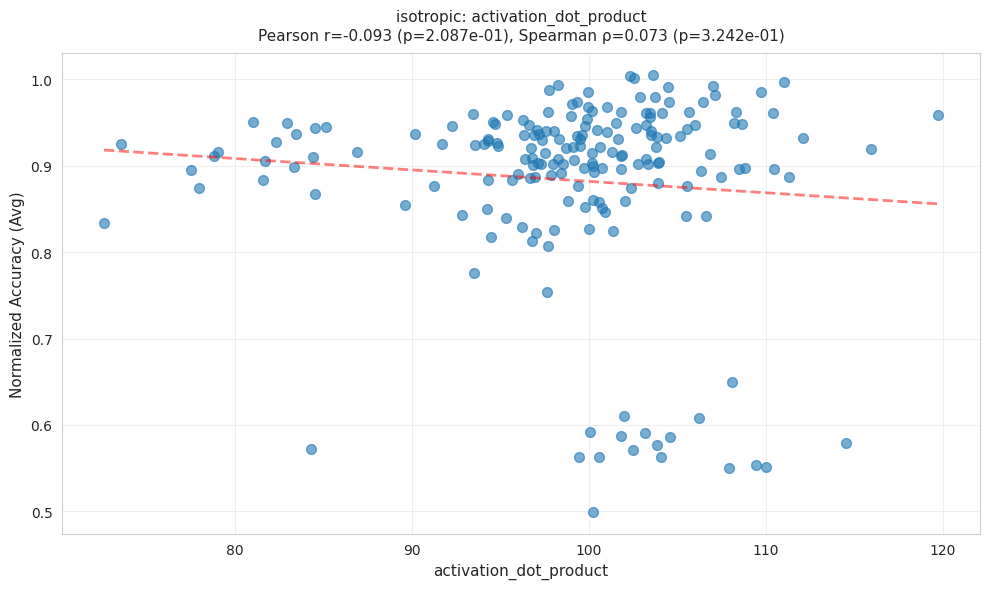


activation_dot_product:
  Data points: 185
  Pearson correlation: r=-0.0929, p=2.0868e-01
  Spearman correlation: ρ=0.0729, p=3.2421e-01

Merger: TSV
Saved: tsv_right_subspace_overlap_top_k.png


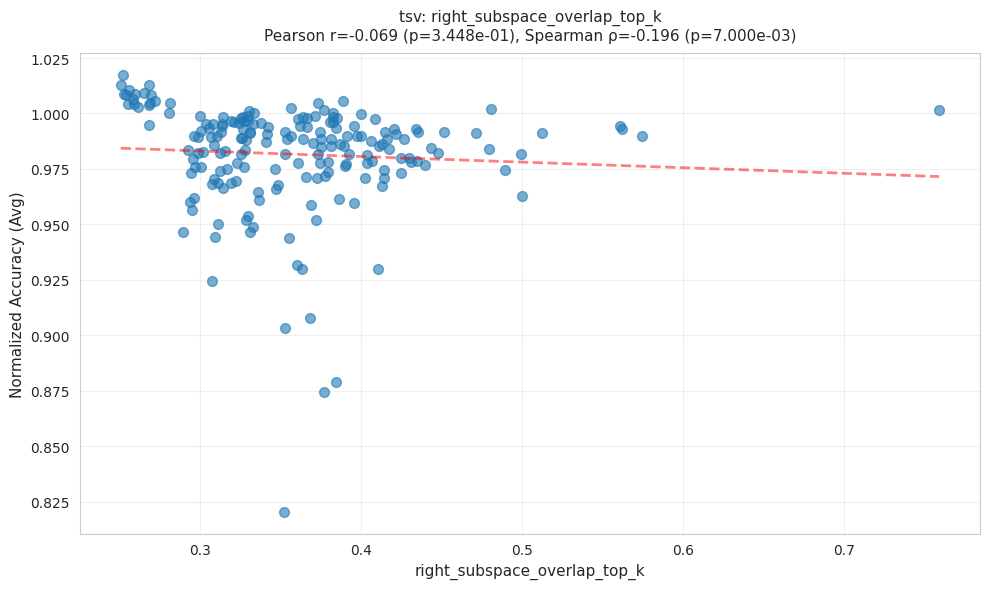


right_subspace_overlap_top_k:
  Data points: 188
  Pearson correlation: r=-0.0693, p=3.4485e-01
  Spearman correlation: ρ=-0.1961, p=7.0001e-03
Saved: tsv_right_subspace_overlap_bottom_k.png


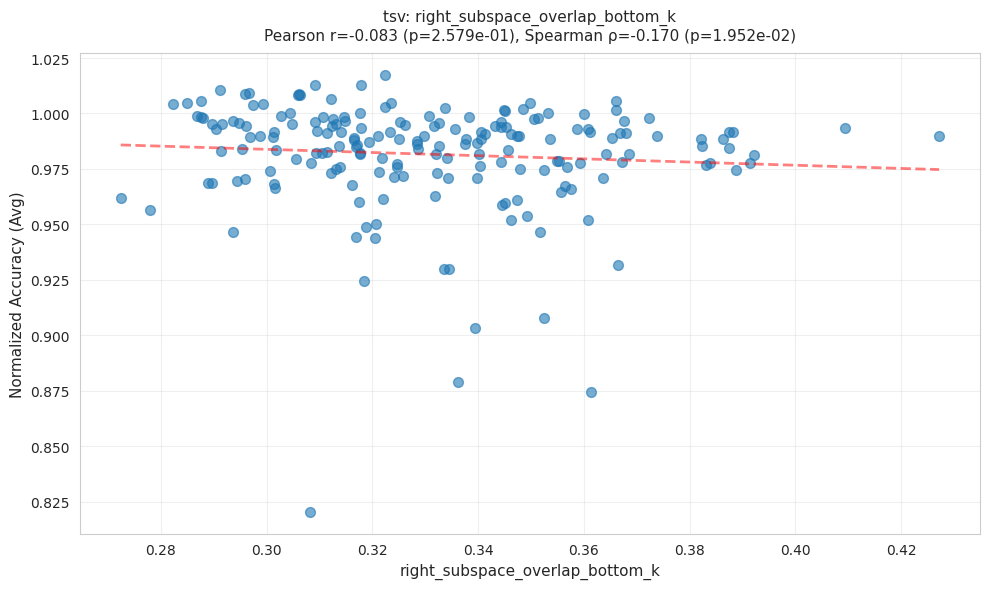


right_subspace_overlap_bottom_k:
  Data points: 188
  Pearson correlation: r=-0.0829, p=2.5790e-01
  Spearman correlation: ρ=-0.1702, p=1.9519e-02
Saved: tsv_interaction_matrix_overlap_top_k.png


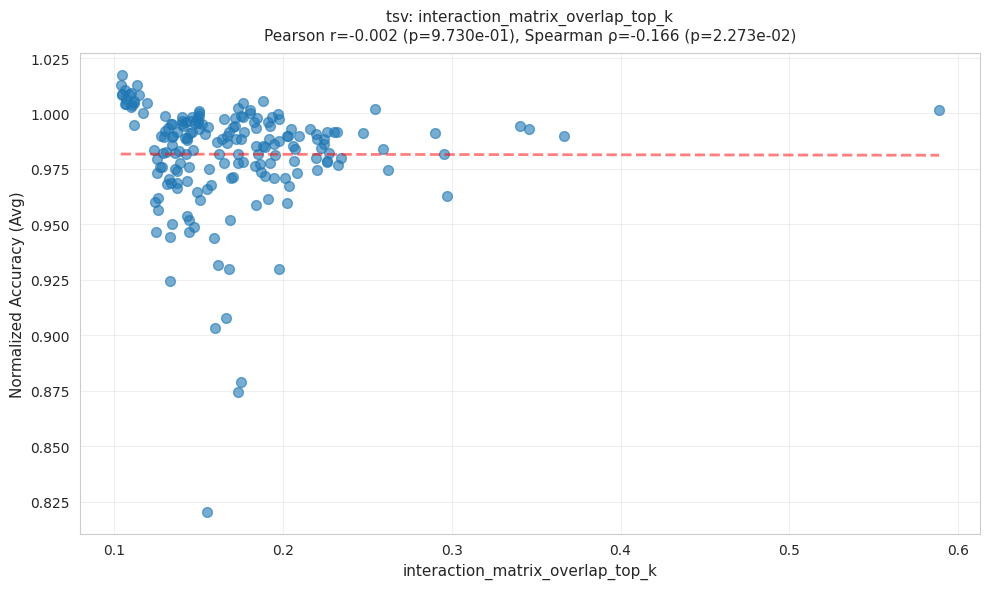


interaction_matrix_overlap_top_k:
  Data points: 188
  Pearson correlation: r=-0.0025, p=9.7297e-01
  Spearman correlation: ρ=-0.1661, p=2.2731e-02
Saved: tsv_interaction_matrix_overlap_bottom_k.png


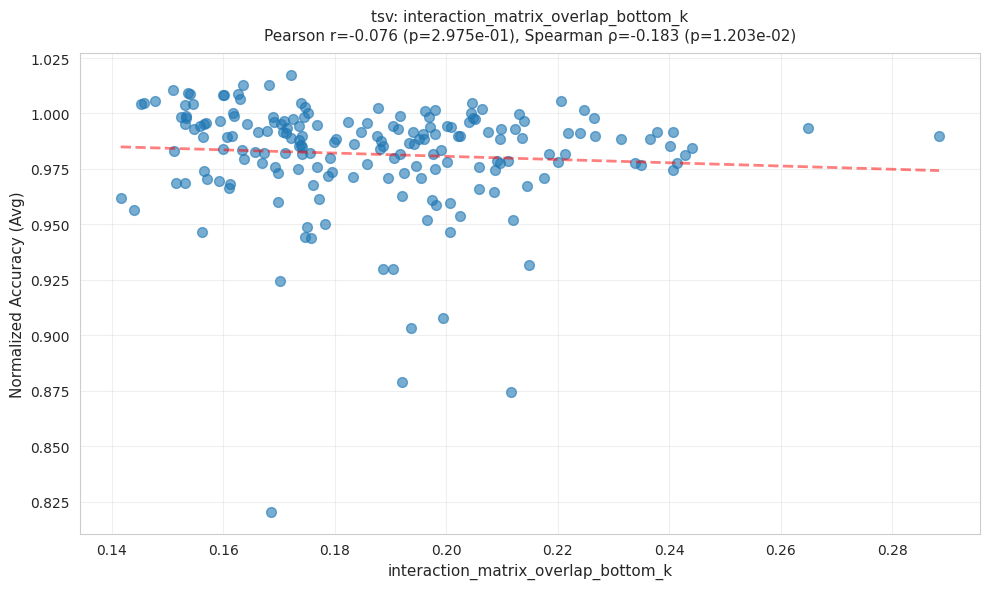


interaction_matrix_overlap_bottom_k:
  Data points: 188
  Pearson correlation: r=-0.0764, p=2.9755e-01
  Spearman correlation: ρ=-0.1828, p=1.2035e-02
Saved: tsv_effective_rank.png


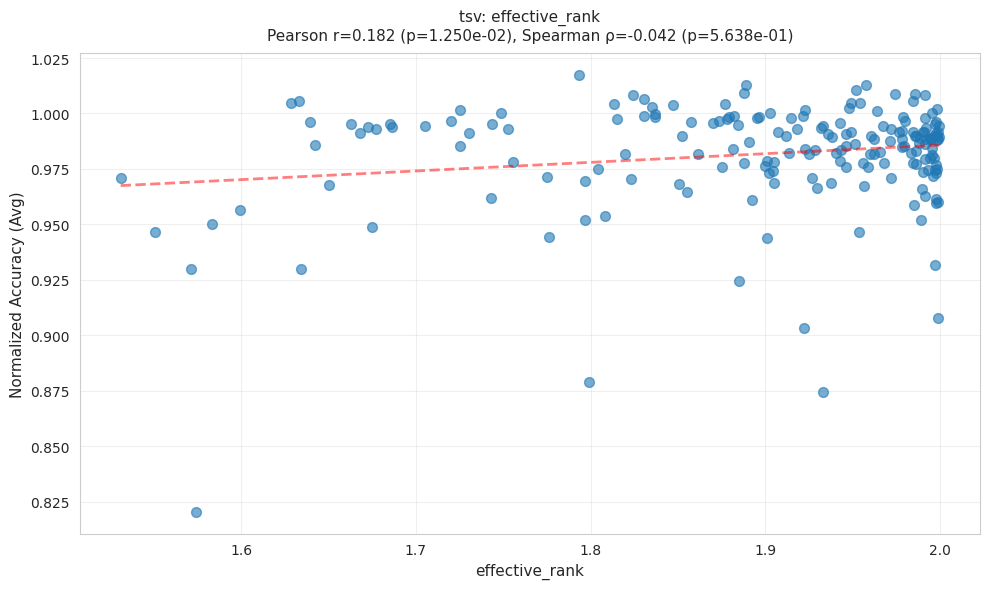


effective_rank:
  Data points: 188
  Pearson correlation: r=0.1819, p=1.2497e-02
  Spearman correlation: ρ=-0.0424, p=5.6384e-01
Saved: tsv_effective_rank_mergeability_score.png


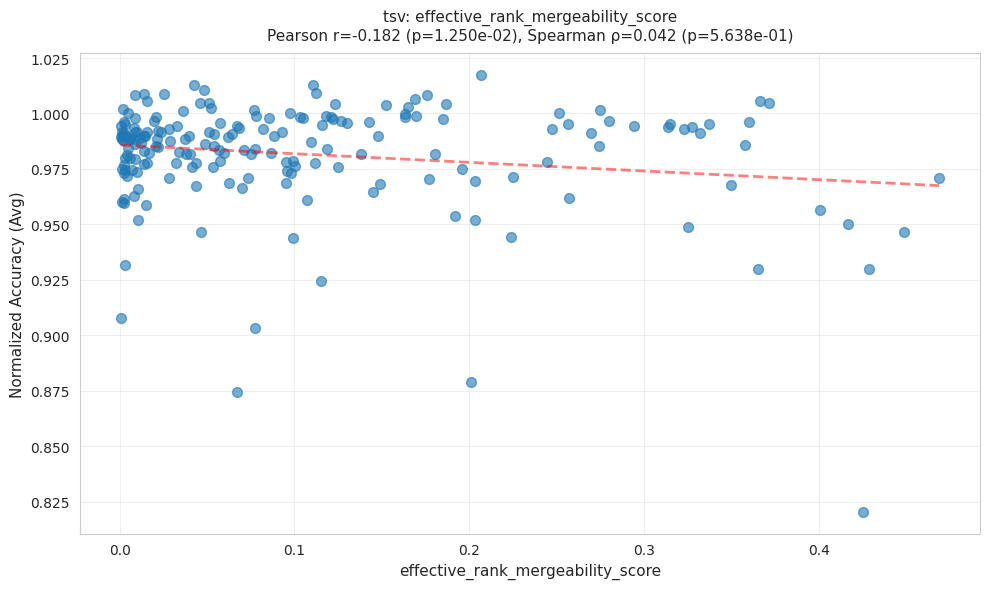


effective_rank_mergeability_score:
  Data points: 188
  Pearson correlation: r=-0.1819, p=1.2497e-02
  Spearman correlation: ρ=0.0424, p=5.6384e-01
Saved: tsv_stable_rank.png


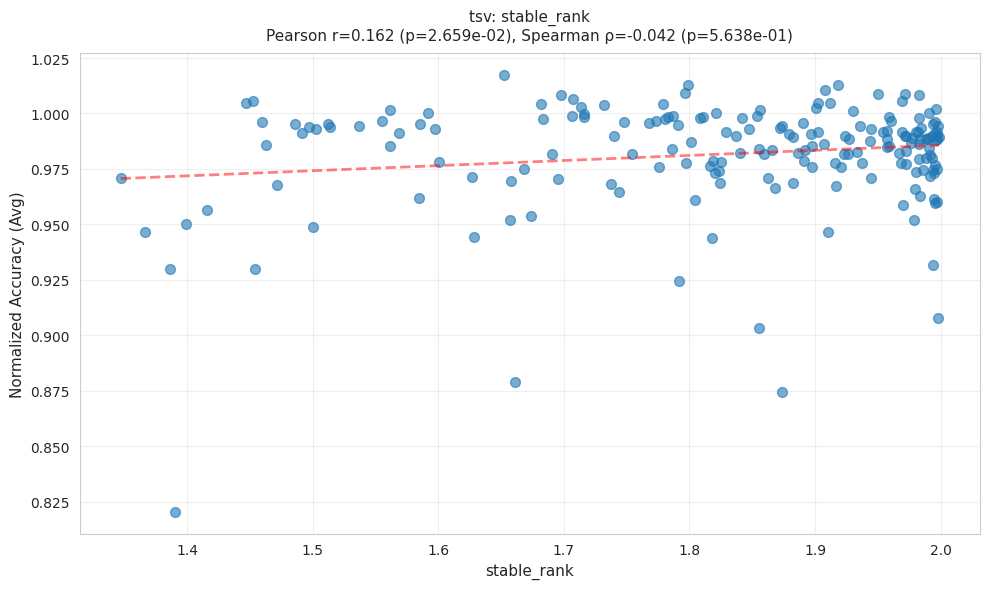


stable_rank:
  Data points: 188
  Pearson correlation: r=0.1617, p=2.6591e-02
  Spearman correlation: ρ=-0.0424, p=5.6384e-01
Saved: tsv_spectral_gap.png


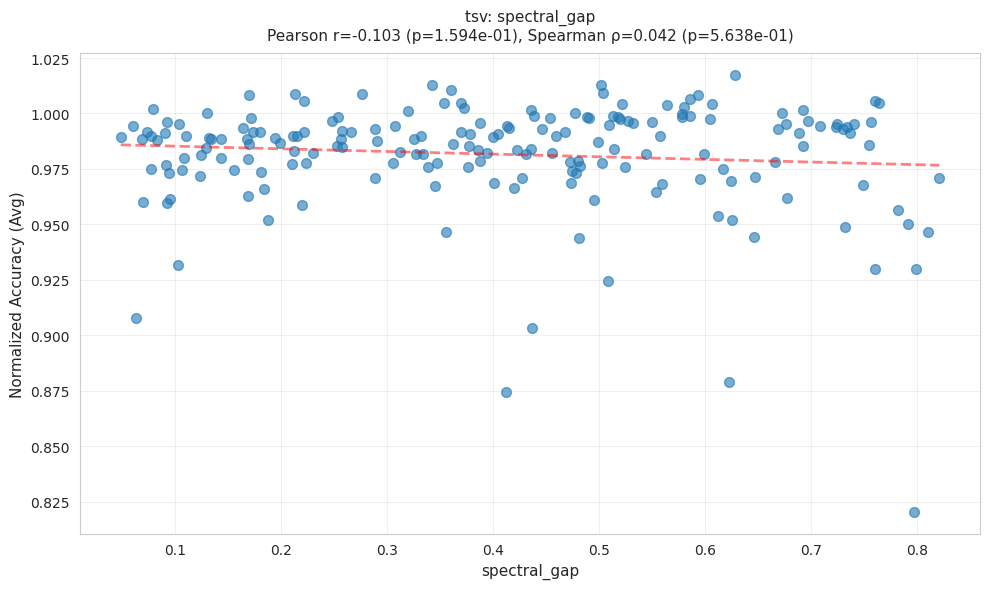


spectral_gap:
  Data points: 188
  Pearson correlation: r=-0.1030, p=1.5942e-01
  Spearman correlation: ρ=0.0424, p=5.6384e-01
Saved: tsv_singular_value_ratio.png


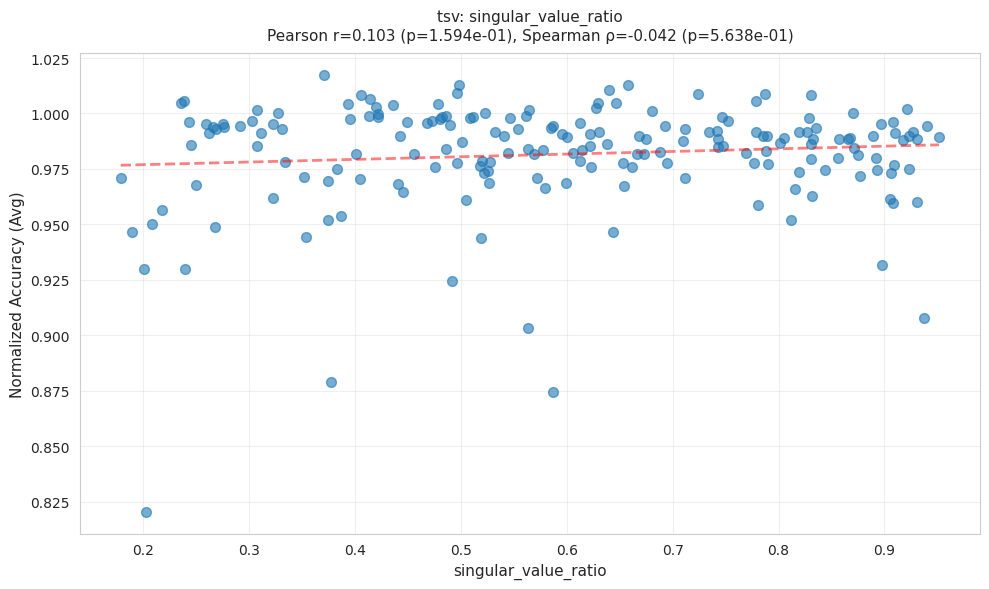


singular_value_ratio:
  Data points: 188
  Pearson correlation: r=0.1030, p=1.5942e-01
  Spearman correlation: ρ=-0.0424, p=5.6384e-01
Saved: tsv_layerwise_effective_rank.png


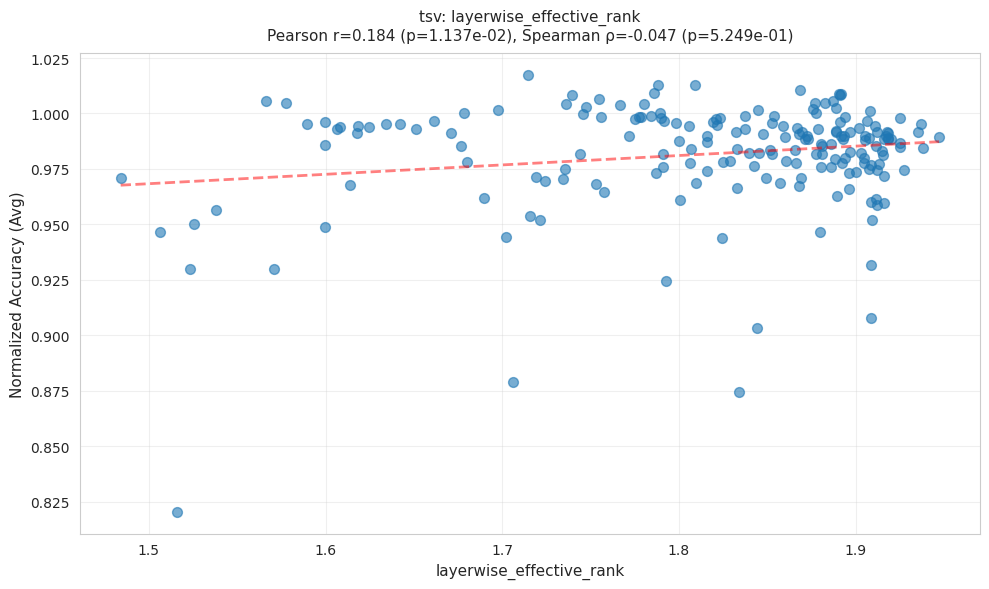


layerwise_effective_rank:
  Data points: 188
  Pearson correlation: r=0.1842, p=1.1369e-02
  Spearman correlation: ρ=-0.0467, p=5.2491e-01
Saved: tsv_layerwise_effective_rank_mergeability_score.png


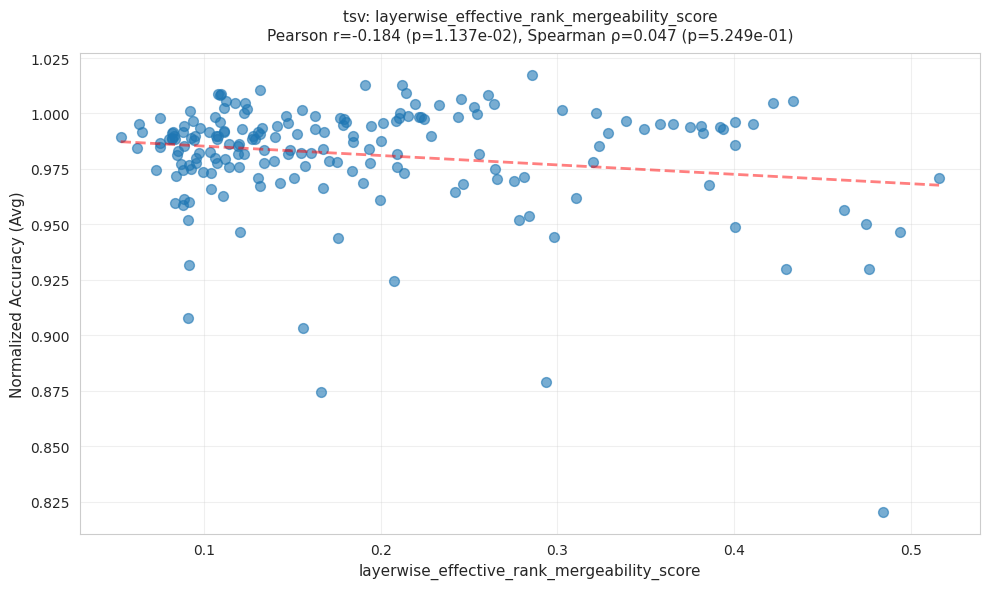


layerwise_effective_rank_mergeability_score:
  Data points: 188
  Pearson correlation: r=-0.1842, p=1.1369e-02
  Spearman correlation: ρ=0.0467, p=5.2491e-01
Saved: tsv_task_vector_cosine_similarity.png


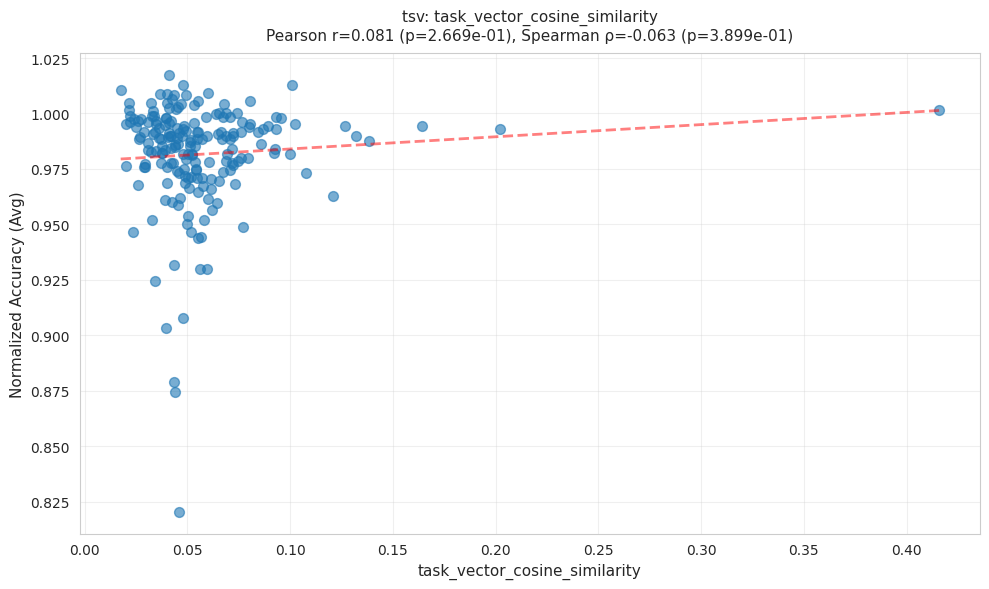


task_vector_cosine_similarity:
  Data points: 188
  Pearson correlation: r=0.0814, p=2.6692e-01
  Spearman correlation: ρ=-0.0631, p=3.8985e-01
Saved: tsv_task_vector_l2_distance.png


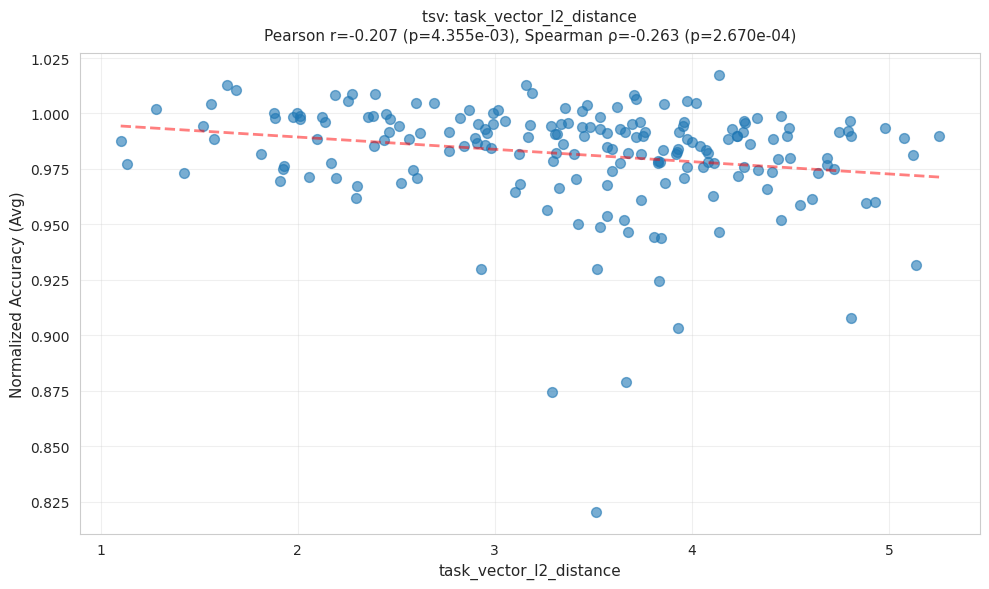


task_vector_l2_distance:
  Data points: 188
  Pearson correlation: r=-0.2071, p=4.3547e-03
  Spearman correlation: ρ=-0.2629, p=2.6703e-04
Saved: tsv_task_vector_dot_product.png


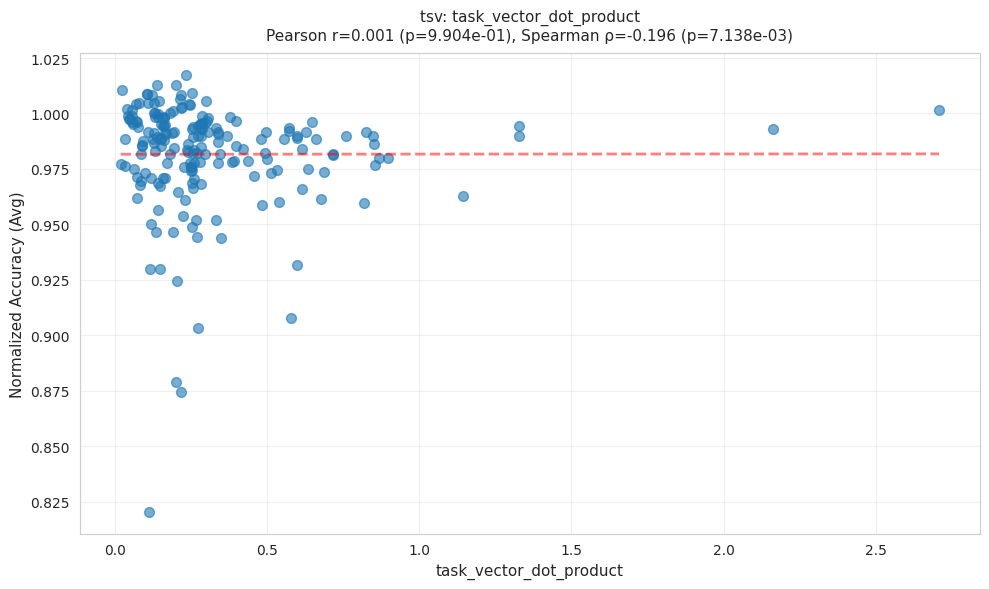


task_vector_dot_product:
  Data points: 188
  Pearson correlation: r=0.0009, p=9.9040e-01
  Spearman correlation: ρ=-0.1956, p=7.1382e-03
Saved: tsv_weight_space_angle.png


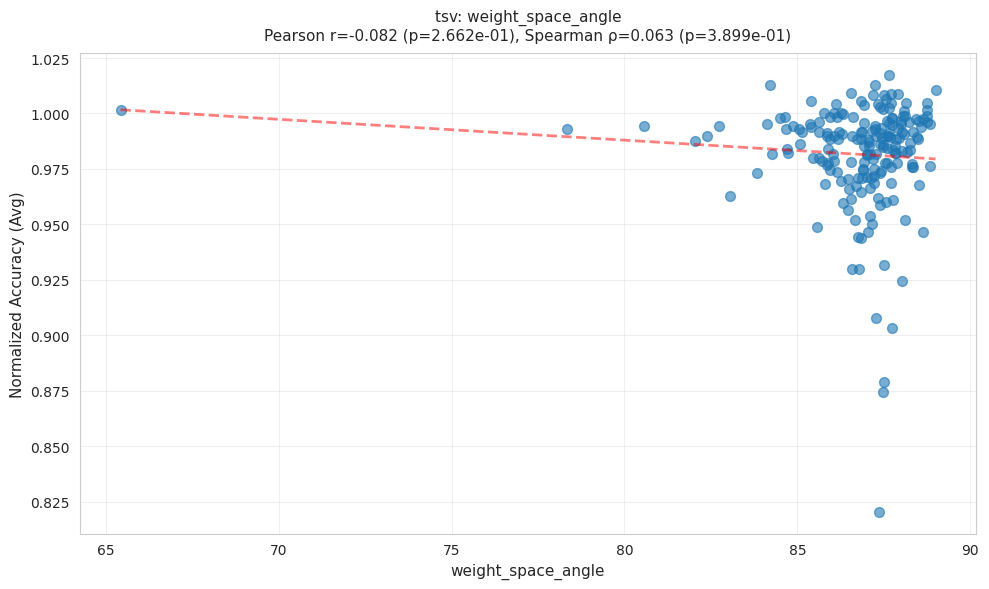


weight_space_angle:
  Data points: 188
  Pearson correlation: r=-0.0815, p=2.6619e-01
  Spearman correlation: ρ=0.0631, p=3.8985e-01
Saved: tsv_task_vector_magnitude_ratio.png


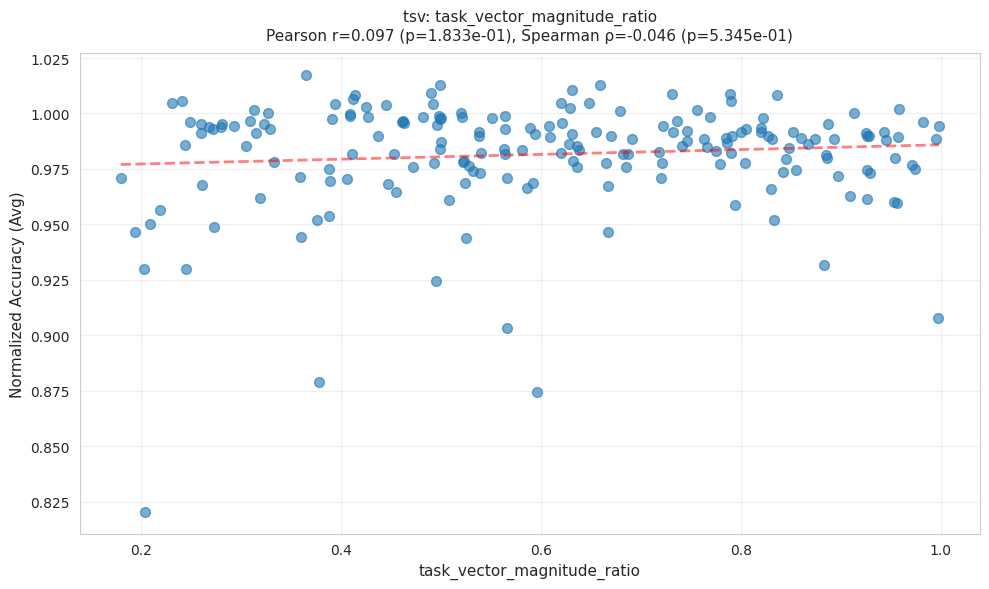


task_vector_magnitude_ratio:
  Data points: 188
  Pearson correlation: r=0.0975, p=1.8328e-01
  Spearman correlation: ρ=-0.0456, p=5.3449e-01
Saved: tsv_singular_value_overlap.png


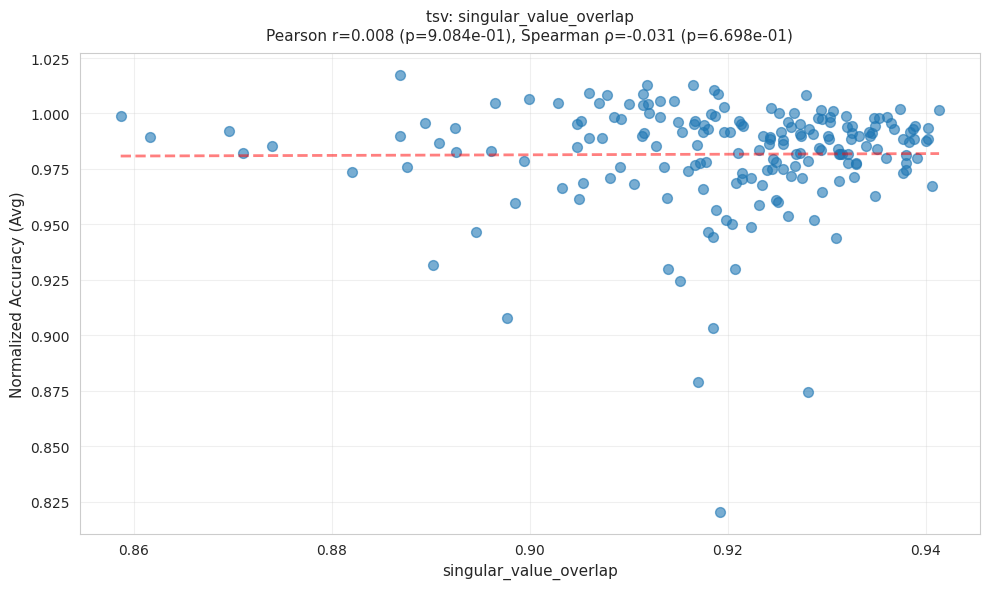


singular_value_overlap:
  Data points: 188
  Pearson correlation: r=0.0085, p=9.0837e-01
  Spearman correlation: ρ=-0.0313, p=6.6980e-01
Saved: tsv_subspace_overlap.png


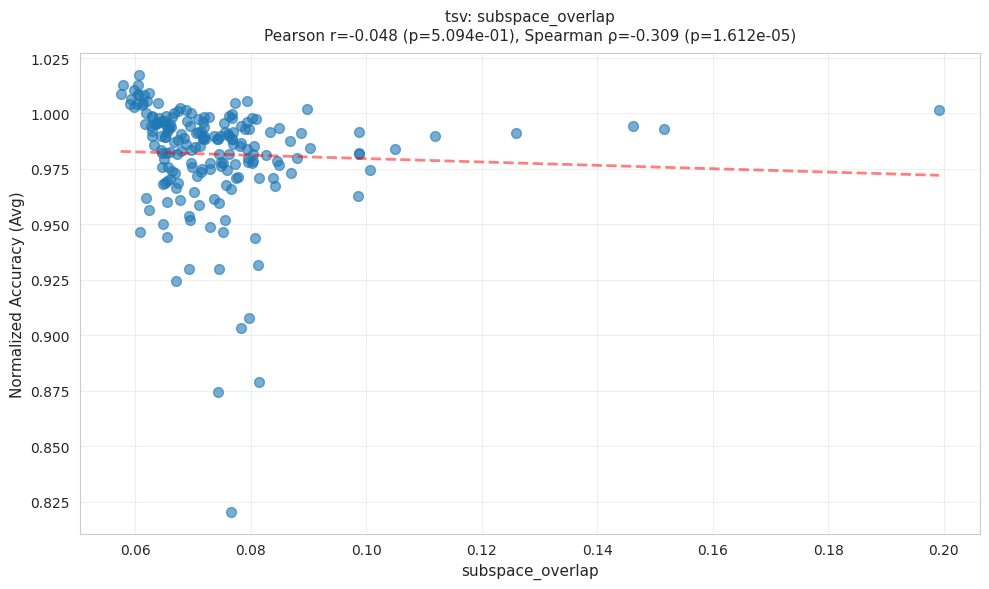


subspace_overlap:
  Data points: 188
  Pearson correlation: r=-0.0484, p=5.0937e-01
  Spearman correlation: ρ=-0.3089, p=1.6124e-05
Saved: tsv_right_subspace_overlap.png


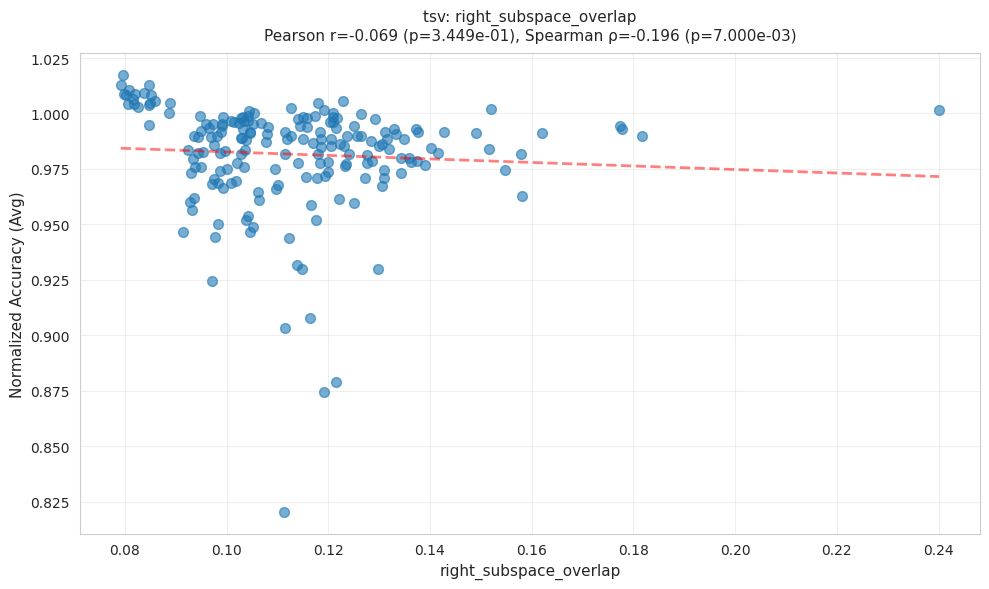


right_subspace_overlap:
  Data points: 188
  Pearson correlation: r=-0.0693, p=3.4485e-01
  Spearman correlation: ρ=-0.1961, p=7.0001e-03
Saved: tsv_activation_l2_distance.png


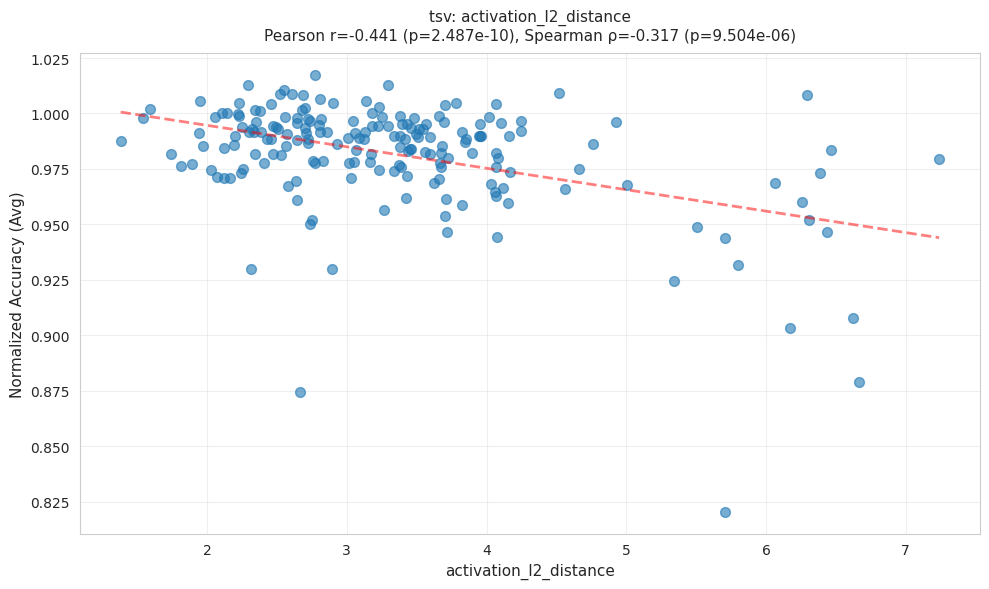


activation_l2_distance:
  Data points: 188
  Pearson correlation: r=-0.4406, p=2.4868e-10
  Spearman correlation: ρ=-0.3167, p=9.5043e-06
Saved: tsv_activation_cosine_similarity.png


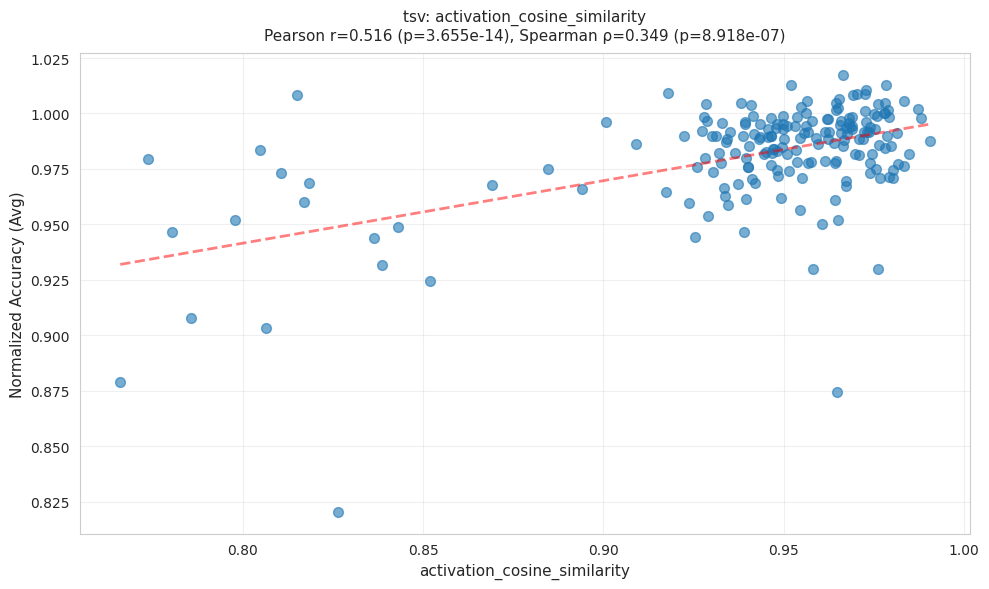


activation_cosine_similarity:
  Data points: 188
  Pearson correlation: r=0.5157, p=3.6551e-14
  Spearman correlation: ρ=0.3494, p=8.9179e-07
Saved: tsv_activation_magnitude_ratio.png


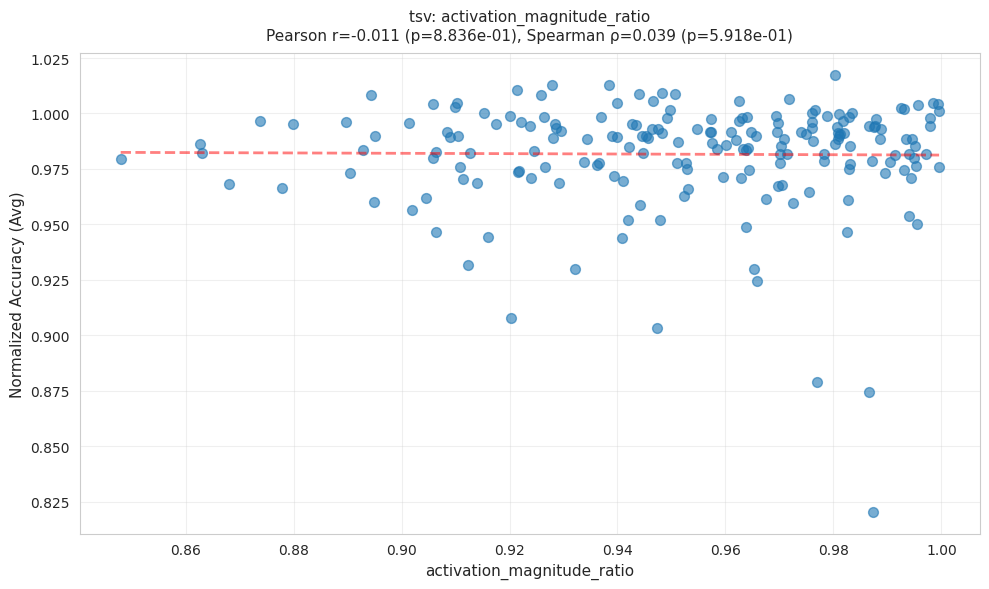


activation_magnitude_ratio:
  Data points: 188
  Pearson correlation: r=-0.0107, p=8.8361e-01
  Spearman correlation: ρ=0.0394, p=5.9181e-01
Saved: tsv_activation_dot_product.png


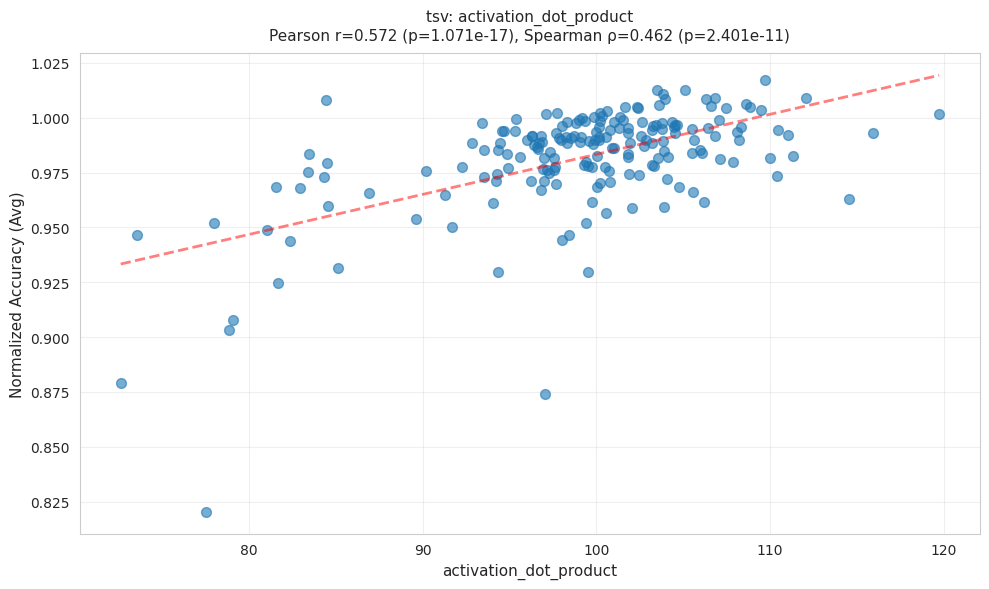


activation_dot_product:
  Data points: 188
  Pearson correlation: r=0.5716, p=1.0709e-17
  Spearman correlation: ρ=0.4623, p=2.4006e-11

Merger: ARITHMETIC
Saved: arithmetic_right_subspace_overlap_top_k.png


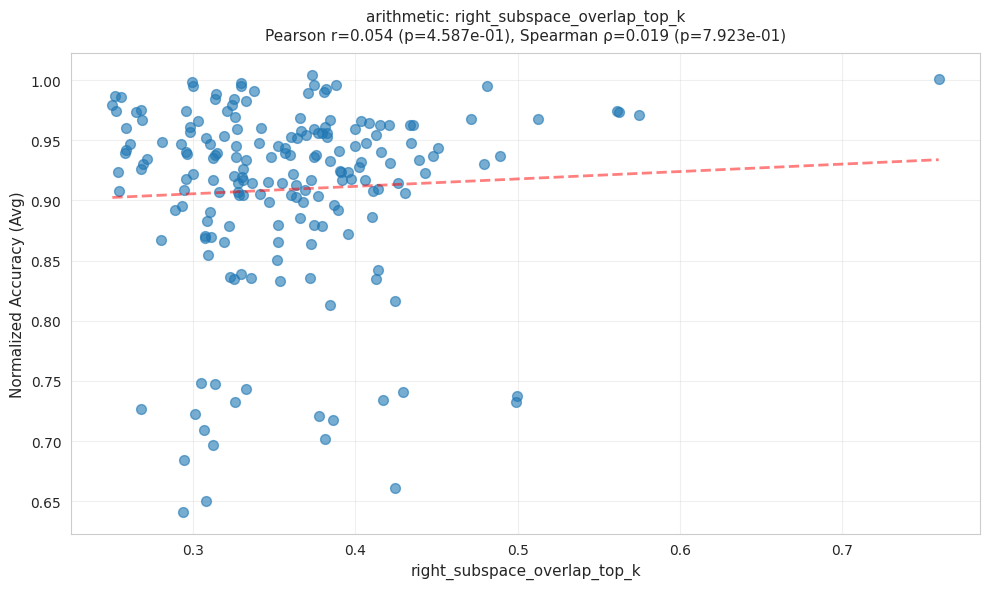


right_subspace_overlap_top_k:
  Data points: 190
  Pearson correlation: r=0.0541, p=4.5866e-01
  Spearman correlation: ρ=0.0192, p=7.9233e-01
Saved: arithmetic_right_subspace_overlap_bottom_k.png


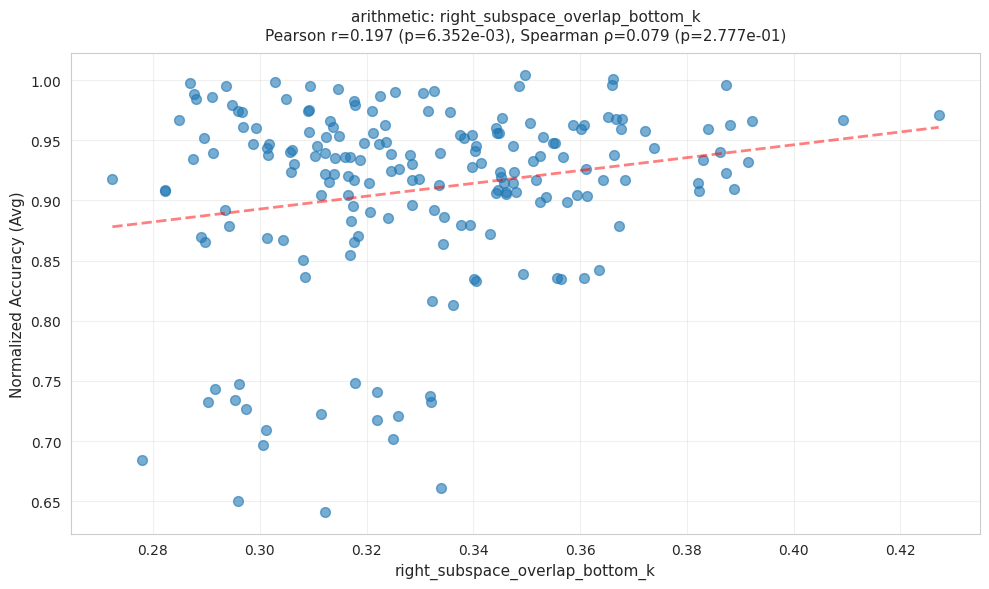


right_subspace_overlap_bottom_k:
  Data points: 190
  Pearson correlation: r=0.1973, p=6.3523e-03
  Spearman correlation: ρ=0.0792, p=2.7766e-01
Saved: arithmetic_interaction_matrix_overlap_top_k.png


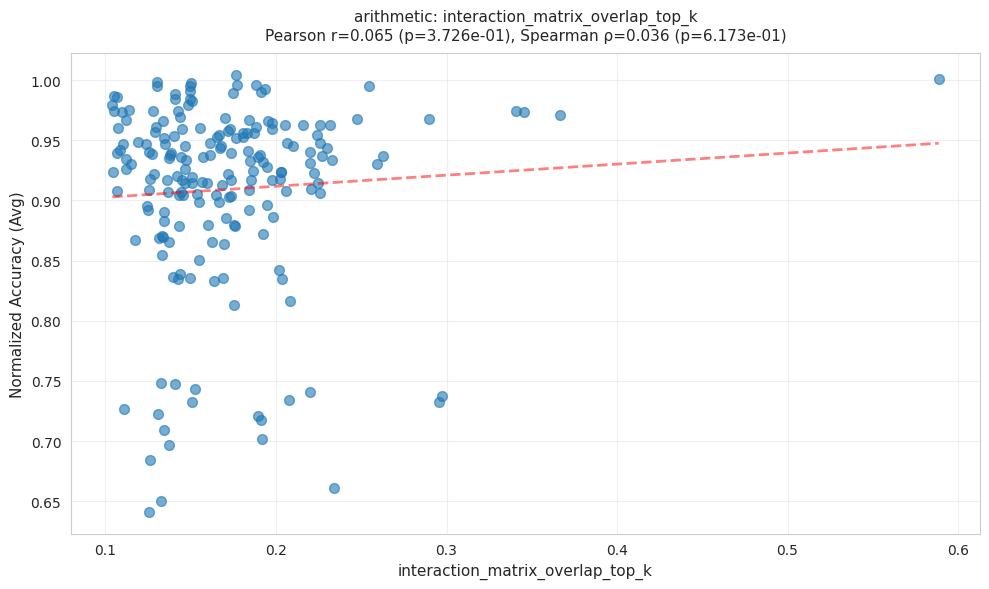


interaction_matrix_overlap_top_k:
  Data points: 190
  Pearson correlation: r=0.0650, p=3.7259e-01
  Spearman correlation: ρ=0.0365, p=6.1734e-01
Saved: arithmetic_interaction_matrix_overlap_bottom_k.png


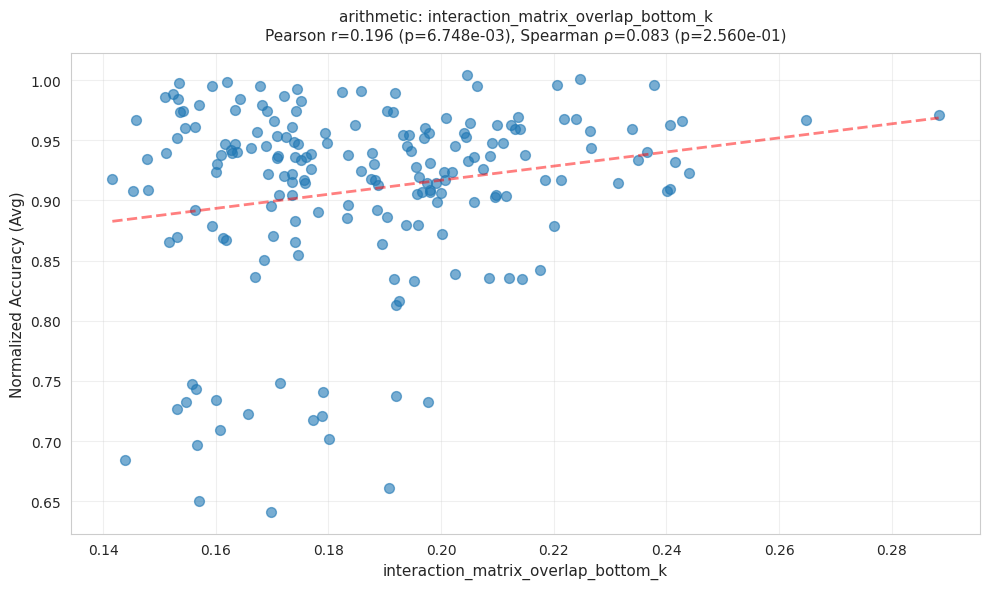


interaction_matrix_overlap_bottom_k:
  Data points: 190
  Pearson correlation: r=0.1959, p=6.7484e-03
  Spearman correlation: ρ=0.0828, p=2.5599e-01
Saved: arithmetic_effective_rank.png


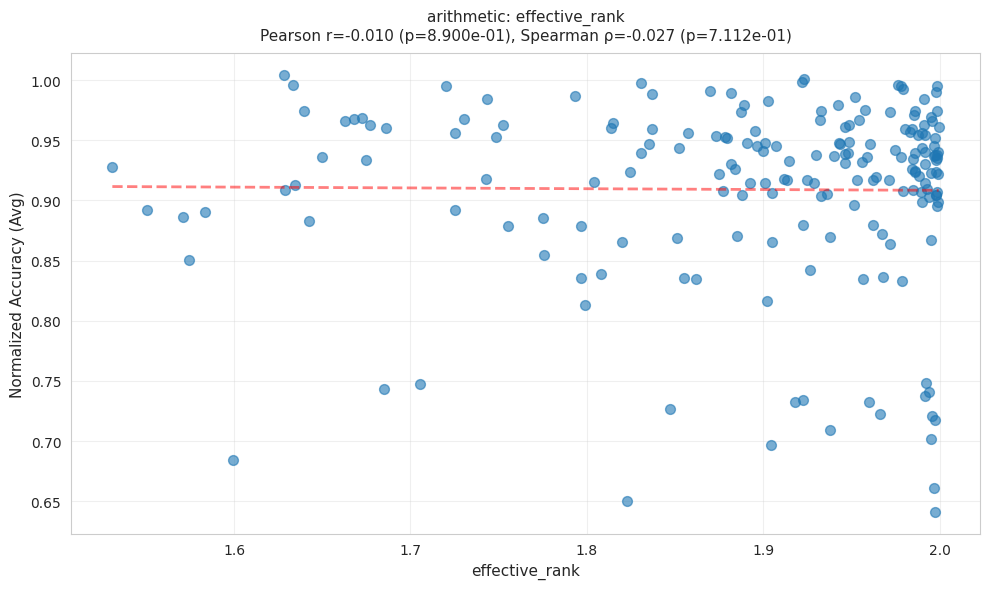


effective_rank:
  Data points: 190
  Pearson correlation: r=-0.0101, p=8.8996e-01
  Spearman correlation: ρ=-0.0270, p=7.1122e-01
Saved: arithmetic_effective_rank_mergeability_score.png


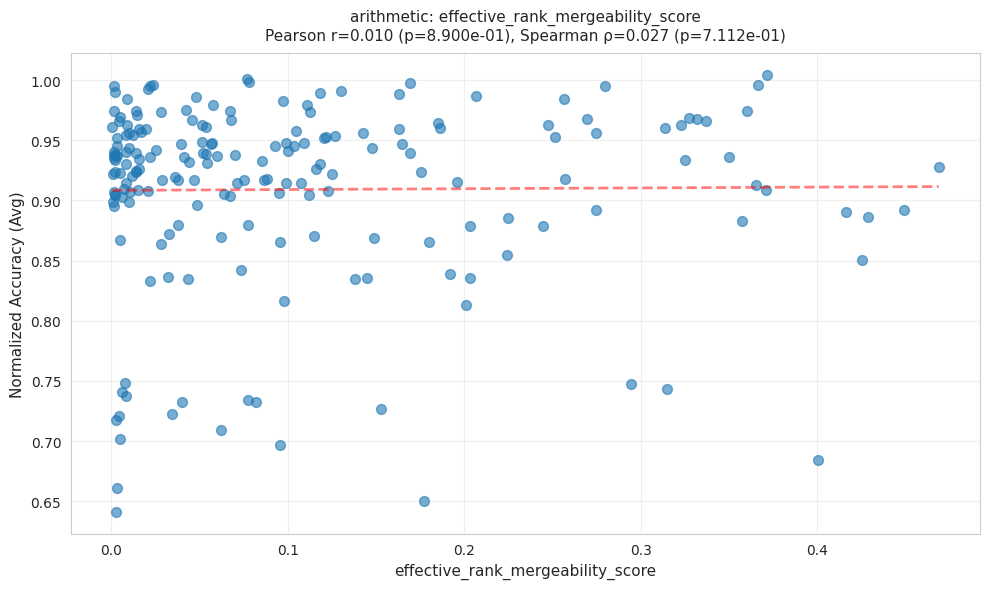


effective_rank_mergeability_score:
  Data points: 190
  Pearson correlation: r=0.0101, p=8.8996e-01
  Spearman correlation: ρ=0.0270, p=7.1122e-01
Saved: arithmetic_stable_rank.png


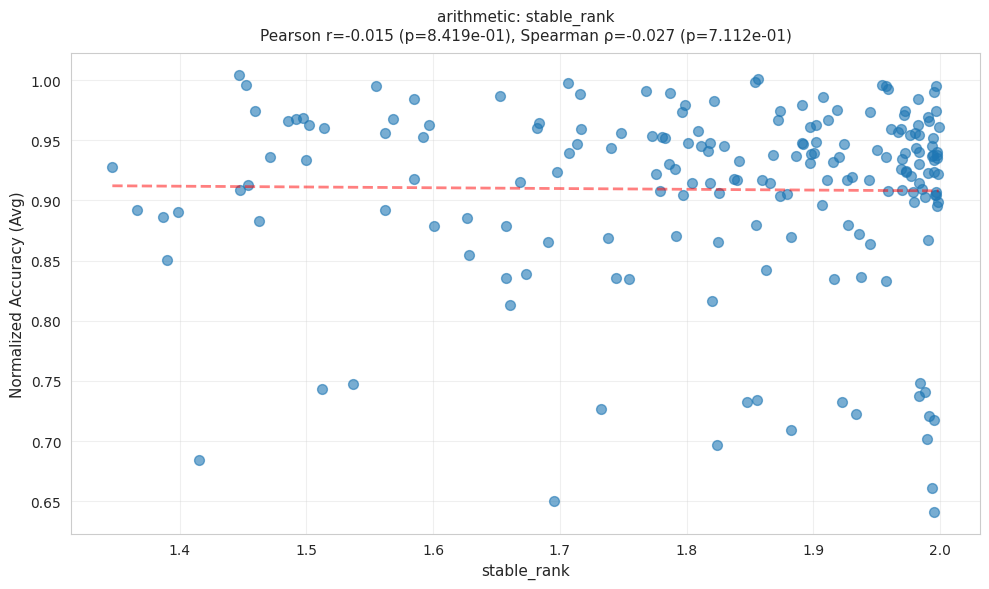


stable_rank:
  Data points: 190
  Pearson correlation: r=-0.0146, p=8.4186e-01
  Spearman correlation: ρ=-0.0270, p=7.1122e-01
Saved: arithmetic_spectral_gap.png


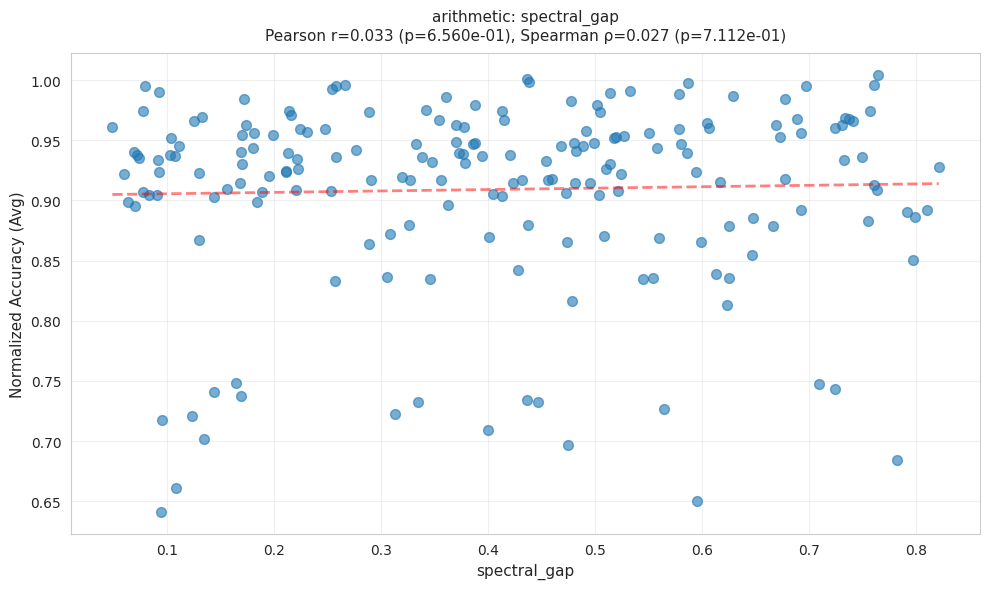


spectral_gap:
  Data points: 190
  Pearson correlation: r=0.0325, p=6.5603e-01
  Spearman correlation: ρ=0.0270, p=7.1122e-01
Saved: arithmetic_singular_value_ratio.png


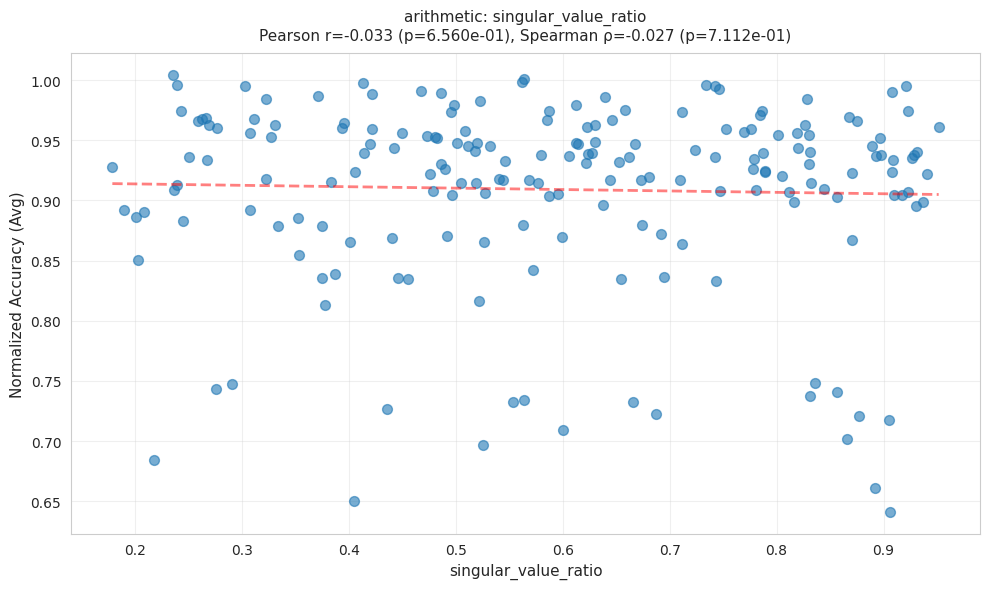


singular_value_ratio:
  Data points: 190
  Pearson correlation: r=-0.0325, p=6.5603e-01
  Spearman correlation: ρ=-0.0270, p=7.1122e-01
Saved: arithmetic_layerwise_effective_rank.png


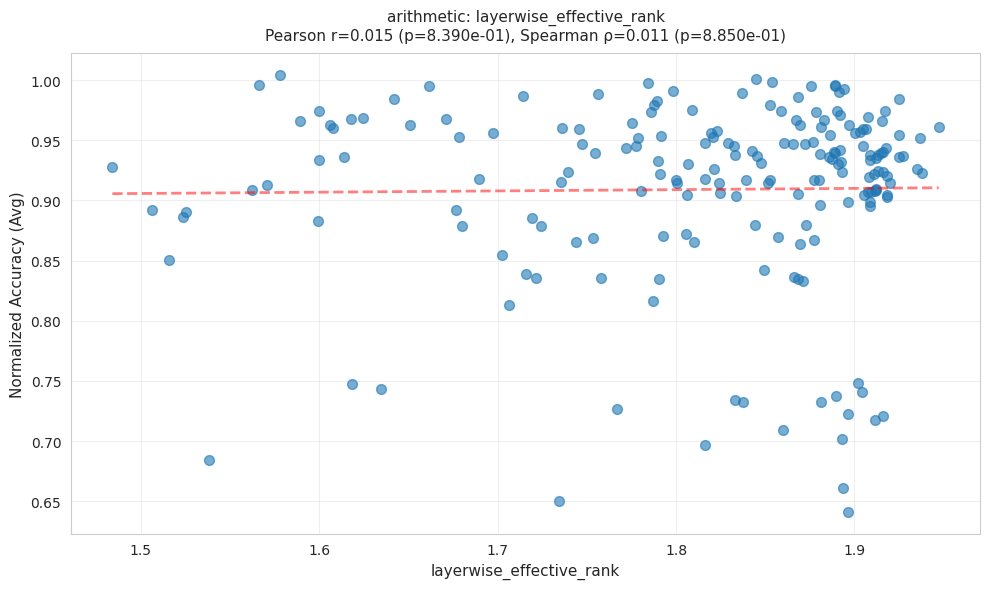


layerwise_effective_rank:
  Data points: 190
  Pearson correlation: r=0.0148, p=8.3898e-01
  Spearman correlation: ρ=0.0106, p=8.8499e-01
Saved: arithmetic_layerwise_effective_rank_mergeability_score.png


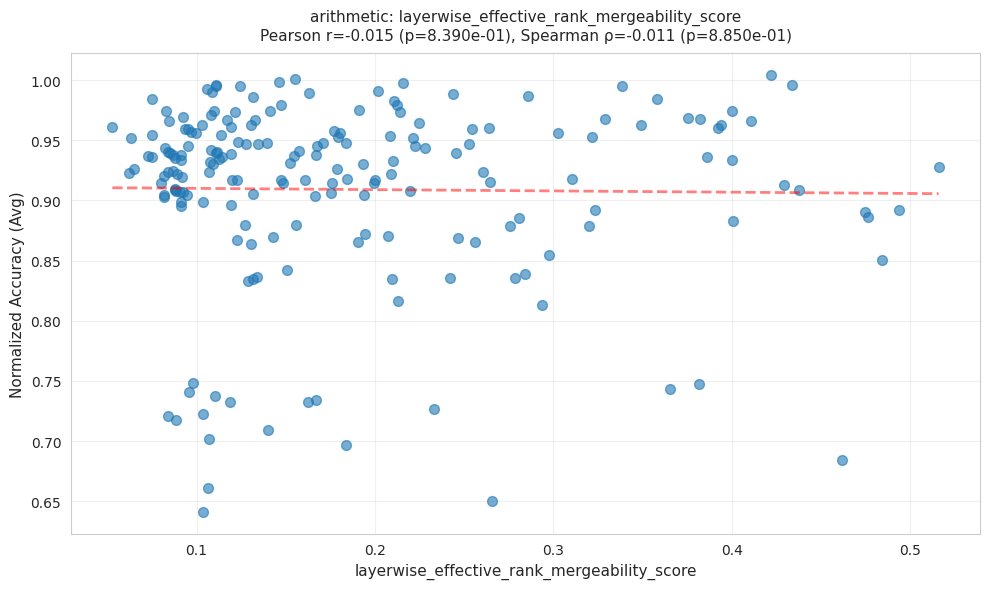


layerwise_effective_rank_mergeability_score:
  Data points: 190
  Pearson correlation: r=-0.0148, p=8.3898e-01
  Spearman correlation: ρ=-0.0106, p=8.8499e-01
Saved: arithmetic_task_vector_cosine_similarity.png


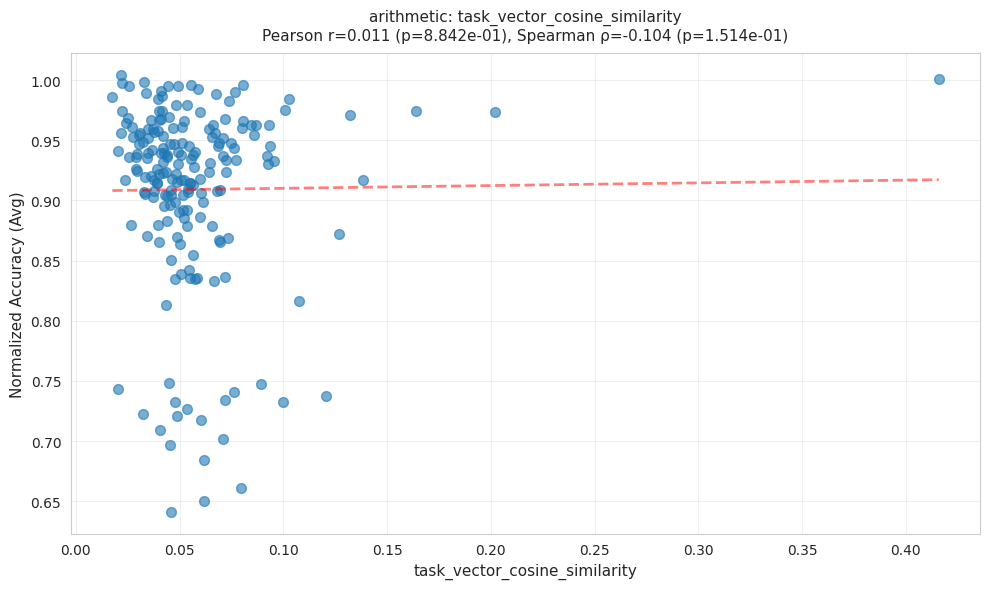


task_vector_cosine_similarity:
  Data points: 190
  Pearson correlation: r=0.0106, p=8.8419e-01
  Spearman correlation: ρ=-0.1045, p=1.5137e-01
Saved: arithmetic_task_vector_l2_distance.png


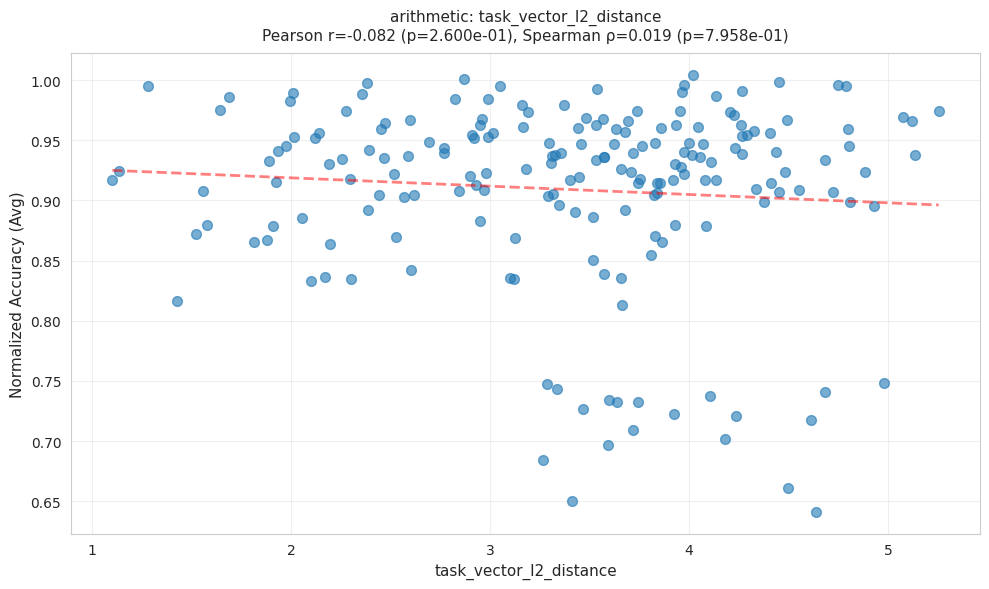


task_vector_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.0821, p=2.6002e-01
  Spearman correlation: ρ=0.0189, p=7.9580e-01
Saved: arithmetic_task_vector_dot_product.png


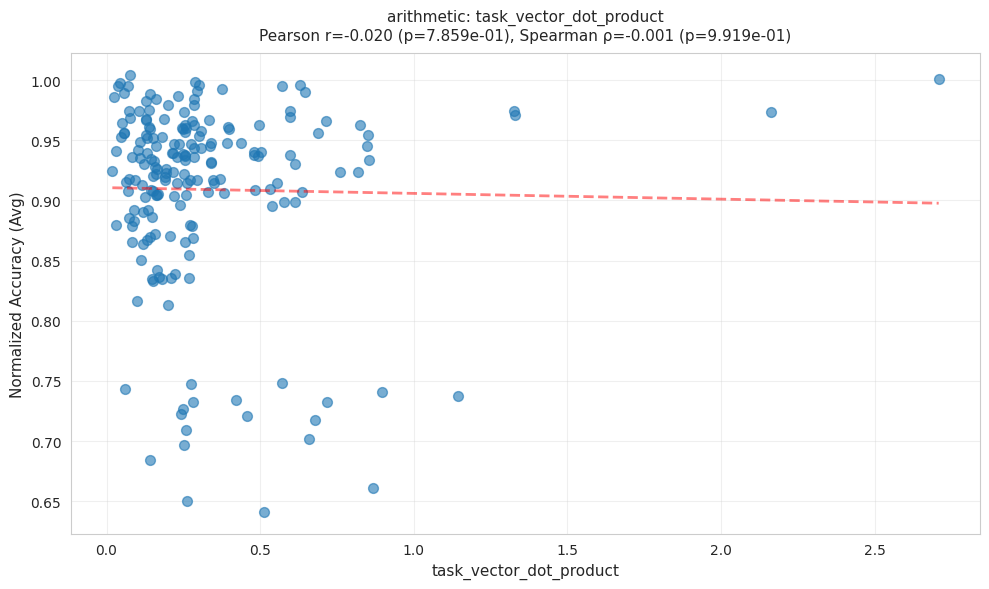


task_vector_dot_product:
  Data points: 190
  Pearson correlation: r=-0.0198, p=7.8586e-01
  Spearman correlation: ρ=-0.0007, p=9.9190e-01
Saved: arithmetic_weight_space_angle.png


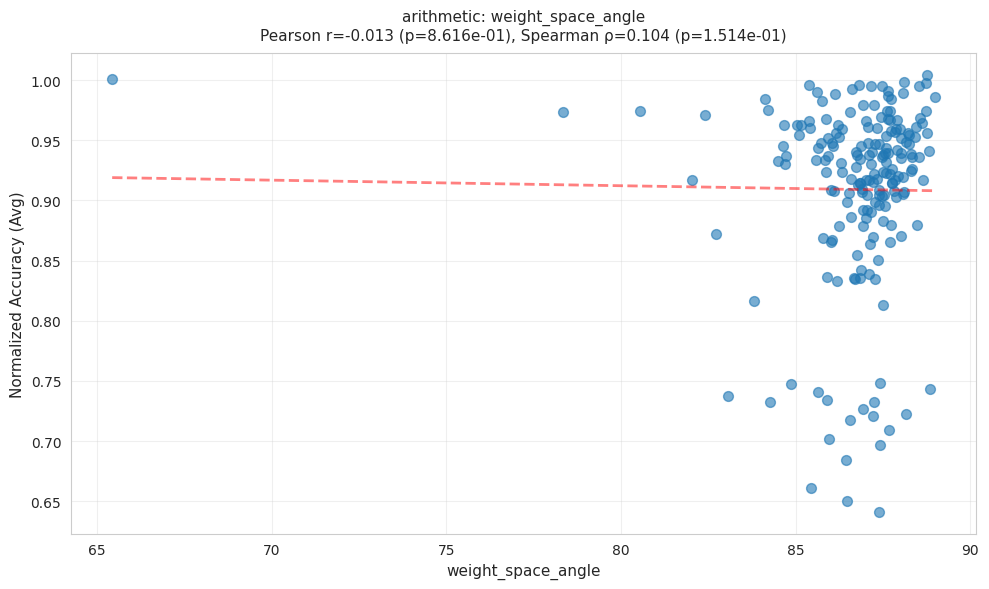


weight_space_angle:
  Data points: 190
  Pearson correlation: r=-0.0127, p=8.6163e-01
  Spearman correlation: ρ=0.1045, p=1.5137e-01
Saved: arithmetic_task_vector_magnitude_ratio.png


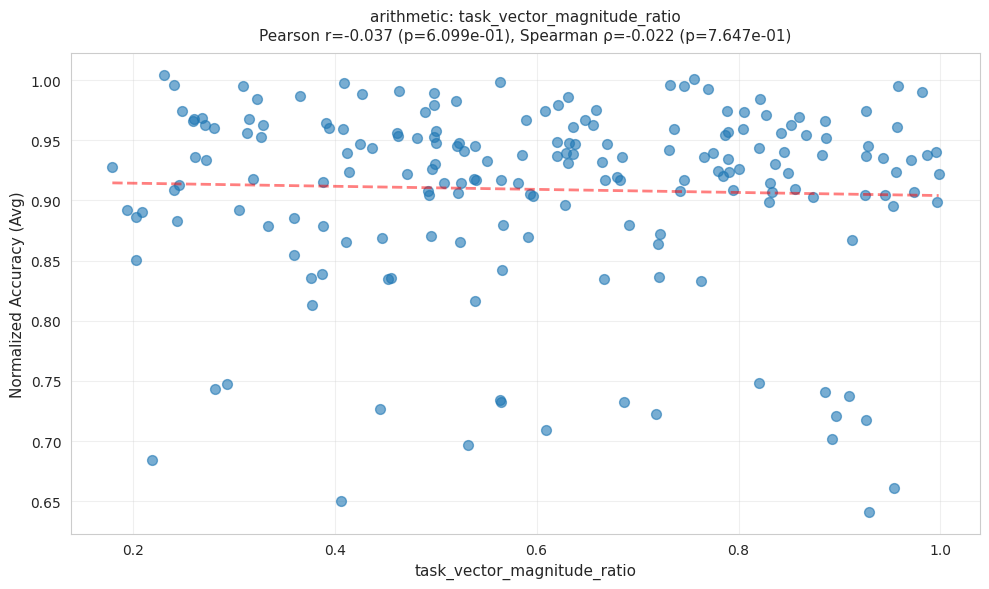


task_vector_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=-0.0372, p=6.0993e-01
  Spearman correlation: ρ=-0.0219, p=7.6470e-01
Saved: arithmetic_singular_value_overlap.png


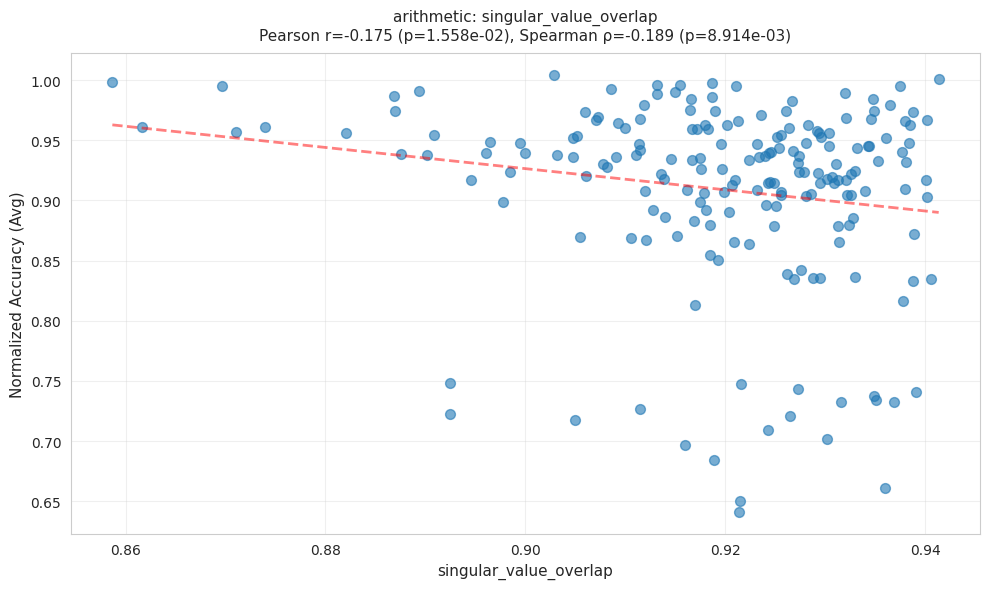


singular_value_overlap:
  Data points: 190
  Pearson correlation: r=-0.1753, p=1.5585e-02
  Spearman correlation: ρ=-0.1893, p=8.9138e-03
Saved: arithmetic_subspace_overlap.png


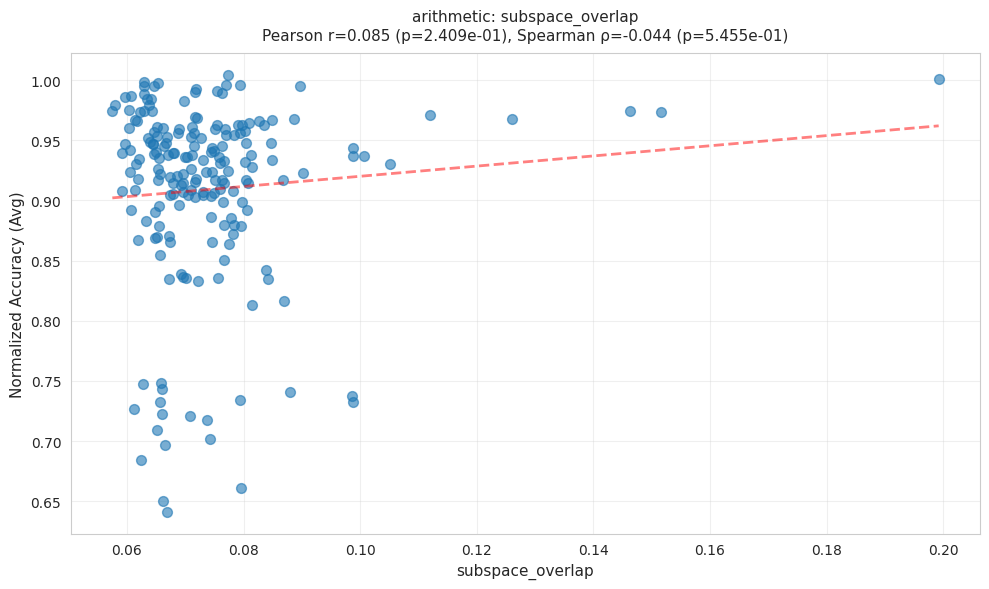


subspace_overlap:
  Data points: 190
  Pearson correlation: r=0.0855, p=2.4094e-01
  Spearman correlation: ρ=-0.0441, p=5.4547e-01
Saved: arithmetic_right_subspace_overlap.png


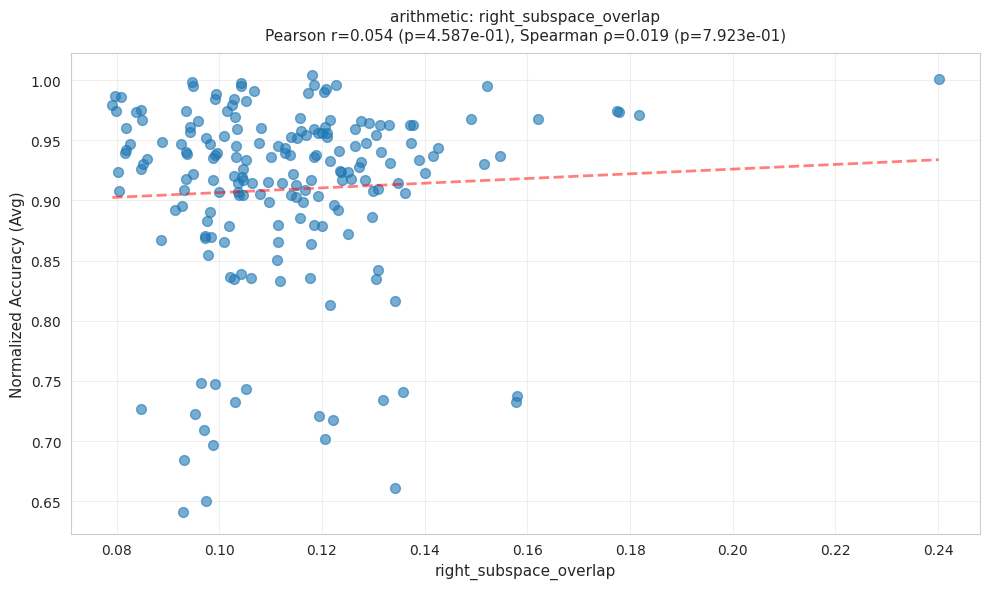


right_subspace_overlap:
  Data points: 190
  Pearson correlation: r=0.0541, p=4.5866e-01
  Spearman correlation: ρ=0.0192, p=7.9233e-01
Saved: arithmetic_activation_l2_distance.png


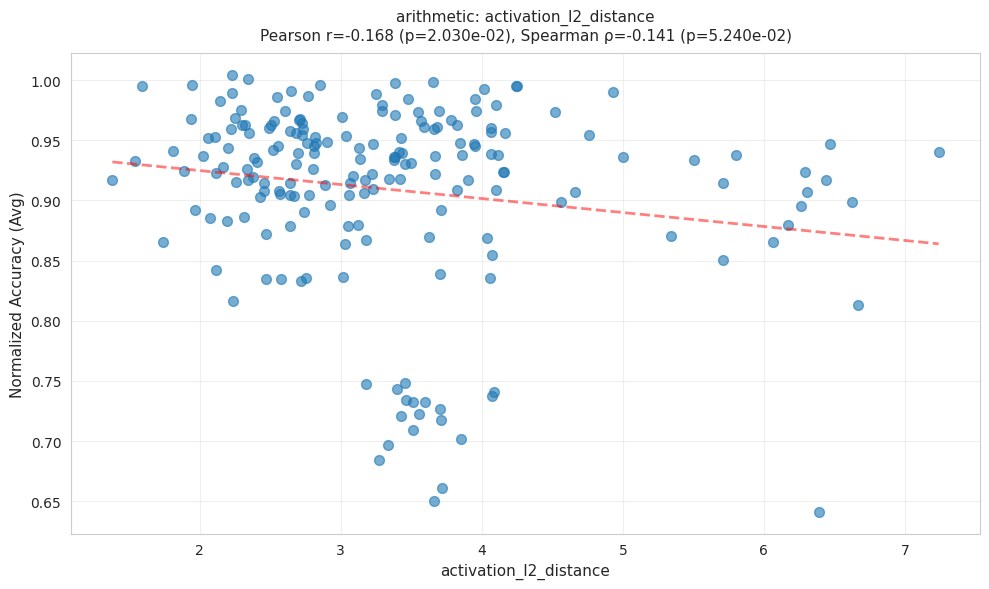


activation_l2_distance:
  Data points: 190
  Pearson correlation: r=-0.1683, p=2.0302e-02
  Spearman correlation: ρ=-0.1410, p=5.2402e-02
Saved: arithmetic_activation_cosine_similarity.png


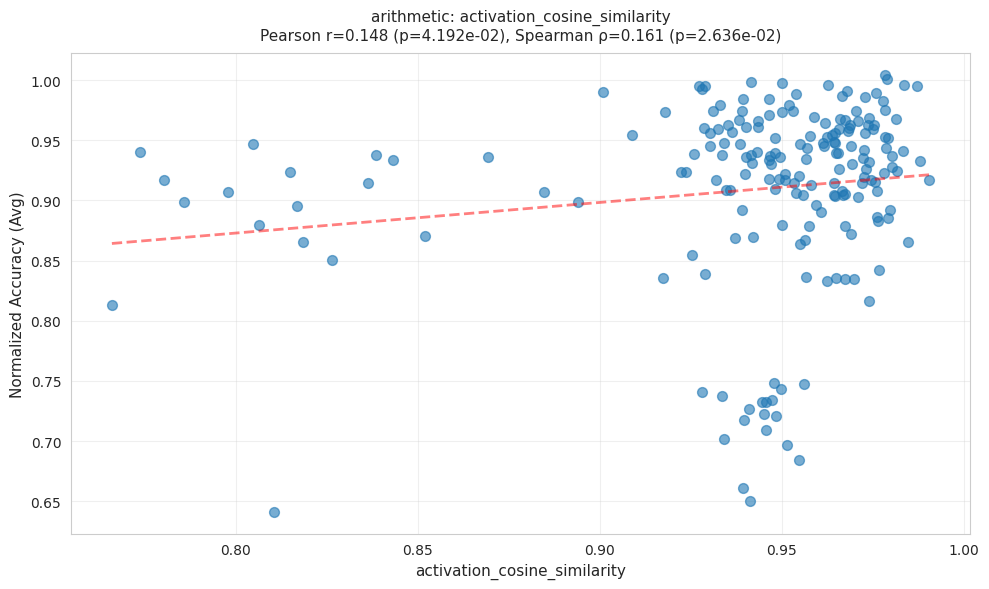


activation_cosine_similarity:
  Data points: 190
  Pearson correlation: r=0.1478, p=4.1917e-02
  Spearman correlation: ρ=0.1611, p=2.6358e-02
Saved: arithmetic_activation_magnitude_ratio.png


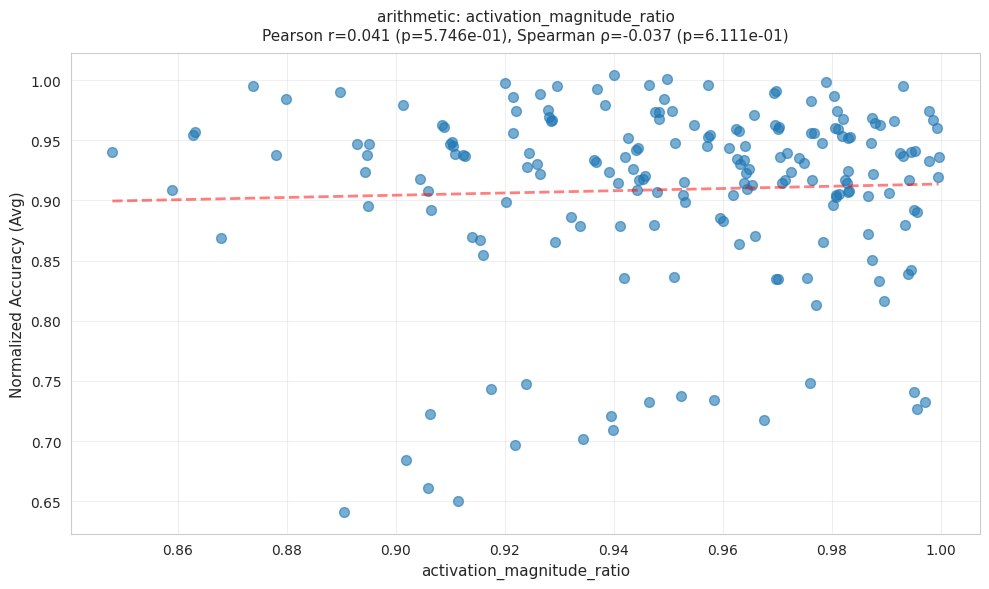


activation_magnitude_ratio:
  Data points: 190
  Pearson correlation: r=0.0410, p=5.7462e-01
  Spearman correlation: ρ=-0.0371, p=6.1108e-01
Saved: arithmetic_activation_dot_product.png


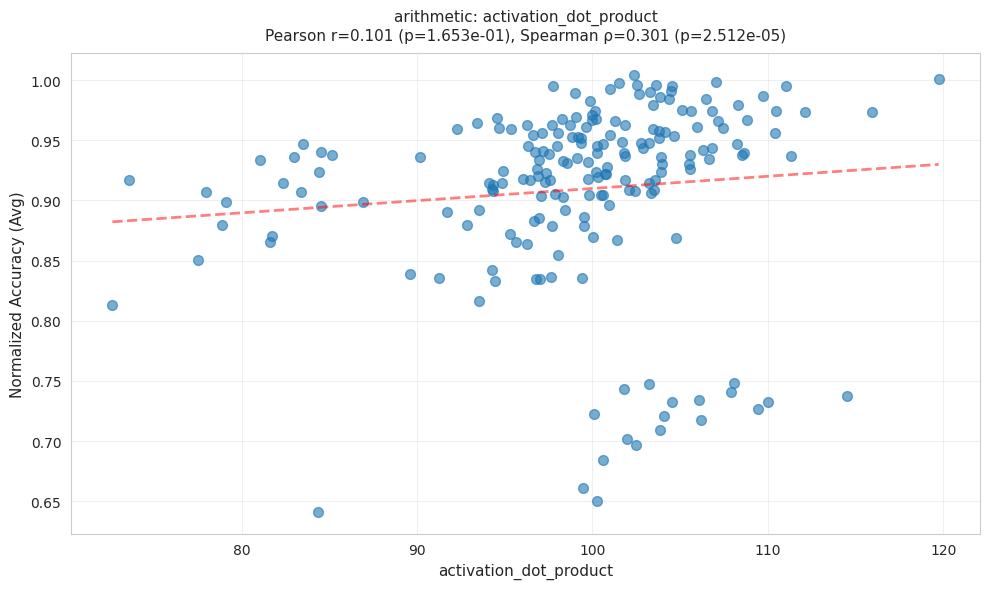


activation_dot_product:
  Data points: 190
  Pearson correlation: r=0.1011, p=1.6527e-01
  Spearman correlation: ρ=0.3006, p=2.5124e-05


In [24]:
# Generate all scatter plots
metric_names = list(mergeability_values.keys())
n_metrics = len(metric_names)
n_mergers = len(merger_methods)

print(f"Generating {n_metrics} x {n_mergers} = {n_metrics * n_mergers} scatter plots...\n")

# Store correlation results
correlation_results = []

for merger in merger_methods:
    print(f"\n{'='*80}")
    print(f"Merger: {merger.upper()}")
    print(f"{'='*80}")
    
    for metric in metric_names:
        x_vals, y_vals, pair_names = create_correlation_data(
            mergeability_values,
            performance_by_merger[merger],
            metric
        )
        
        if len(x_vals) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            pearson_r, pearson_p, spearman_r, spearman_p = create_scatter_plot(
                x_vals, y_vals, pair_names, metric, merger, ax
            )
            plt.tight_layout()
            
            # Save the plot
            plot_filename = f"{merger}_{metric}.png"
            plot_path = Path(PLOT_SAVE_PATH) / plot_filename
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f"Saved: {plot_filename}")
            
            plt.show()
            
            # Store results
            correlation_results.append({
                'merger': merger,
                'metric': metric,
                'n_pairs': len(x_vals),
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p
            })
            
            print(f"\n{metric}:")
            print(f"  Data points: {len(x_vals)}")
            print(f"  Pearson correlation: r={pearson_r:.4f}, p={pearson_p:.4e}")
            print(f"  Spearman correlation: ρ={spearman_r:.4f}, p={spearman_p:.4e}")
        else:
            print(f"\n{metric}: No data available")

## 6. Summary of Correlations

In [25]:
# Create summary dataframe
correlation_df = pd.DataFrame(correlation_results)
print("\nCorrelation Summary:")
print(correlation_df.to_string(index=False))


Correlation Summary:
    merger                                      metric  n_pairs  pearson_r    pearson_p  spearman_r   spearman_p
weight_avg                right_subspace_overlap_top_k      190  -0.058550 4.223076e-01   -0.129886 7.407980e-02
weight_avg             right_subspace_overlap_bottom_k      190  -0.006511 9.289530e-01   -0.079759 2.740022e-01
weight_avg            interaction_matrix_overlap_top_k      190  -0.001749 9.808968e-01   -0.105922 1.458079e-01
weight_avg         interaction_matrix_overlap_bottom_k      190  -0.008751 9.046171e-01   -0.086882 2.332873e-01
weight_avg                              effective_rank      190   0.107036 1.415942e-01   -0.022019 7.629952e-01
weight_avg           effective_rank_mergeability_score      190  -0.107036 1.415942e-01    0.022019 7.629952e-01
weight_avg                                 stable_rank      190   0.092928 2.022255e-01   -0.022019 7.629952e-01
weight_avg                                spectral_gap      190  -0.047574

Saved: correlation_heatmaps.png


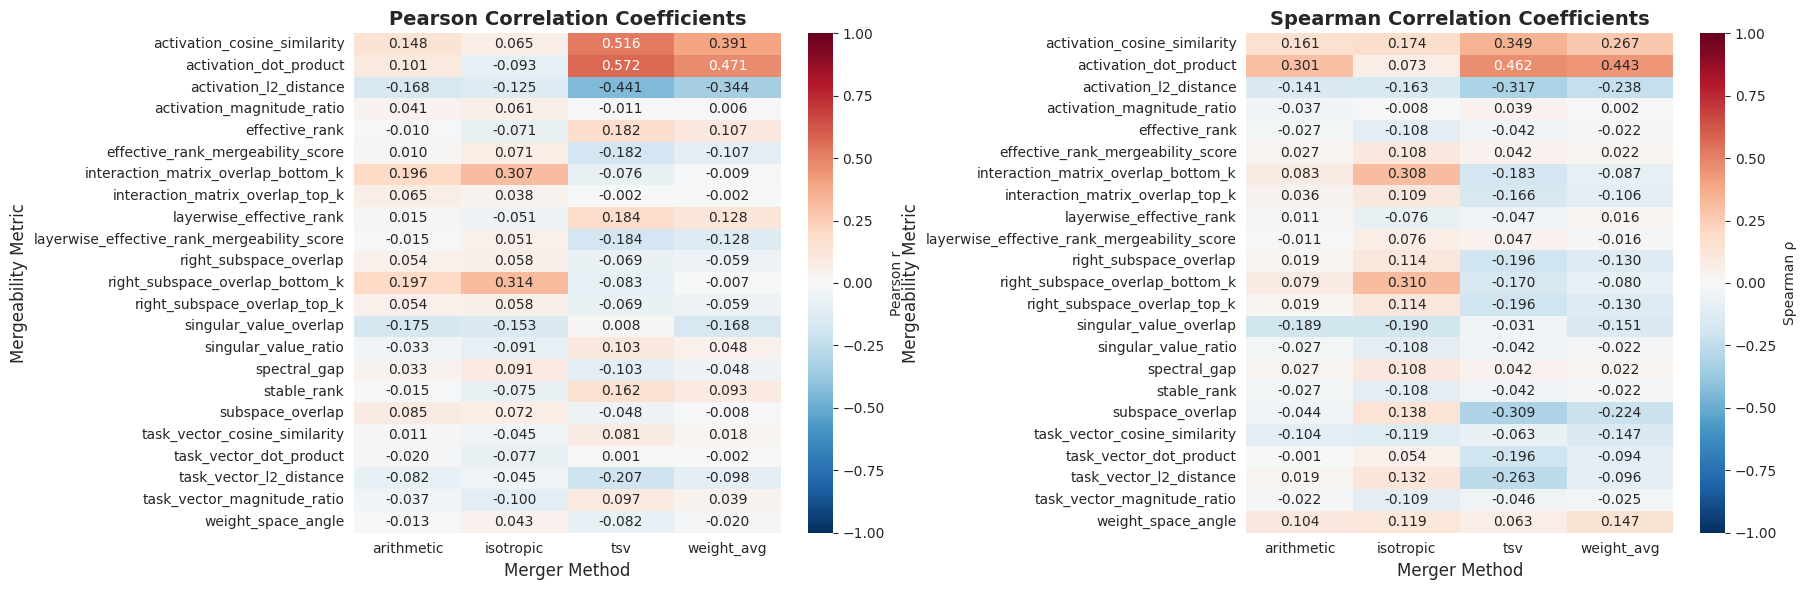

In [26]:
# Visualize correlation strengths as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pearson correlation heatmap
pearson_pivot = correlation_df.pivot(index='metric', columns='merger', values='pearson_r')
sns.heatmap(pearson_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Pearson r'})
axes[0].set_title('Pearson Correlation Coefficients', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Merger Method', fontsize=12)
axes[0].set_ylabel('Mergeability Metric', fontsize=12)

# Spearman correlation heatmap
spearman_pivot = correlation_df.pivot(index='metric', columns='merger', values='spearman_r')
sns.heatmap(spearman_pivot, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Spearman ρ'})
axes[1].set_title('Spearman Correlation Coefficients', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Merger Method', fontsize=12)
axes[1].set_ylabel('Mergeability Metric', fontsize=12)

plt.tight_layout()

# Save the heatmap
heatmap_path = Path(PLOT_SAVE_PATH) / "correlation_heatmaps.png"
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"Saved: correlation_heatmaps.png")

plt.show()

## 7. Statistical Significance Analysis

In [27]:
# Filter for statistically significant correlations (p < 0.05)
significant_correlations = correlation_df[
    (correlation_df['pearson_p'] < 0.05) | (correlation_df['spearman_p'] < 0.05)
].copy()

if len(significant_correlations) > 0:
    print("\nStatistically Significant Correlations (p < 0.05):")
    print("="*100)
    for _, row in significant_correlations.iterrows():
        print(f"\n{row['merger']} + {row['metric']}:")
        if row['pearson_p'] < 0.05:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e} ***")
        else:
            print(f"  Pearson: r={row['pearson_r']:.4f}, p={row['pearson_p']:.4e}")
        
        if row['spearman_p'] < 0.05:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e} ***")
        else:
            print(f"  Spearman: ρ={row['spearman_r']:.4f}, p={row['spearman_p']:.4e}")
else:
    print("\nNo statistically significant correlations found (p < 0.05)")


Statistically Significant Correlations (p < 0.05):

weight_avg + task_vector_cosine_similarity:
  Pearson: r=0.0181, p=8.0373e-01
  Spearman: ρ=-0.1472, p=4.2705e-02 ***

weight_avg + weight_space_angle:
  Pearson: r=-0.0204, p=7.8004e-01
  Spearman: ρ=0.1472, p=4.2705e-02 ***

weight_avg + singular_value_overlap:
  Pearson: r=-0.1682, p=2.0346e-02 ***
  Spearman: ρ=-0.1511, p=3.7379e-02 ***

weight_avg + subspace_overlap:
  Pearson: r=-0.0081, p=9.1173e-01
  Spearman: ρ=-0.2241, p=1.8853e-03 ***

weight_avg + activation_l2_distance:
  Pearson: r=-0.3437, p=1.2042e-06 ***
  Spearman: ρ=-0.2382, p=9.3507e-04 ***

weight_avg + activation_cosine_similarity:
  Pearson: r=0.3910, p=2.4383e-08 ***
  Spearman: ρ=0.2669, p=1.9720e-04 ***

weight_avg + activation_dot_product:
  Pearson: r=0.4707, p=7.2010e-12 ***
  Spearman: ρ=0.4427, p=1.6071e-10 ***

isotropic + right_subspace_overlap_bottom_k:
  Pearson: r=0.3138, p=1.3595e-05 ***
  Spearman: ρ=0.3102, p=1.7331e-05 ***

isotropic + interact

## 8. Best Predictive Metrics

In [28]:
# Rank metrics by absolute correlation strength
correlation_df['abs_pearson_r'] = correlation_df['pearson_r'].abs()
correlation_df['abs_spearman_r'] = correlation_df['spearman_r'].abs()

print("\nTop 10 Strongest Correlations (by Pearson |r|):")
print("="*100)
top_pearson = correlation_df.nlargest(10, 'abs_pearson_r')[[
    'merger', 'metric', 'n_pairs', 'pearson_r', 'pearson_p'
]]
print(top_pearson.to_string(index=False))

print("\n\nTop 10 Strongest Correlations (by Spearman |ρ|):")
print("="*100)
top_spearman = correlation_df.nlargest(10, 'abs_spearman_r')[[
    'merger', 'metric', 'n_pairs', 'spearman_r', 'spearman_p'
]]
print(top_spearman.to_string(index=False))


Top 10 Strongest Correlations (by Pearson |r|):
    merger                              metric  n_pairs  pearson_r    pearson_p
       tsv              activation_dot_product      188   0.571556 1.070863e-17
       tsv        activation_cosine_similarity      188   0.515662 3.655140e-14
weight_avg              activation_dot_product      190   0.470734 7.200995e-12
       tsv              activation_l2_distance      188  -0.440612 2.486794e-10
weight_avg        activation_cosine_similarity      190   0.390998 2.438339e-08
weight_avg              activation_l2_distance      190  -0.343694 1.204190e-06
 isotropic     right_subspace_overlap_bottom_k      185   0.313848 1.359541e-05
 isotropic interaction_matrix_overlap_bottom_k      185   0.306796 2.161964e-05
       tsv             task_vector_l2_distance      188  -0.207072 4.354660e-03
arithmetic     right_subspace_overlap_bottom_k      190   0.197335 6.352347e-03


Top 10 Strongest Correlations (by Spearman |ρ|):
    merger          

## 9. Export Results

In [29]:
# Save correlation results to CSV
output_path = Path(PLOT_SAVE_PATH).parent / "correlation_results.csv"
correlation_df.to_csv(output_path, index=False)
print(f"\nCorrelation results saved to: {output_path}")


Correlation results saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/correlation_results.csv


## 10. Individual Pair Analysis (Optional)

In [30]:
# Create a detailed table showing all metrics and performance for each pair
def create_detailed_pair_table(mergeability_values, performance_by_merger, datasets):
    """
    Create a comprehensive table with all mergeability metrics and performance values for each pair.
    """
    rows = []
    
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            pair_name = f"{datasets[i]}__{datasets[j]}"
            row = {'pair': pair_name, 'task1': datasets[i], 'task2': datasets[j]}
            
            # Add mergeability metrics
            for metric_name, metric_vals in mergeability_values.items():
                row[f"merge_{metric_name}"] = metric_vals.get(pair_name, np.nan)
            
            # Add performance for each merger
            for merger_name, perf_vals in performance_by_merger.items():
                row[f"perf_{merger_name}"] = perf_vals.get(pair_name, np.nan)
            
            rows.append(row)
    
    return pd.DataFrame(rows)

detailed_df = create_detailed_pair_table(mergeability_values, performance_by_merger, datasets)

# Save to CSV
detailed_output_path = Path(PLOT_SAVE_PATH).parent / "detailed_pair_data.csv"
detailed_df.to_csv(detailed_output_path, index=False)
print(f"\nDetailed pair data saved to: {detailed_output_path}")

# Display first few rows
print("\nFirst 5 rows of detailed pair data:")
print(detailed_df.head())


Detailed pair data saved to: /home/ubuntu/thesis/MM/model-merging/results/mergeability/ViT-B-16/correlation/detailed_pair_data.csv

First 5 rows of detailed pair data:
               pair   task1     task2  merge_right_subspace_overlap_top_k  \
0      SUN397__Cars  SUN397      Cars                            0.410936   
1  SUN397__RESISC45  SUN397  RESISC45                            0.443241   
2   SUN397__EuroSAT  SUN397   EuroSAT                            0.369886   
3      SUN397__SVHN  SUN397      SVHN                            0.296418   
4     SUN397__GTSRB  SUN397     GTSRB                            0.325268   

   merge_right_subspace_overlap_bottom_k  \
0                               0.382336   
1                               0.387369   
2                               0.339736   
3                               0.324579   
4                               0.316530   

   merge_interaction_matrix_overlap_top_k  \
0                                0.205942   
1            